In [1]:
# basic python libraries for data analysis and visulaization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

# Data Preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


# Algorithms 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Model evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=np.inf)

# # Supress Warnings
# import warnings
# warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

### Metholody and Approach

1. Importing the dataset and understanding the dataset - Understanding mean, median, standard deviation of all the columns and their implicaitons
2. Understanding the response variable - Popularity of the charging pool `n_RFID` - balanced or imbalanced, rate of popularity etcm
3. Data preprocessing and consistency checks - Null values, object or string columns and treating etc.
4. Univariate and Bi-variate analysis and understanding which features are more correlated with popularity of charging pools.
5. Data preparation for modelling - stratified train, test split, scaling the data, outlier treatment
6. Data Modelling using the following classification algorithms
6.1 Tuning `Logistic Regression` model hyperparameters using cross validation `roc_auc` score and identifying best penalty - `l1`, `l2`, `elasticnet`
6.2 Tuning `Random Forest` Hyperparameters using cross validation `roc_auc` score 
6.3 Tuning `Gradient Boosting Regression Trees` model Hyperparameters using cross validation `roc_auc` score 
7. Visualizing `roc_auc` and `precision-recall` curves and interpreting the results for these three algorithms
7.1 Identifying optimum thresholds for these three alogirthms using maximum F1Score
7.2 Getting the metrics such as Accuracy, precision, recall at the above optimum thresholds and interpreting the results
8. Feature importance using these three tuned models. `L1 penalty` regression model results in sparse coefficient and therefore can be uased for feature selection
8.1 Identiying features that can impact popularity of charging pools


### Importing the dataset and understanding the structure of the dataset 

In [ ]:
# creating station_data dataframe and checking the data
station_data = pd.read_csv('station_popularity_GIS_data.csv')
print(station_data.shape)
station_data.head()

In [ ]:
# using describe function to understand mean, median (50%), standard deviation and max volume of each colums
station_data.describe()

In [ ]:
station_data.info()

### Understanding response variable `n_RFID`- Popularity of a charging pool (1/0)

The response variable is n_RFID (popularity of charging pool) 

In [2]:
station_data['n_RFID'].value_counts()

NameError: name 'station_data' is not defined

so there are 948 unpopular stations and 323 popular stations

In [3]:
n_popular = station_data['n_RFID'].value_counts()[1]
n_unpopular = station_data['n_RFID'].value_counts()[0]
len_df = station_data.shape[0]

# printing number of popular and unpopular and percentage of popular chargin pools
print('Total number of popular charing pools are {}'.format(n_popular))
print('Total number of unpopular charging pools are {}'.format(n_unpopular))
print('Percentage of popular charging pools are {}%'.format(round(n_popular/len_df*100, 2)))


# plotting 
plt.figure(figsize = (8,6))
sns.countplot(station_data['n_RFID'])
plt.title('Count Plot of charging pools - Popular(1) vs unpopular(0)')
plt.show()

NameError: name 'station_data' is not defined

### Data Preprocessing 

In [ ]:
# checking the columns for objects, strings datta types
len(station_data.select_dtypes(include='number').columns)

173

All the columns are numerical data type and doesnt require any one hot encoding or dummy creation

In [ ]:
# Checking for null values
station_data.isnull().sum().sum()

0

There are no null values in the provided data

In [ ]:
# Checking the cols with low unique values
cat_cols = station_data.nunique()[station_data.nunique()<10].index.to_list()
for col in cat_cols:
    print('understanding the value counts for category column {}'.format(col))
    print(station_data[col].value_counts())

# removing response variable from cat_cols
cat_cols.remove('n_RFID')

understanding the value counts for category column n_RFID
0    948
1    323
Name: n_RFID, dtype: int64
understanding the value counts for category column PC31
1.000000    1125
2.000000      87
0.000000      31
3.000000      21
5.000000       2
4.000000       2
4.323037       1
3.204392       1
0.854006       1
Name: PC31, dtype: int64
understanding the value counts for category column n.family
0    1094
1     137
2      24
3      13
4       3
Name: n.family, dtype: int64
understanding the value counts for category column n.public
0    815
1    286
2    108
3     37
4     12
5      9
7      2
6      2
Name: n.public, dtype: int64
understanding the value counts for category column RoadType_residential
1    931
0    340
Name: RoadType_residential, dtype: int64
understanding the value counts for category column RoadType_secondary
0    1141
1     130
Name: RoadType_secondary, dtype: int64
understanding the value counts for category column RoadType_tertiary
0    1089
1     182
Name: RoadType

### EDA

In [ ]:
# defining functions for num_plot which would be used for plotting univariate analysis and bi-variate analysis graphs 
# to understand the data 
def num_plot(col):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))
    sns.boxplot(x = 'n_RFID', y = col, data = station_data, ax = ax1)
    sns.distplot(station_data[col], ax = ax2)
    ax1.set_title('{} vs popularity of charging pools'.format(col))
    ax2.set_title('Distribution plot of {}'.format(col))
    plt.show()

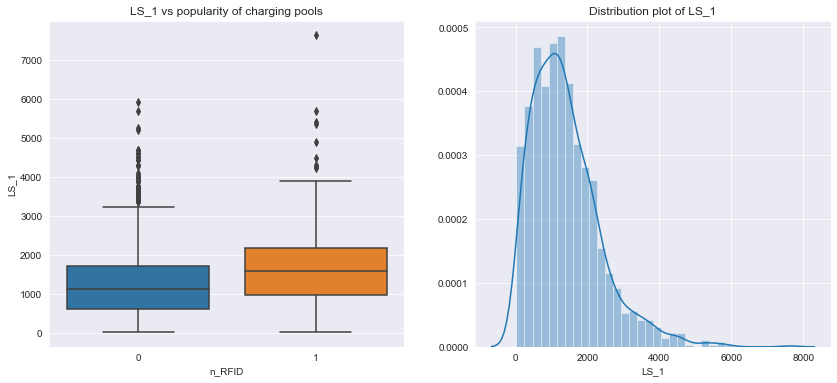

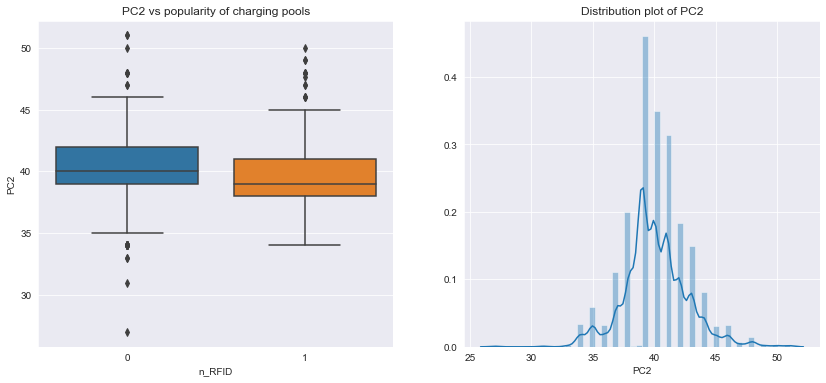

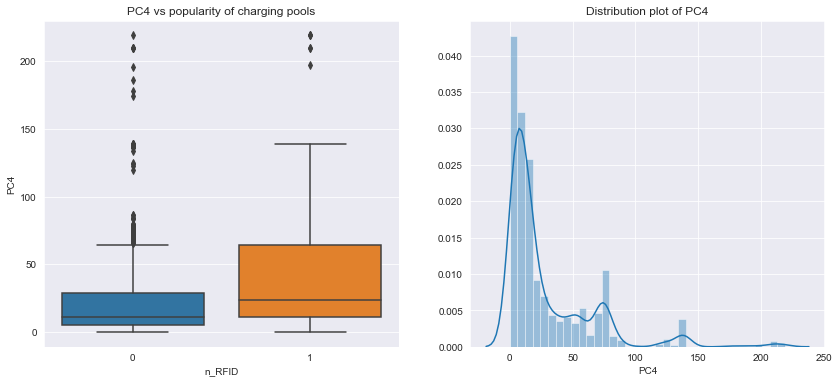

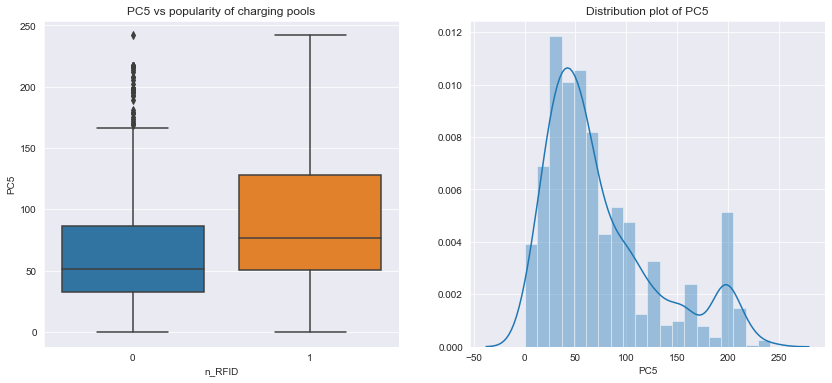

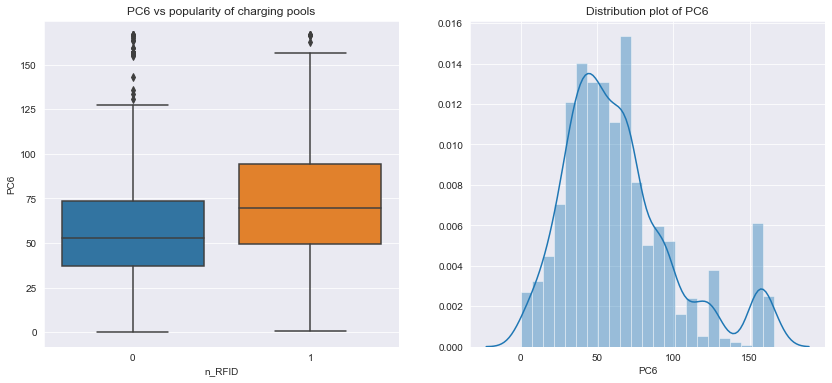

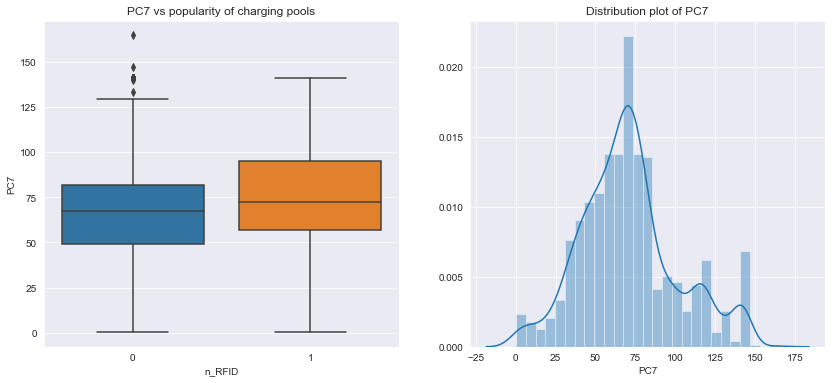

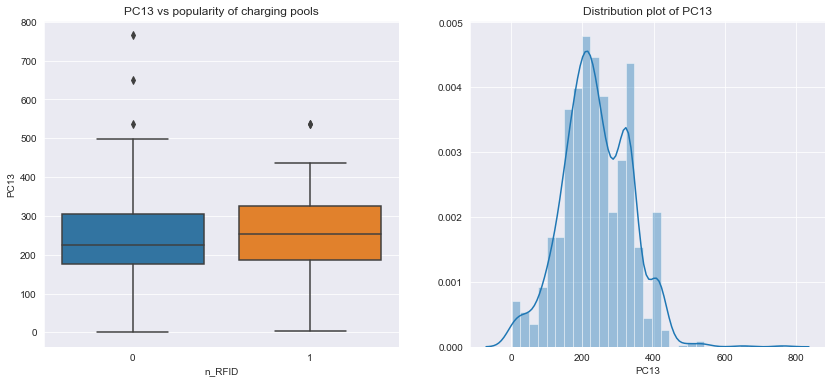

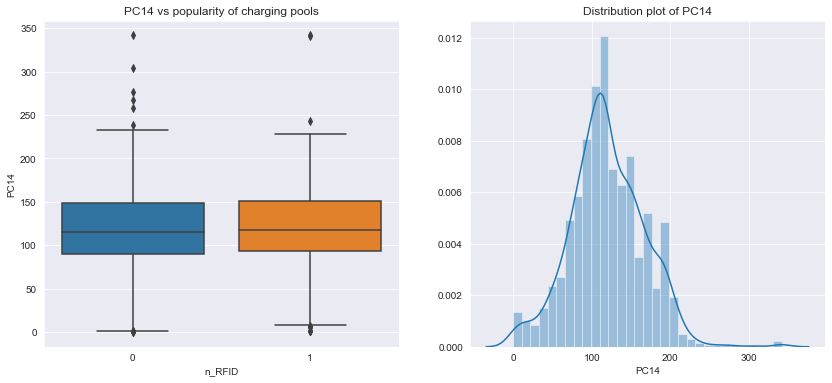

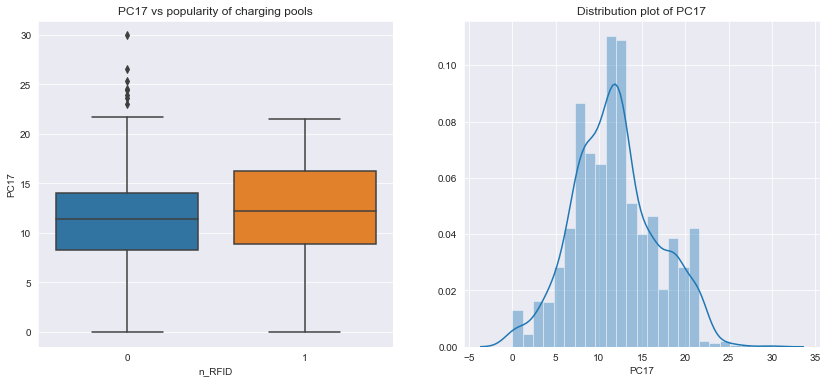

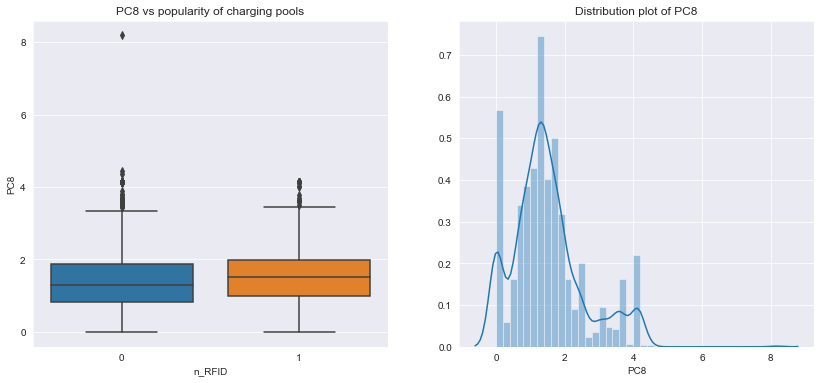

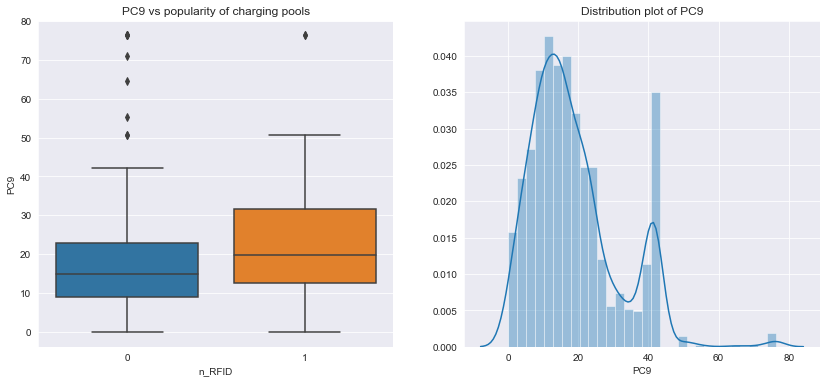

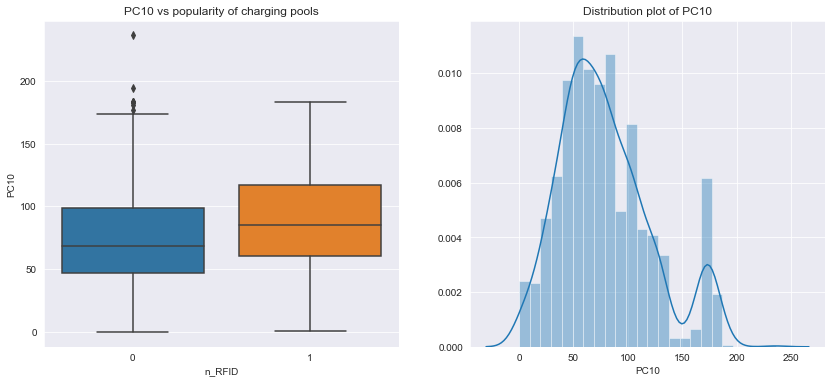

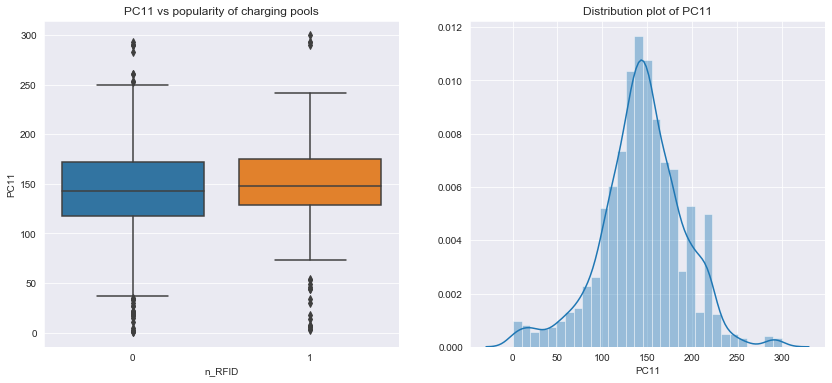

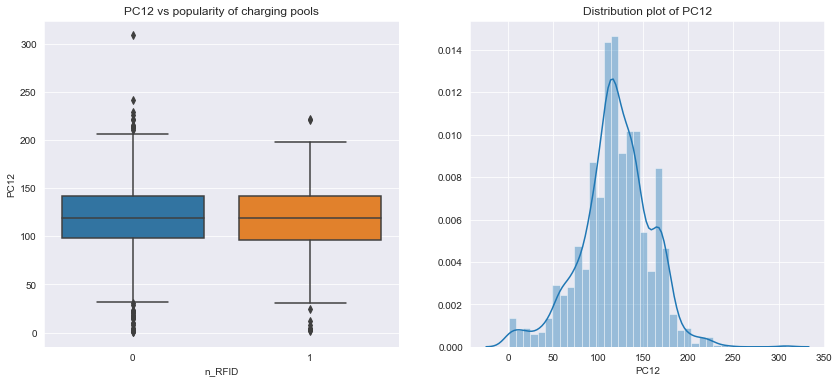

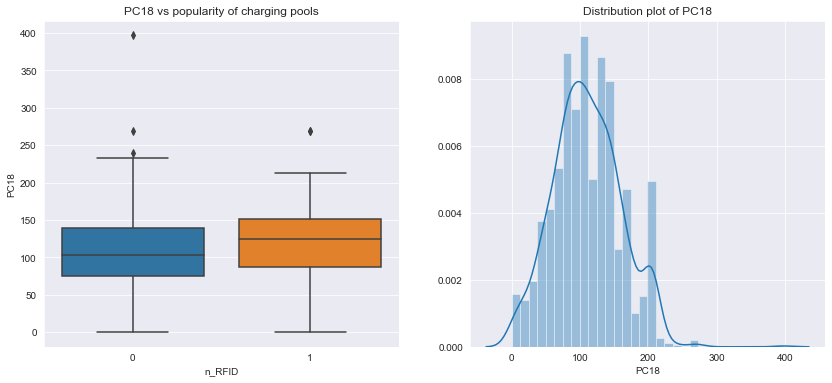

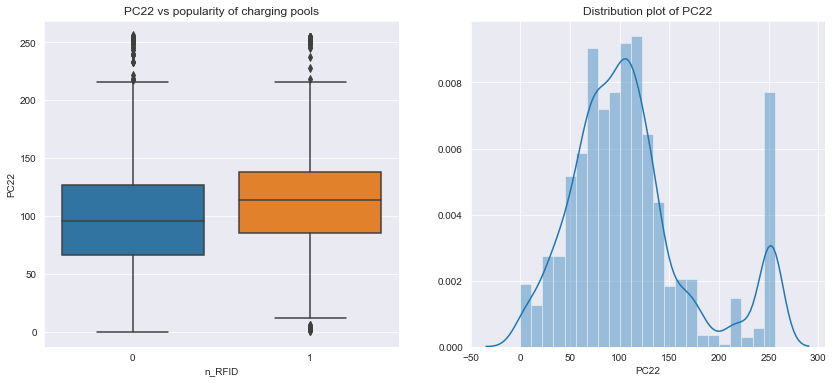

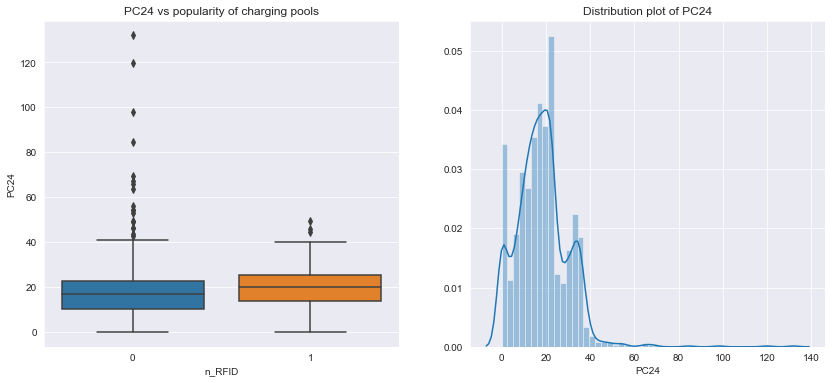

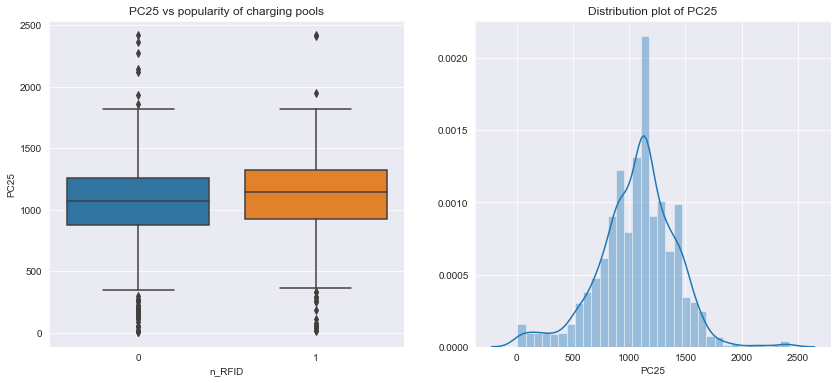

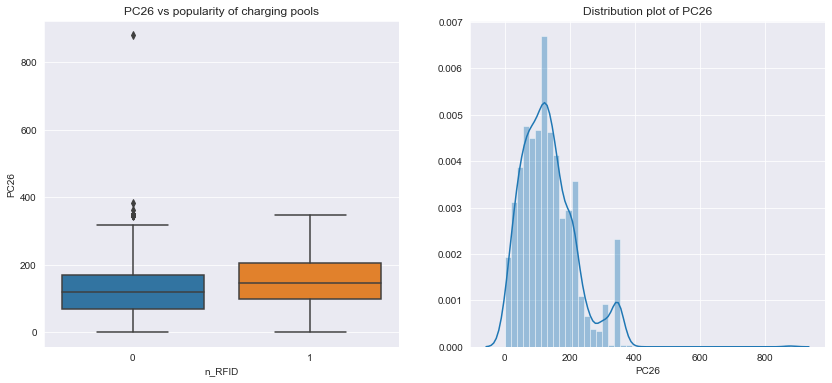

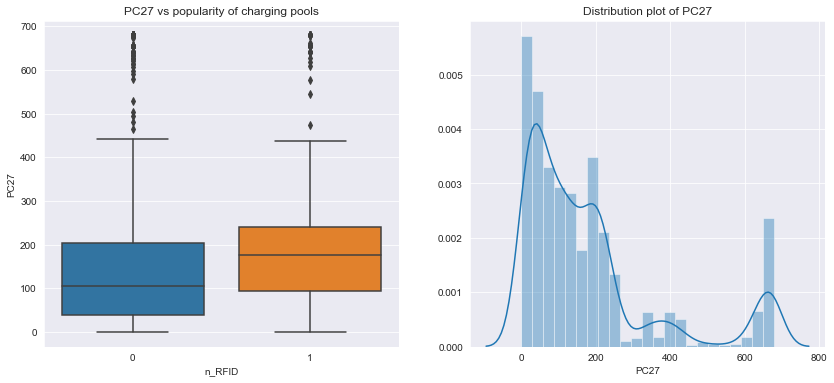

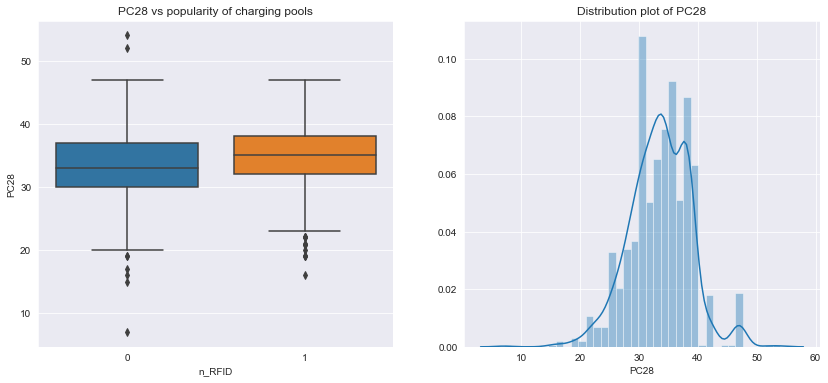

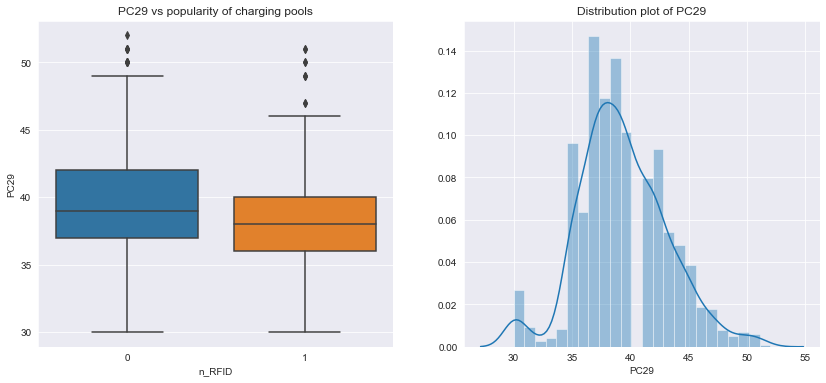

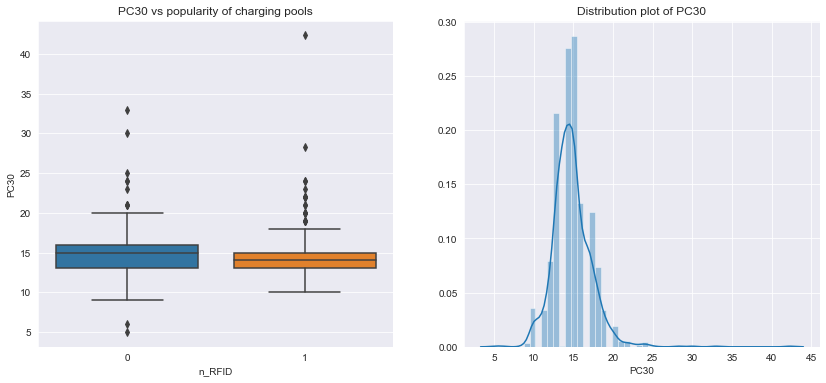

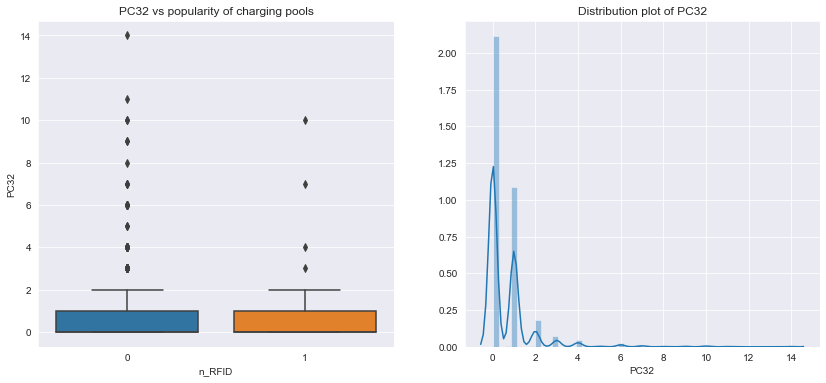

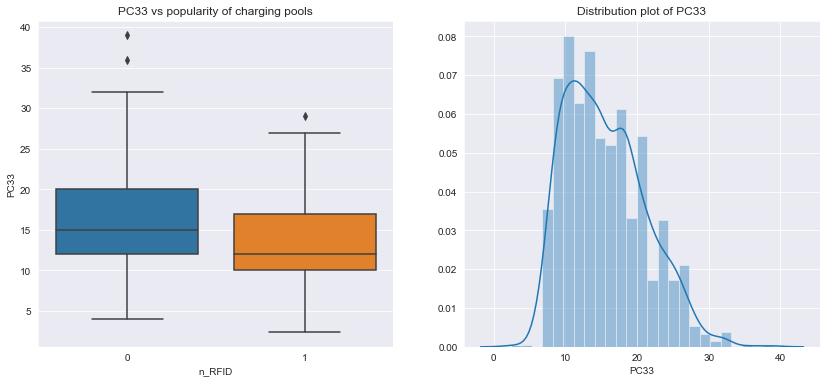

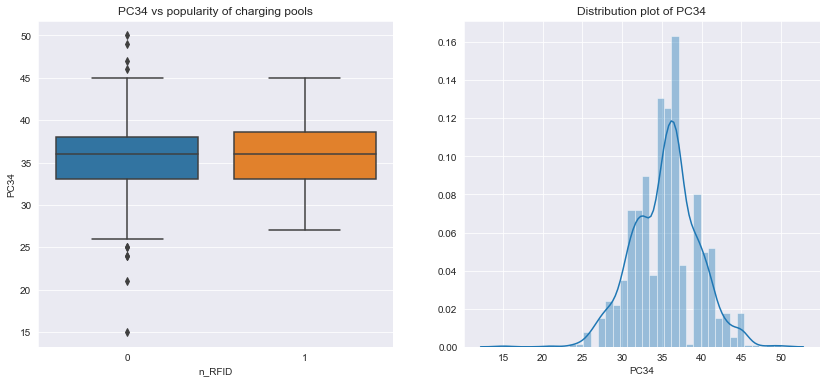

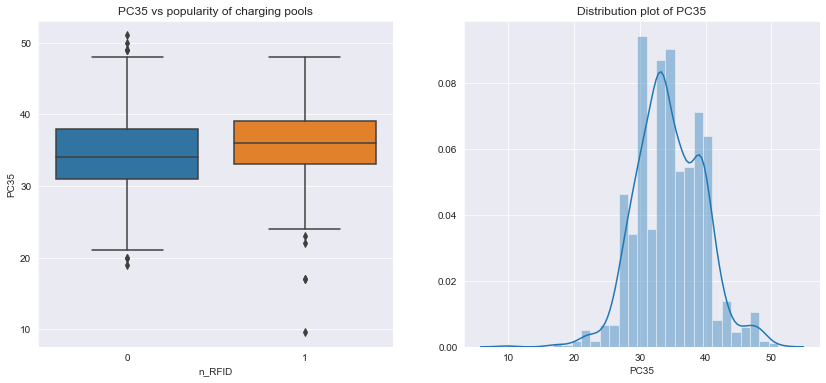

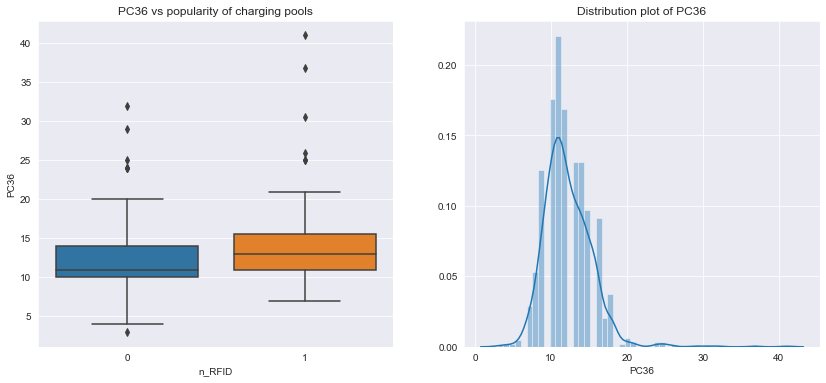

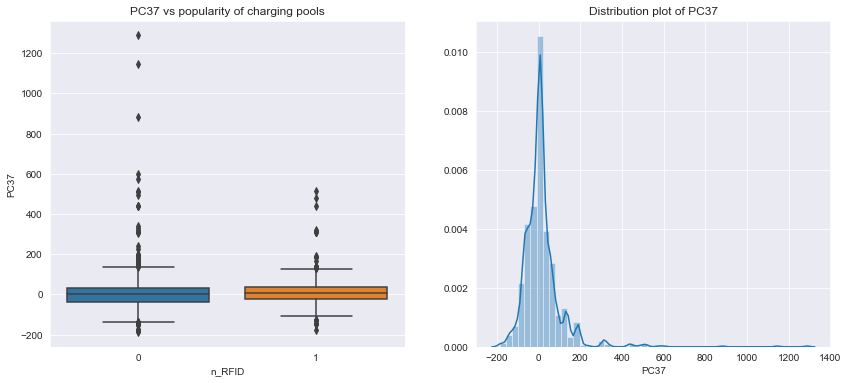

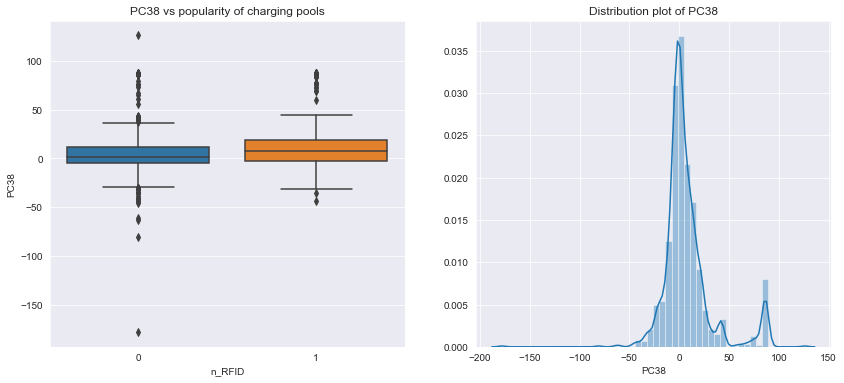

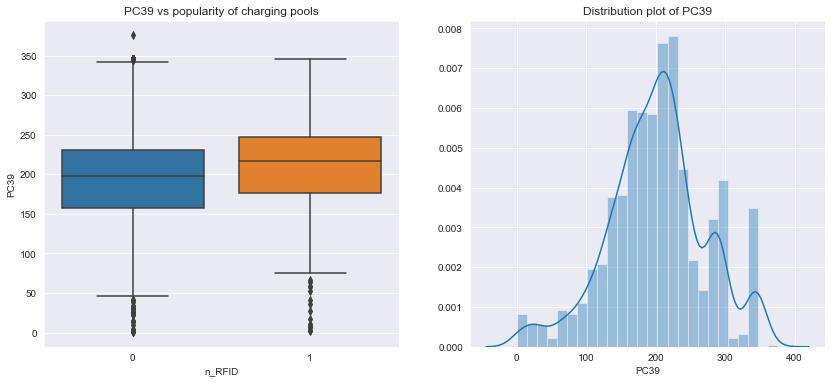

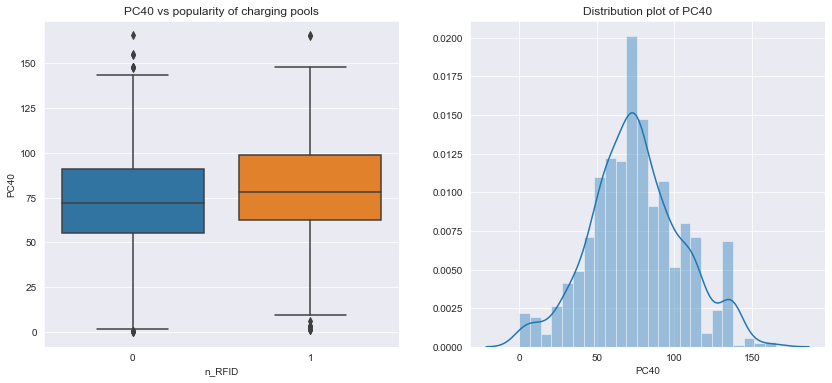

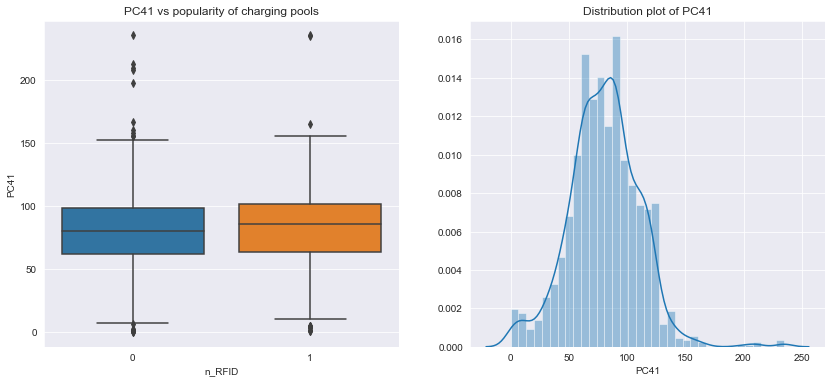

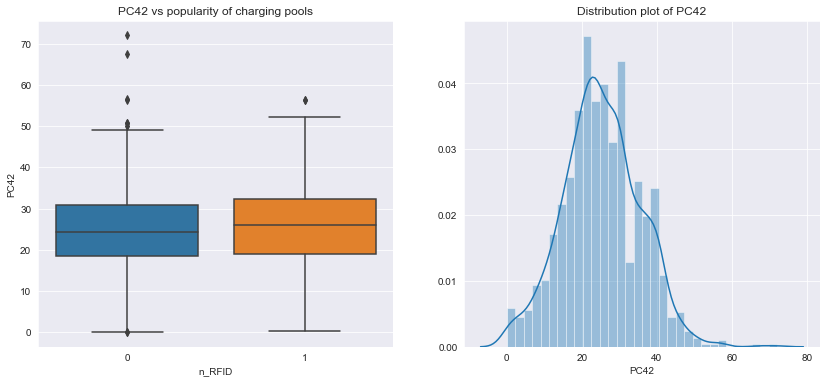

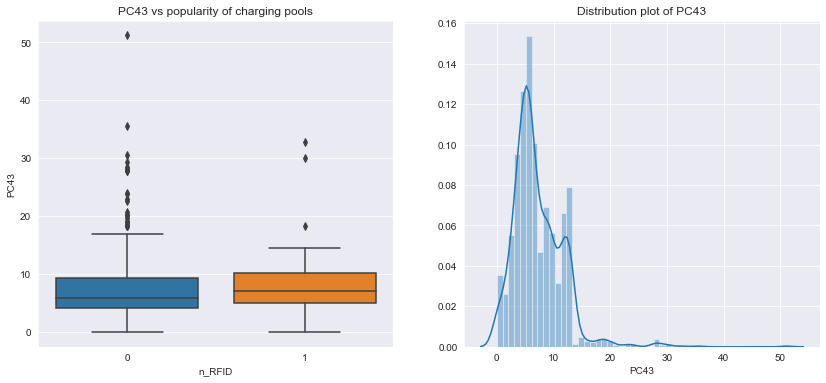

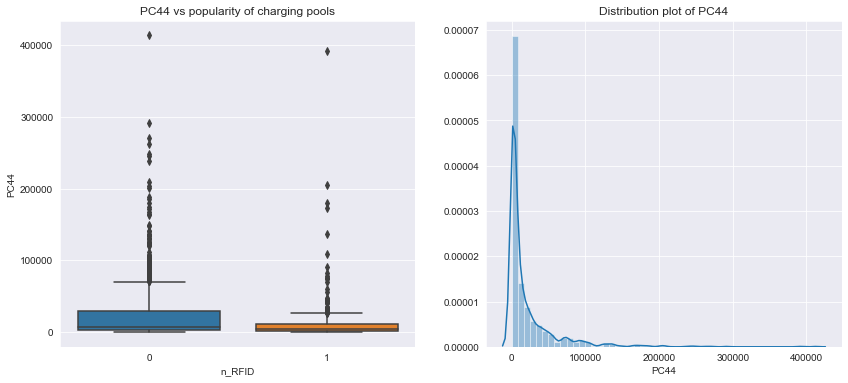

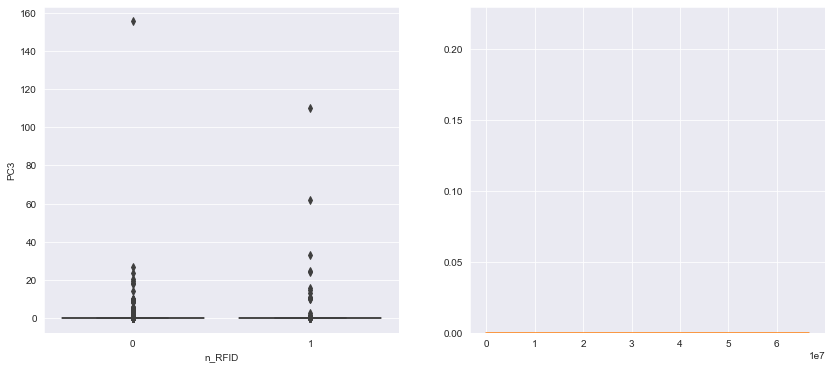

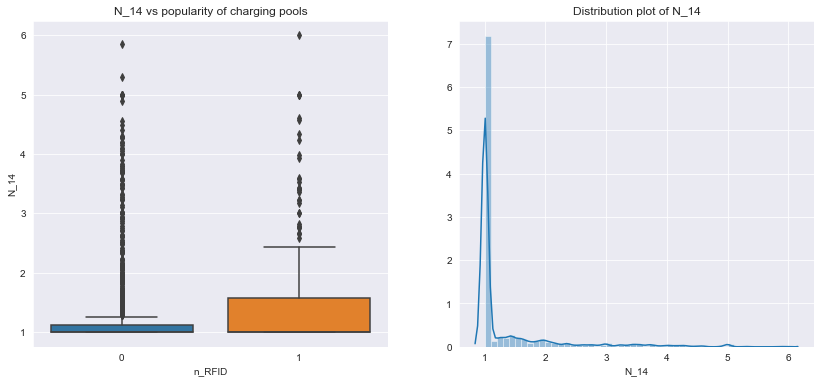

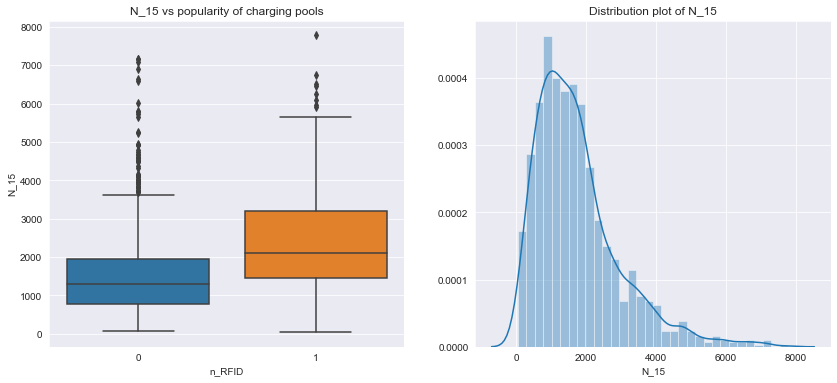

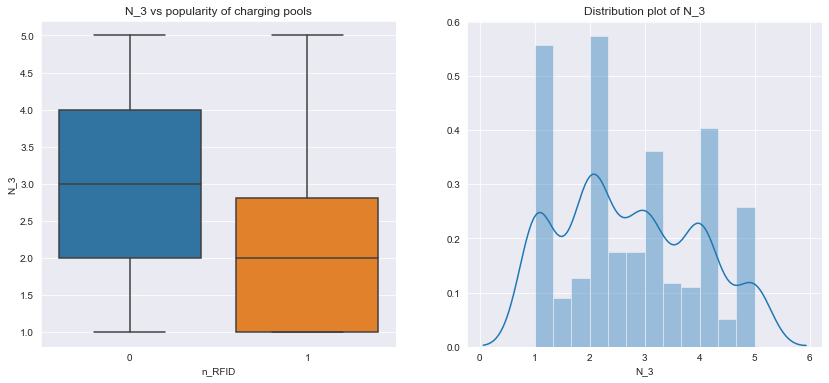

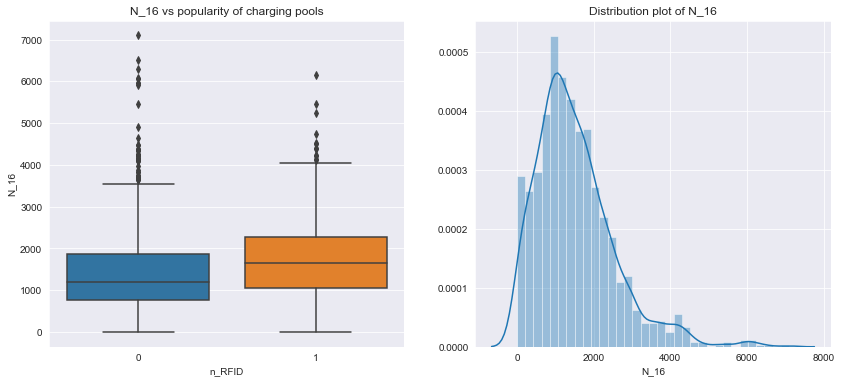

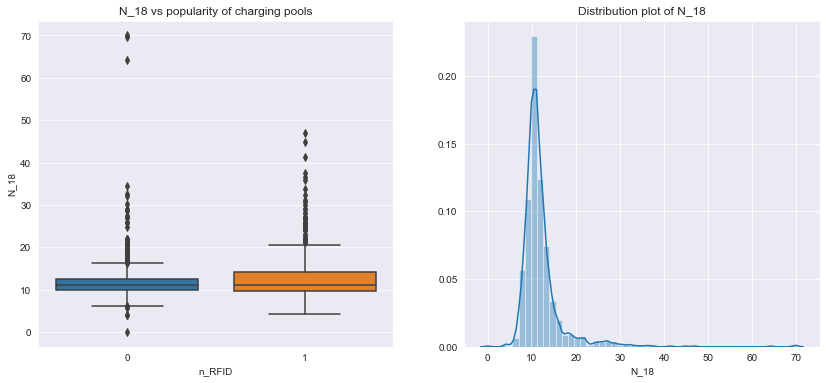

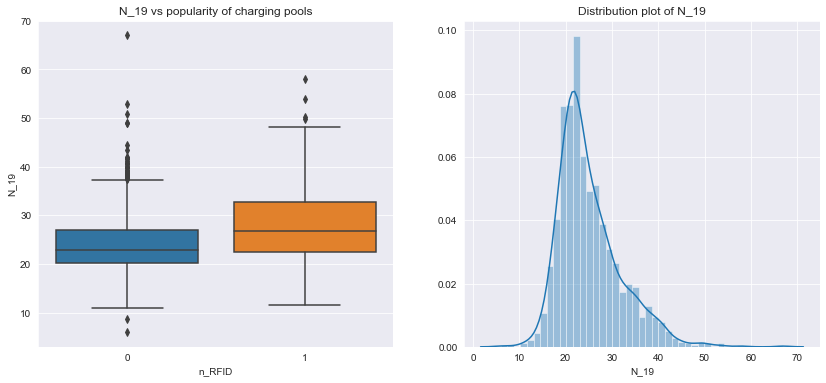

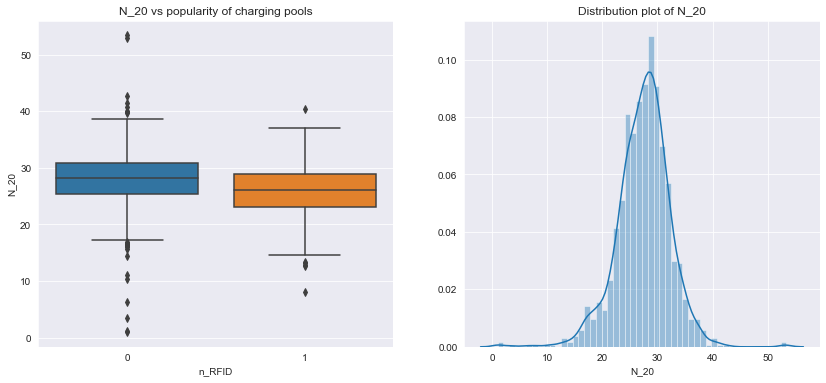

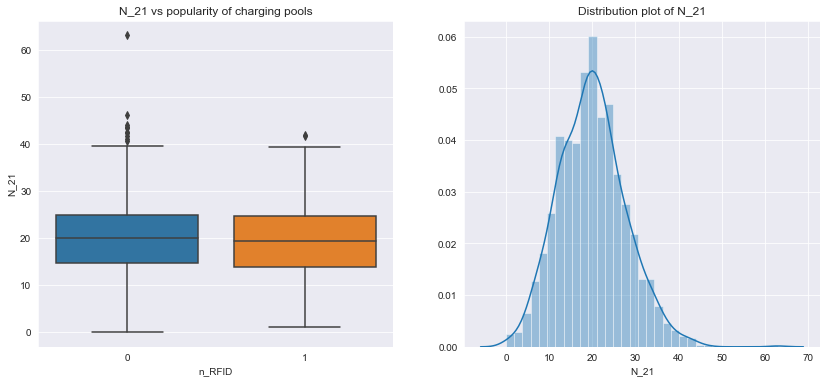

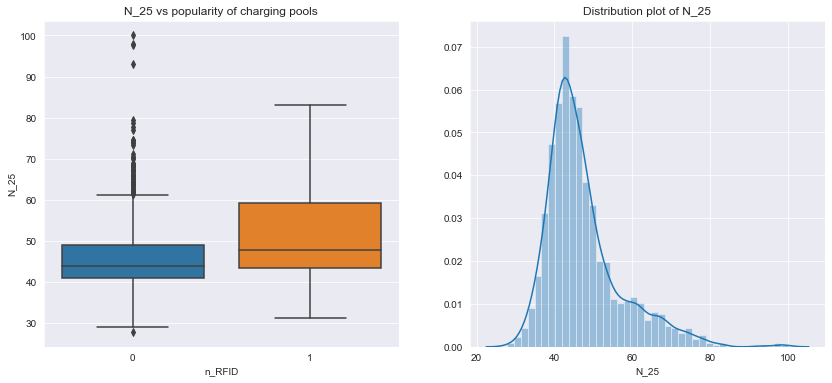

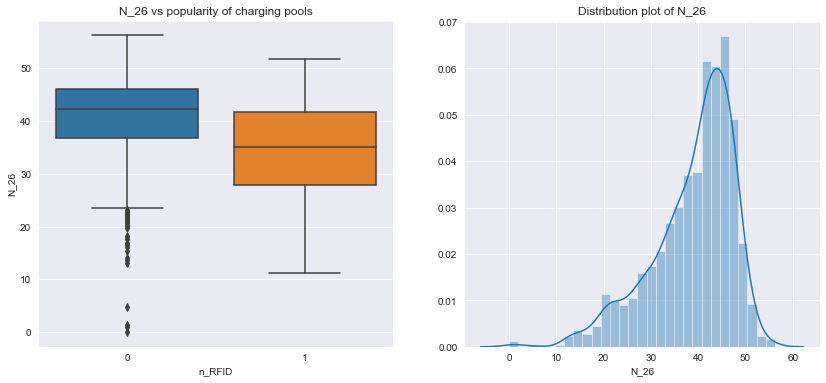

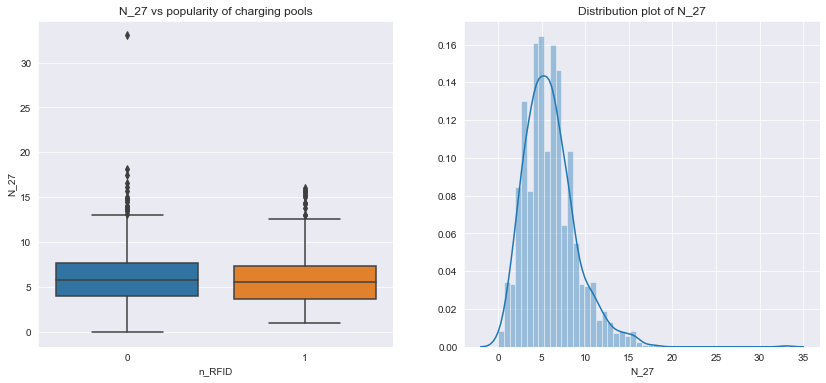

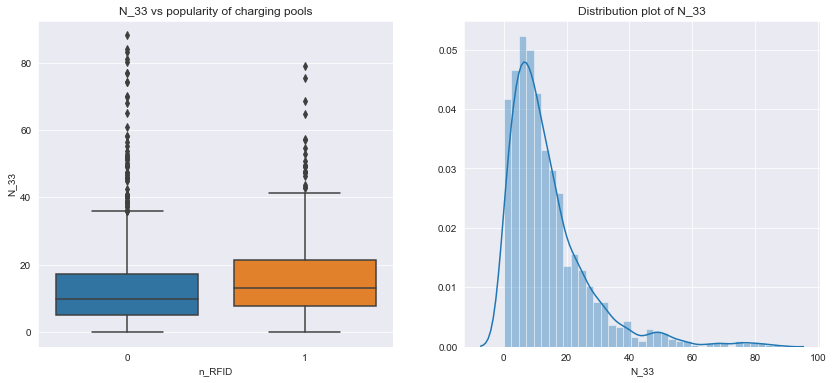

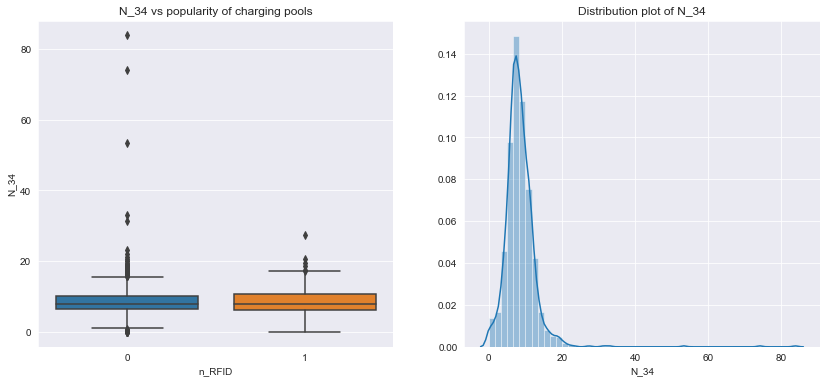

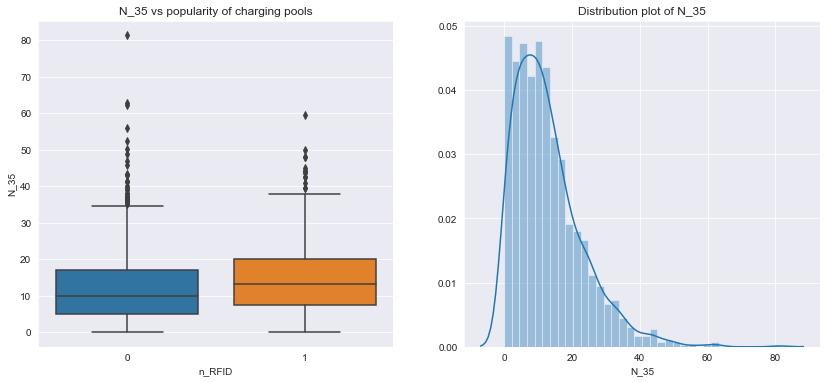

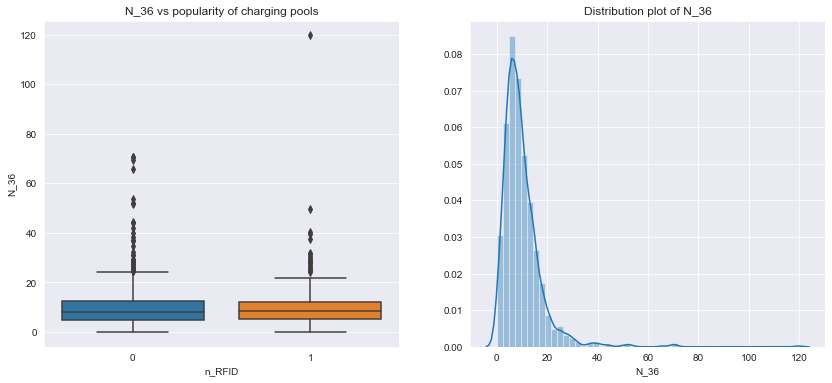

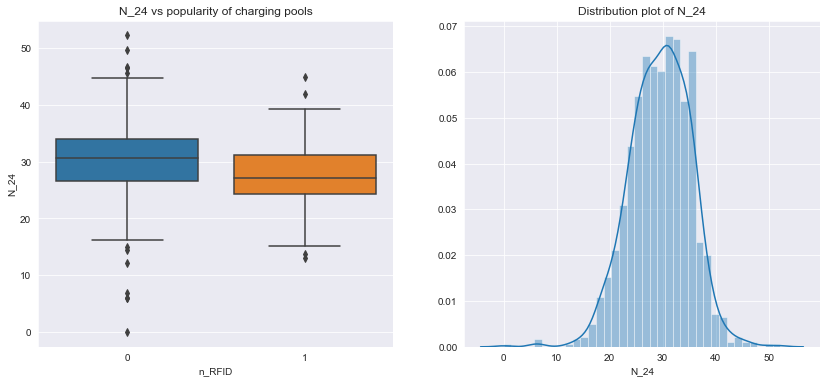

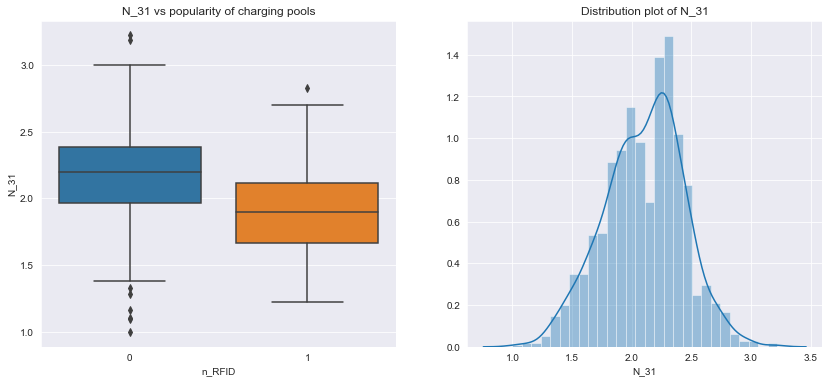

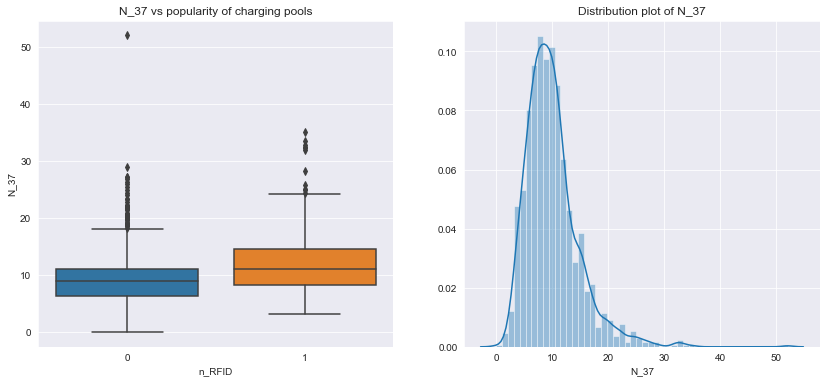

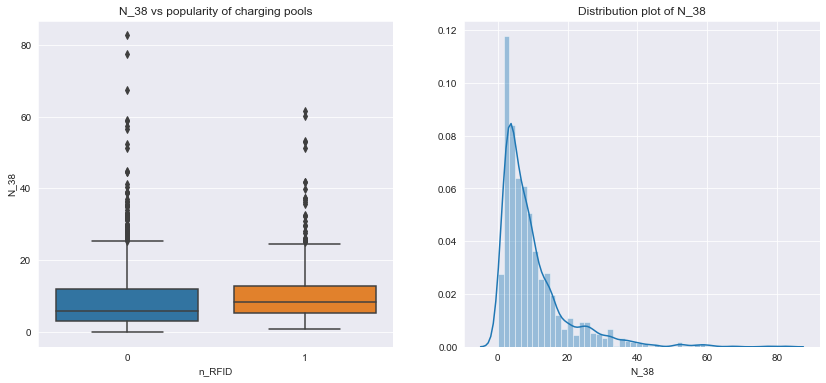

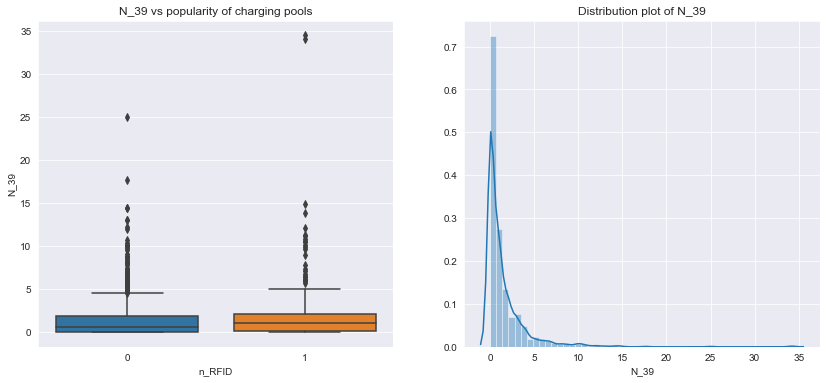

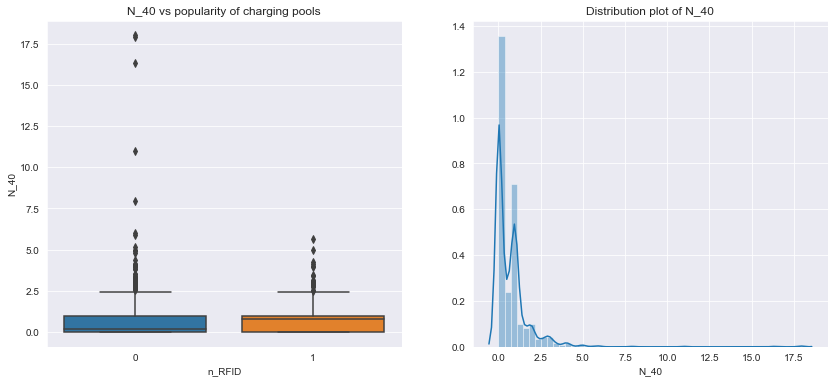

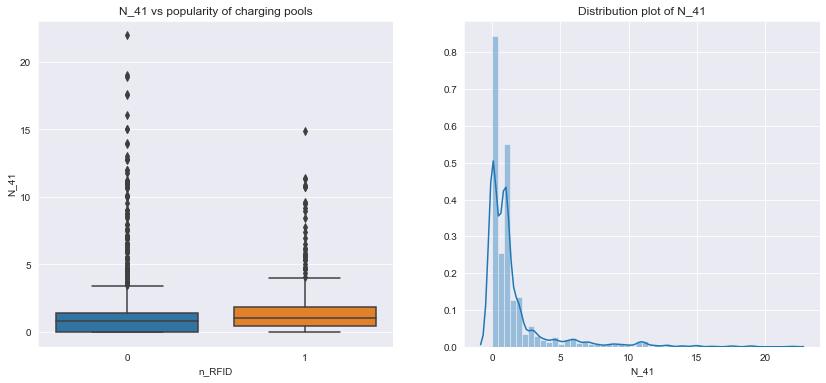

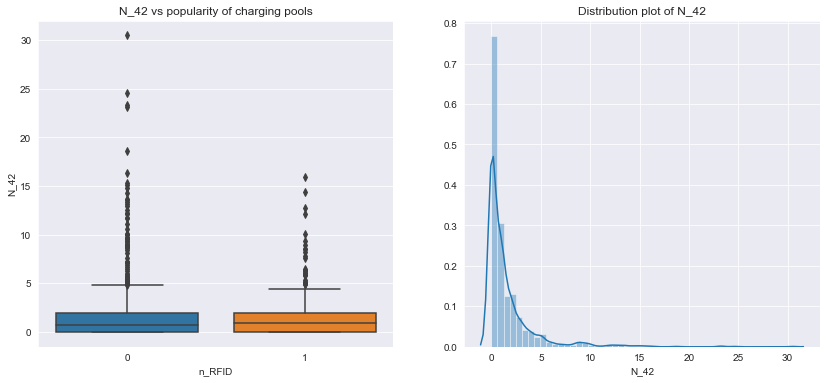

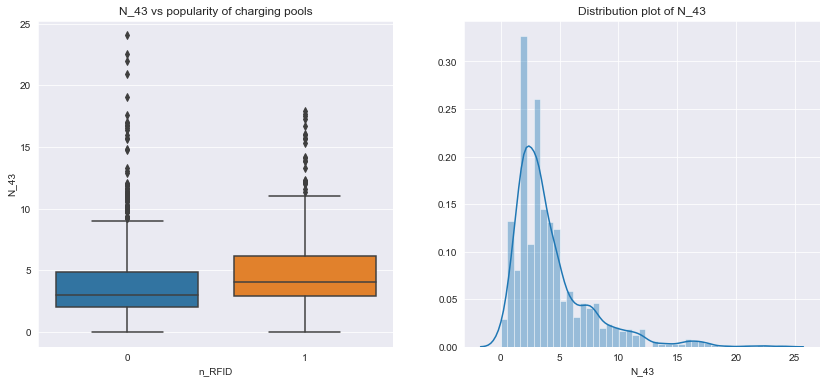

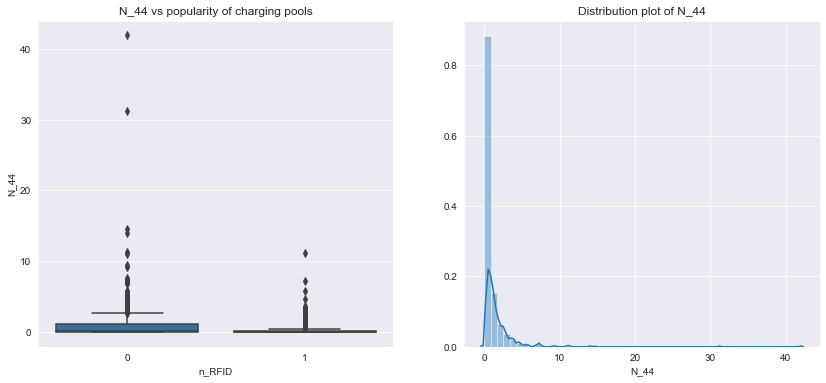

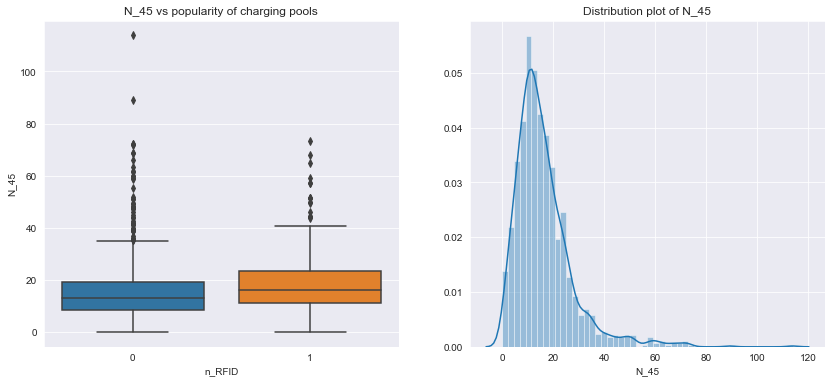

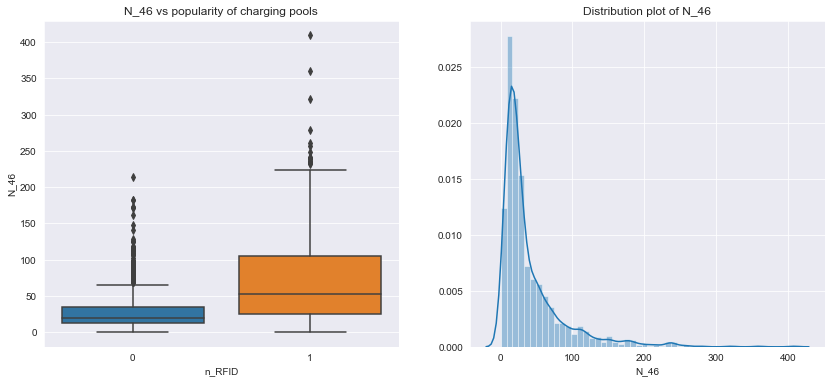

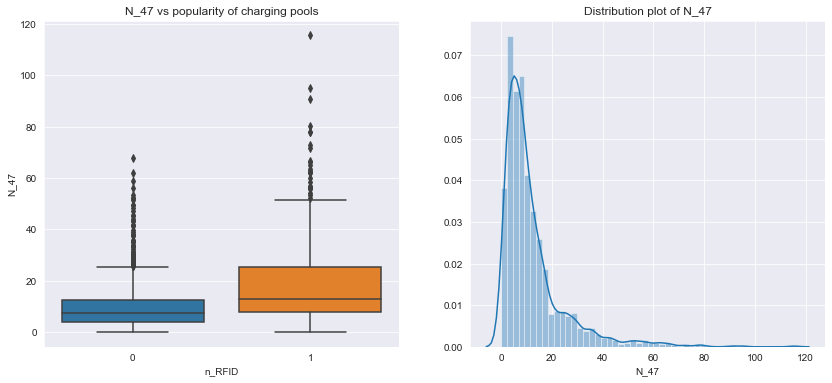

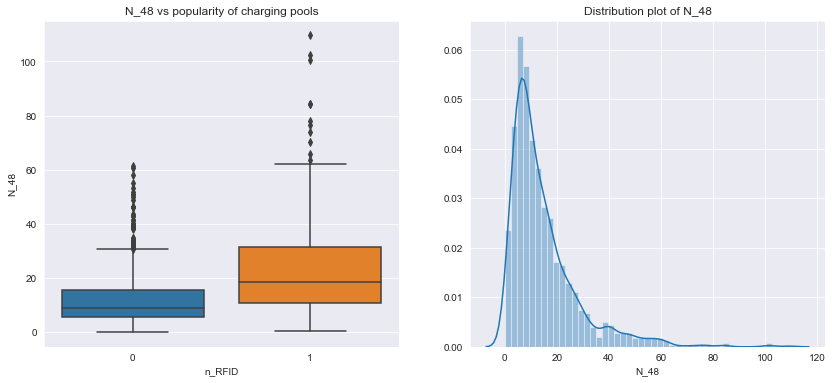

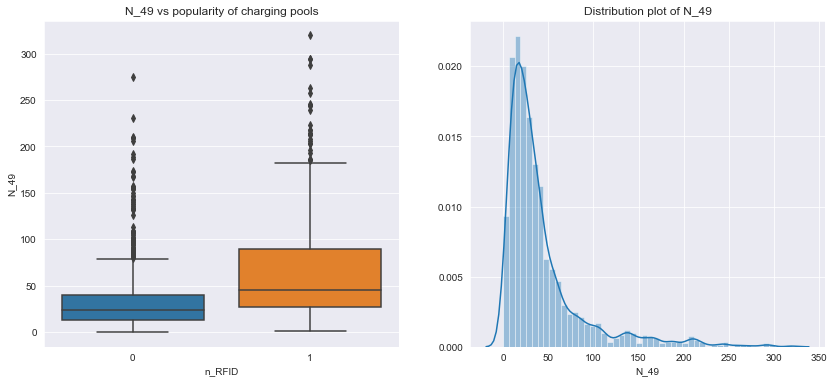

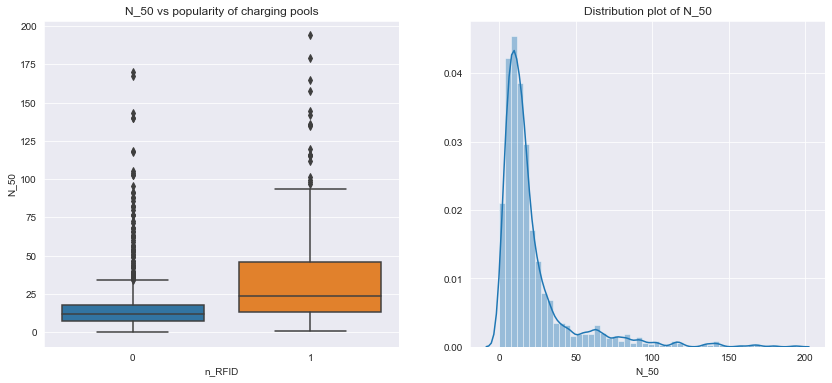

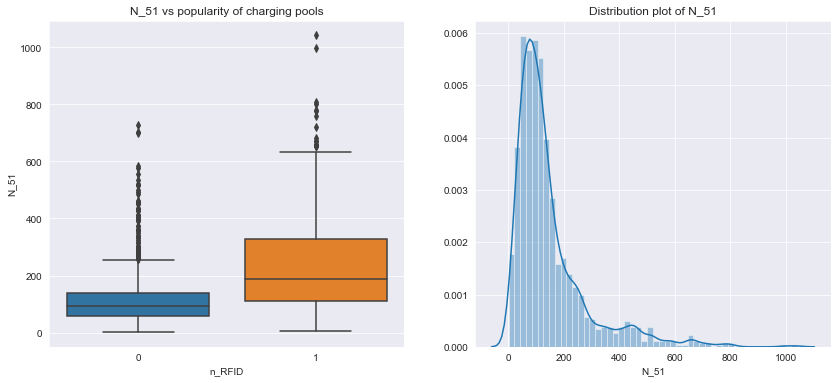

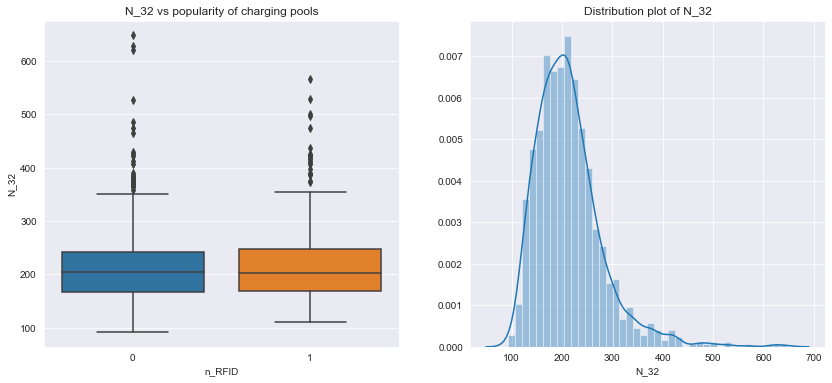

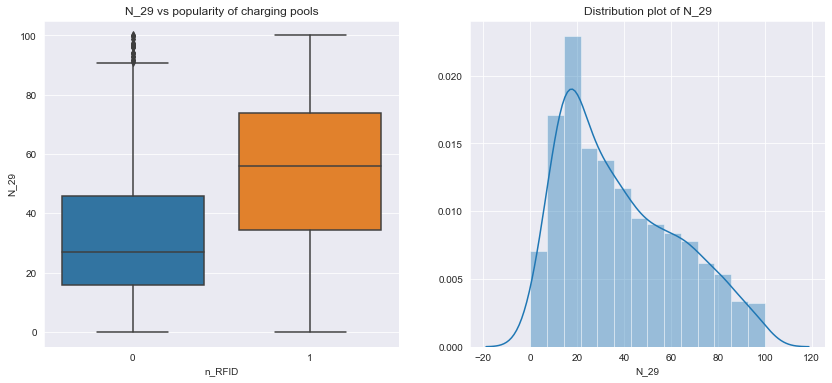

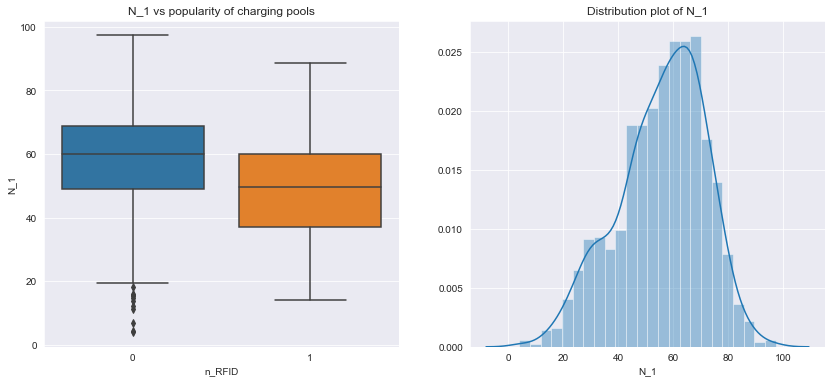

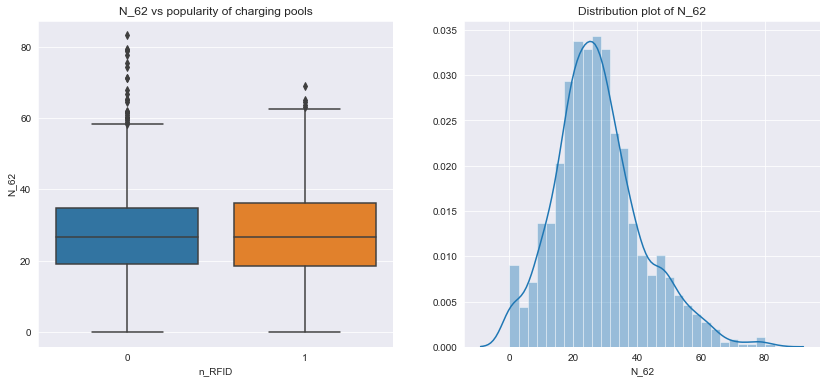

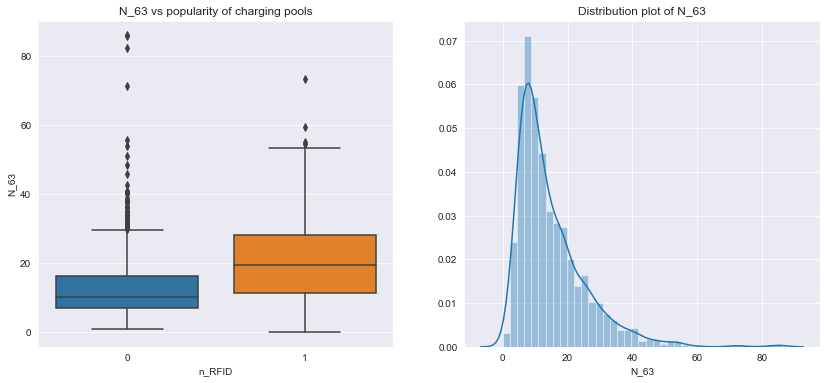

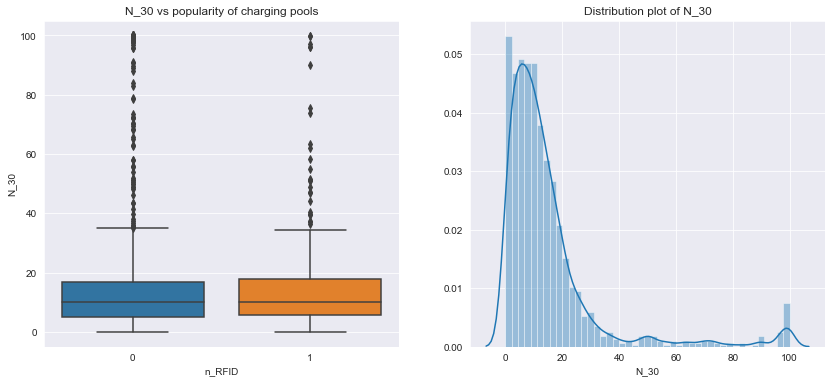

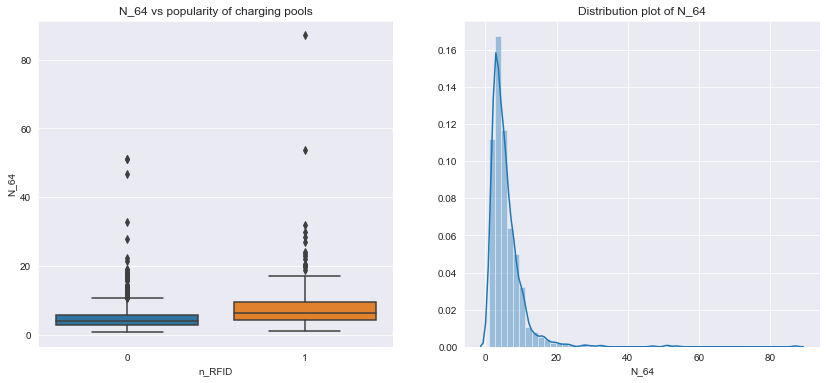

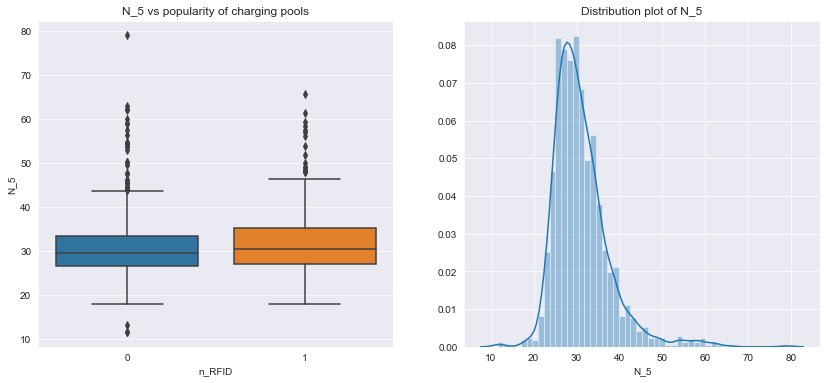

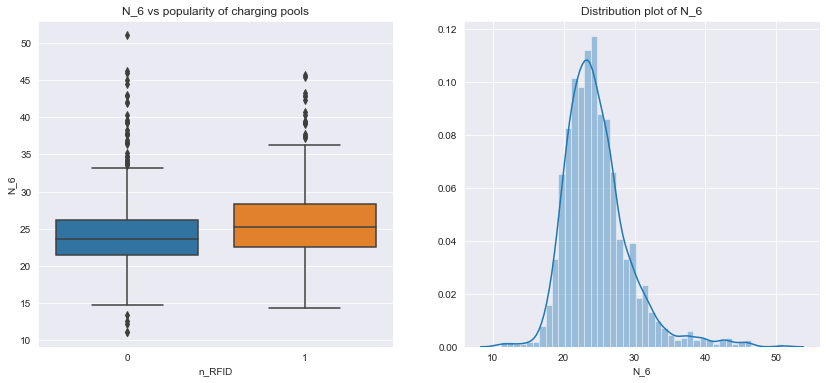

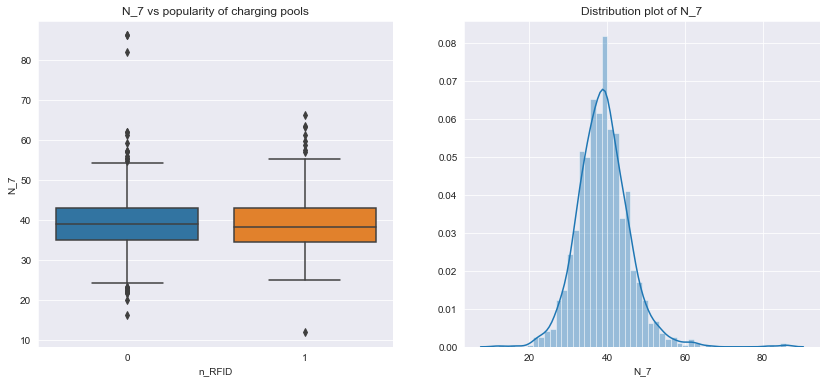

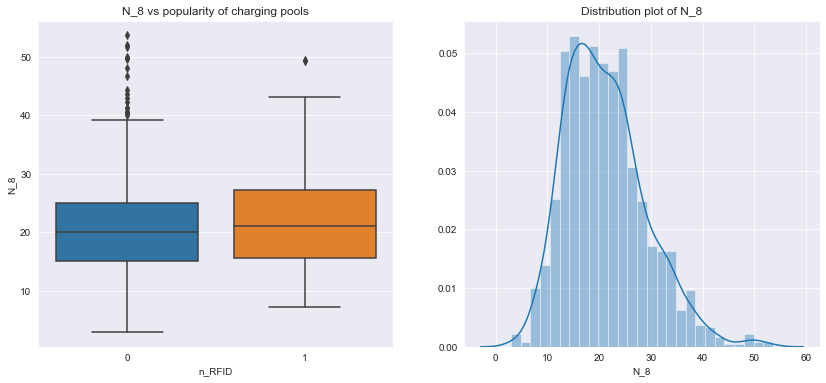

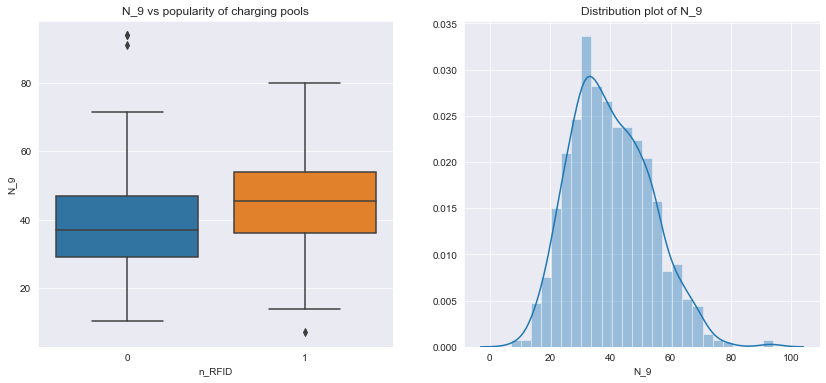

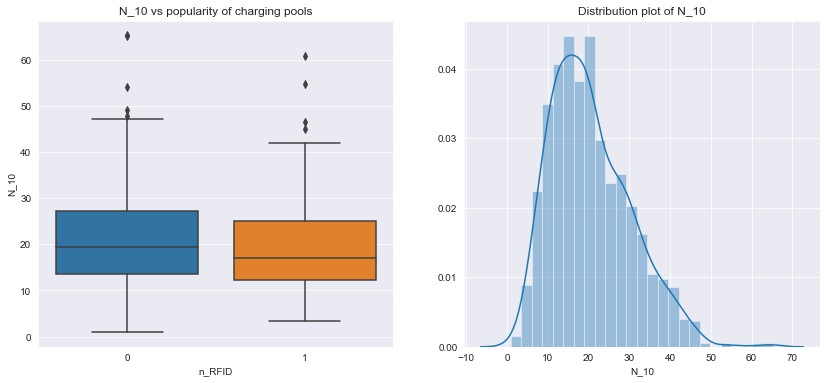

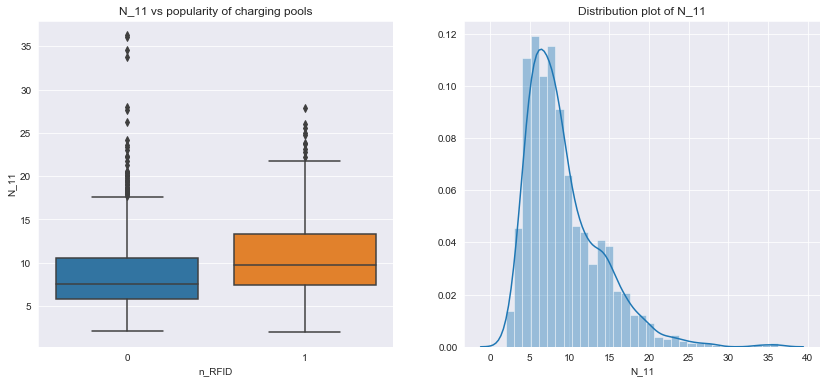

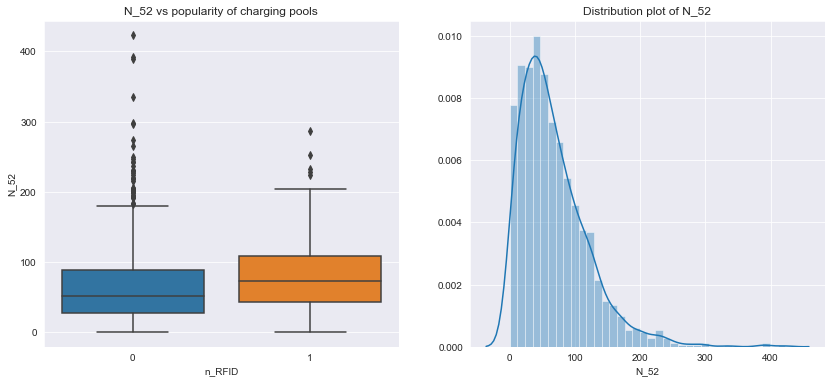

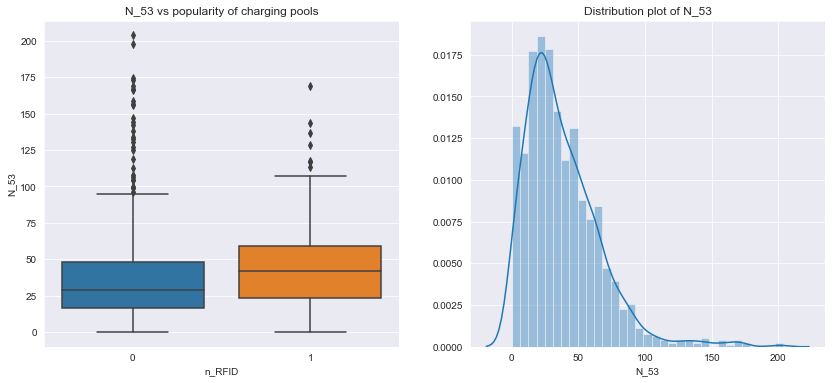

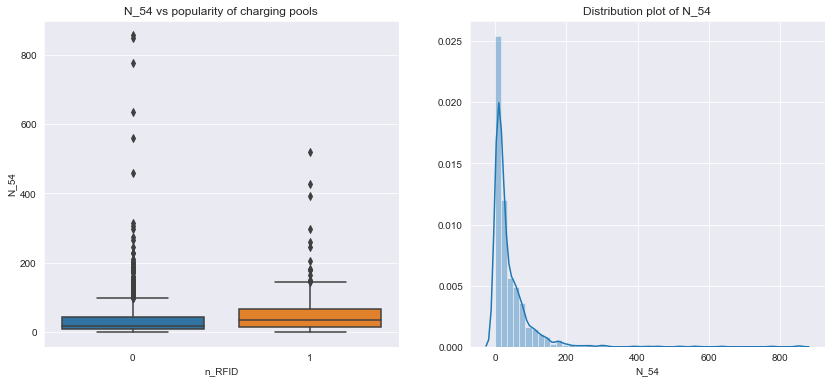

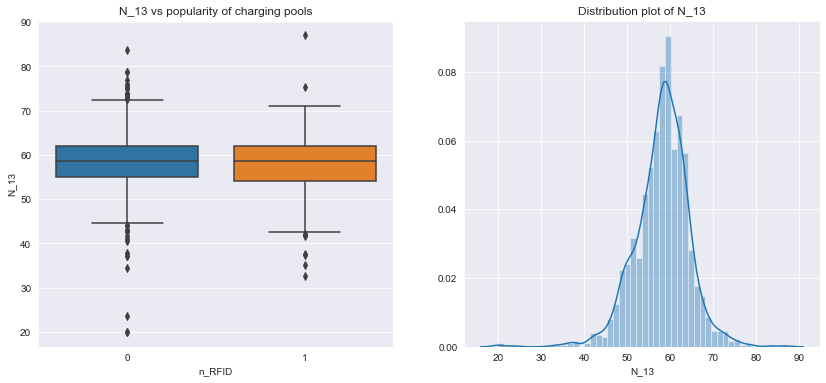

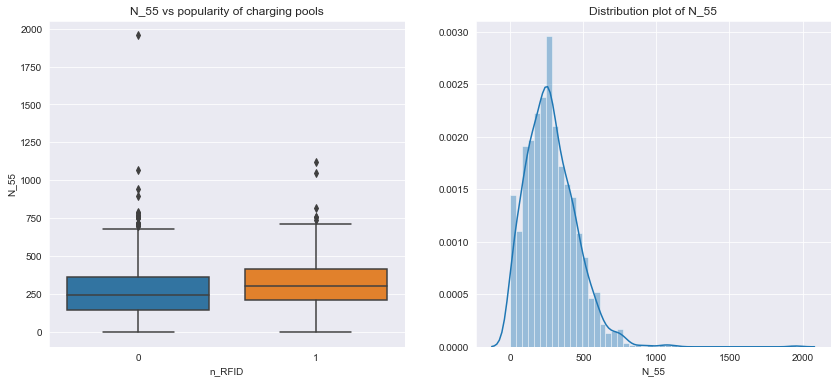

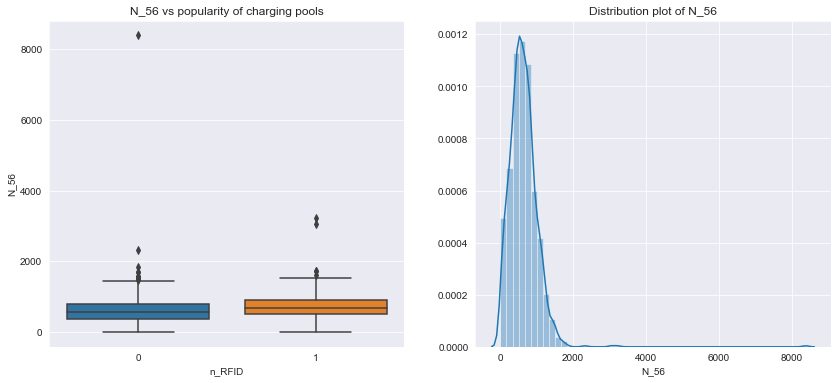

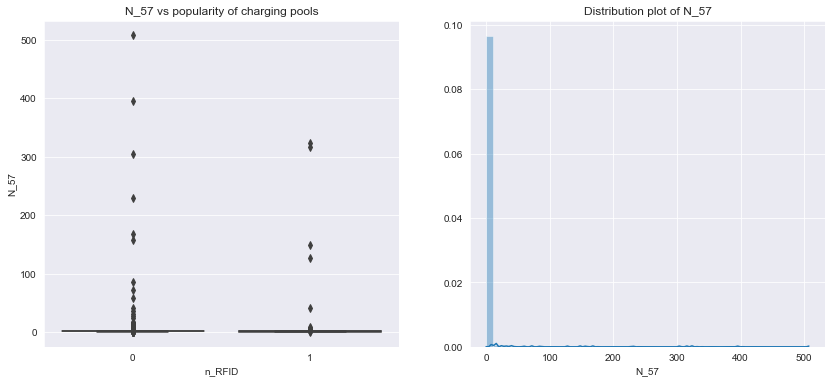

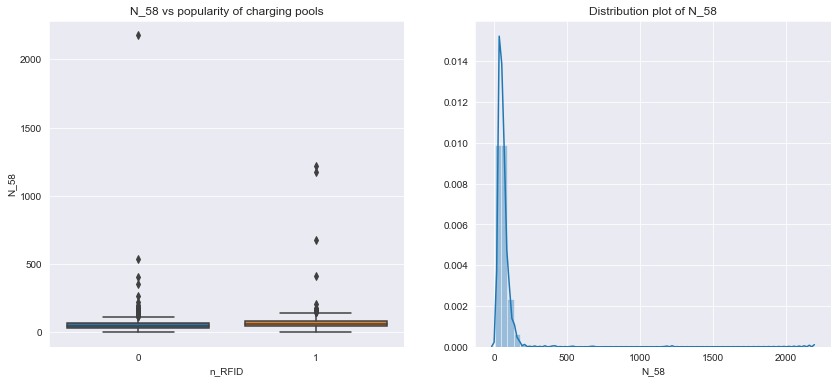

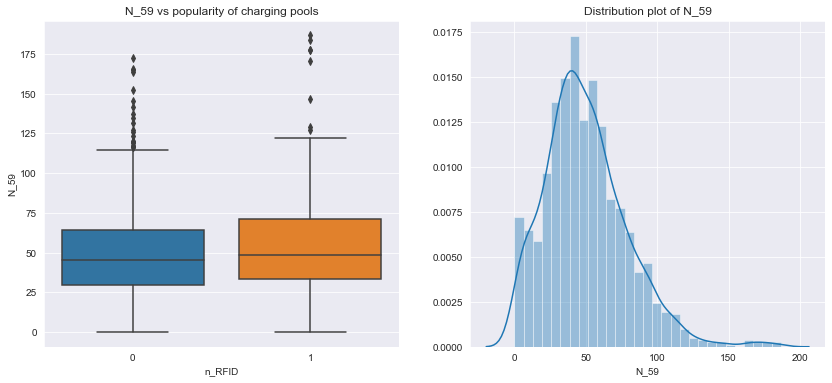

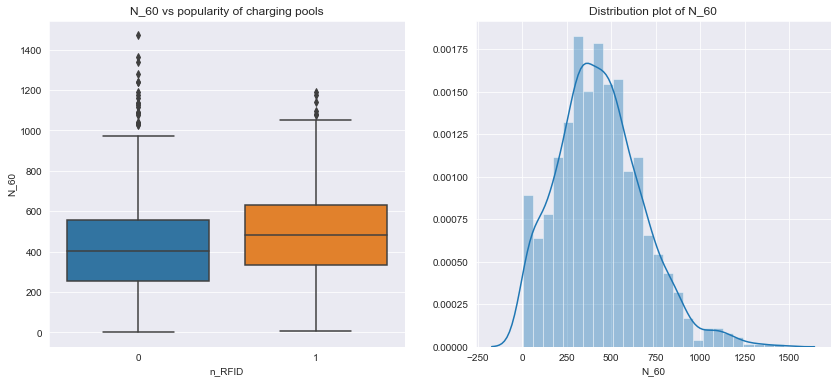

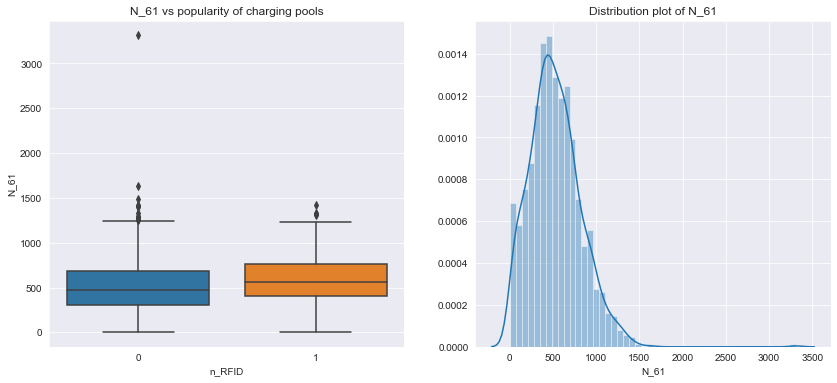

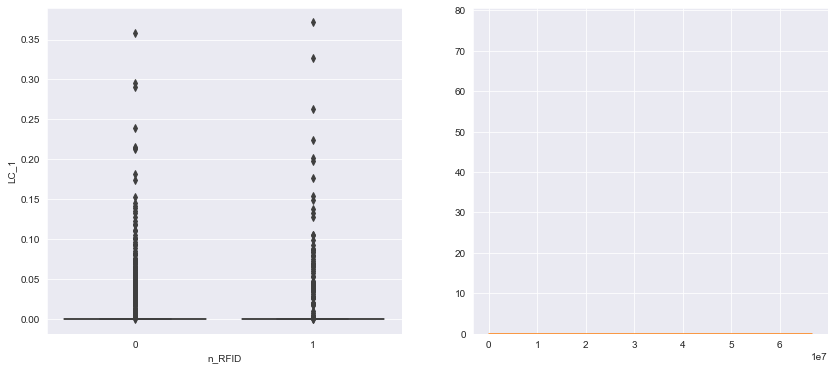

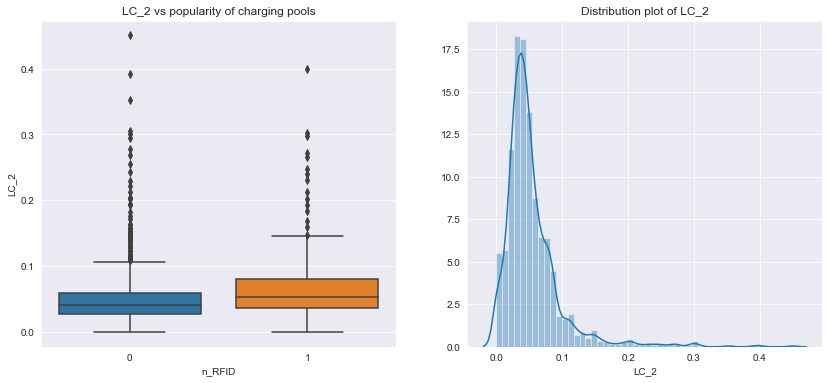

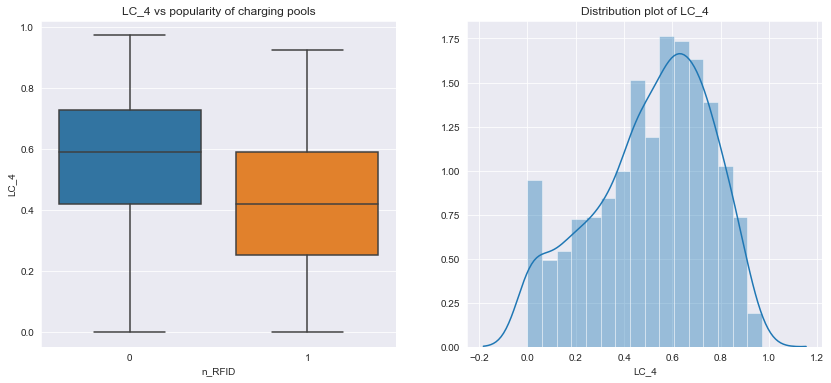

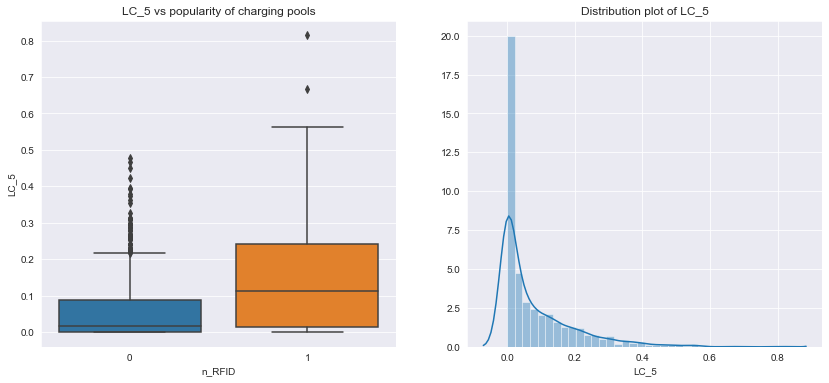

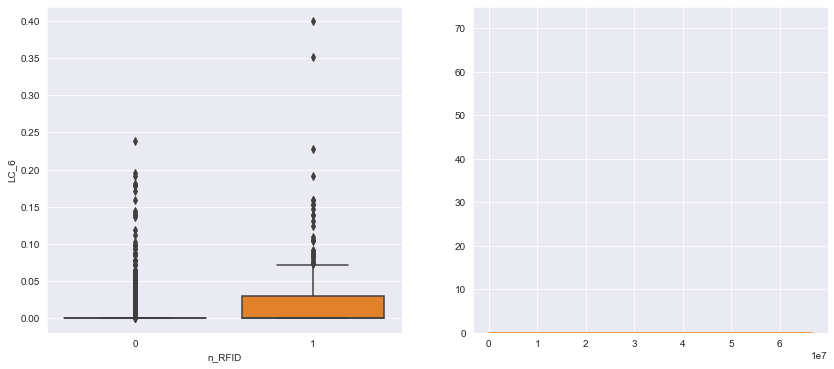

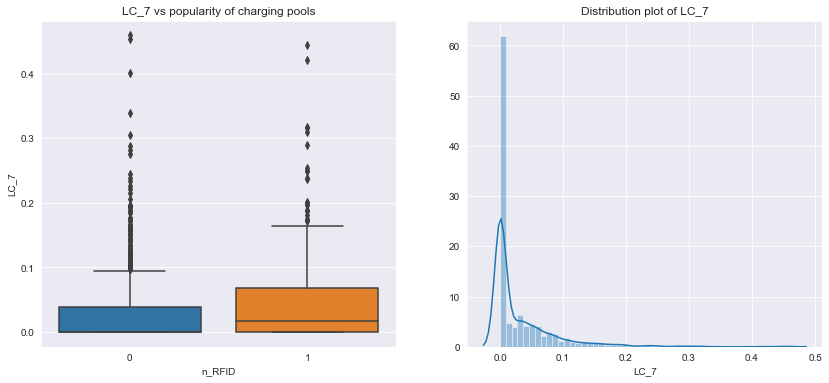

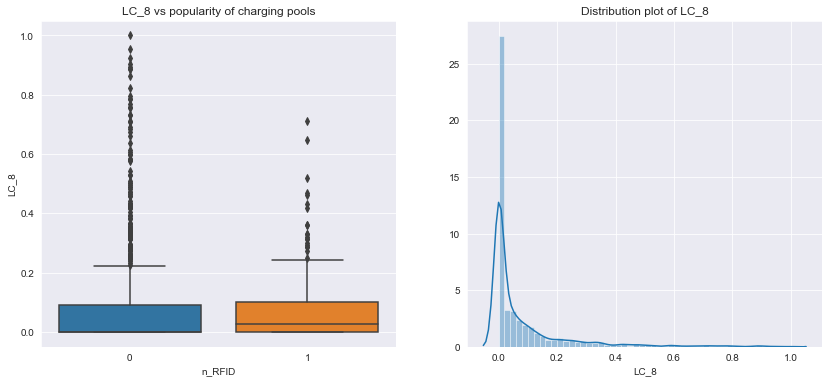

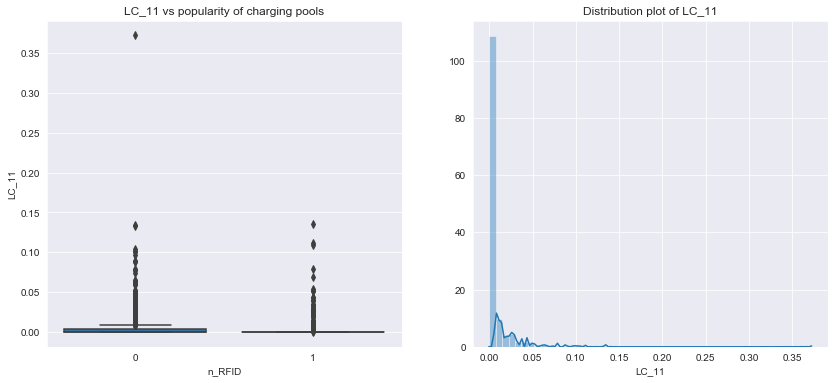

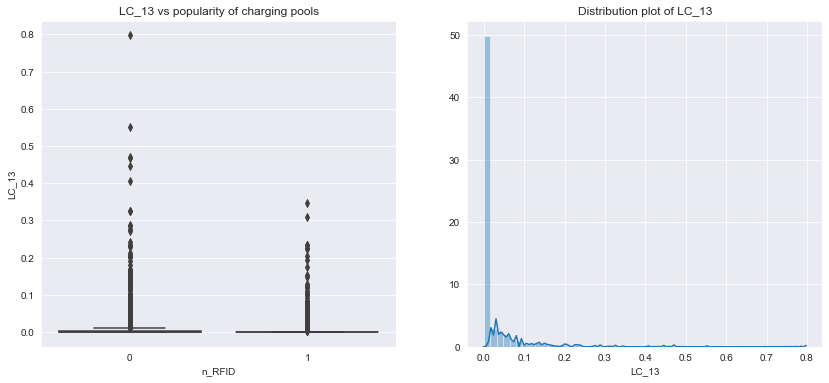

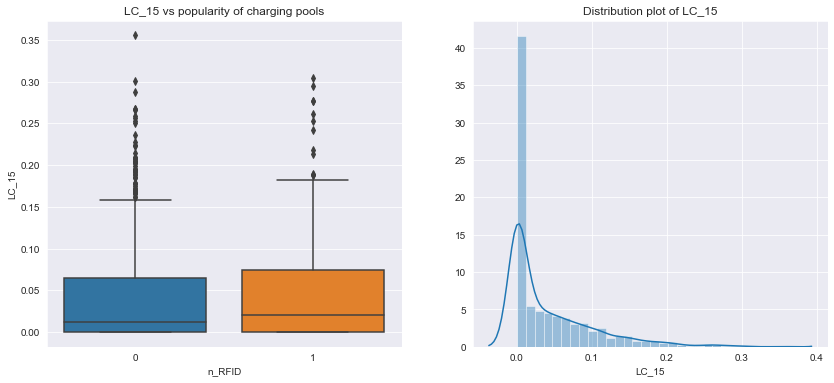

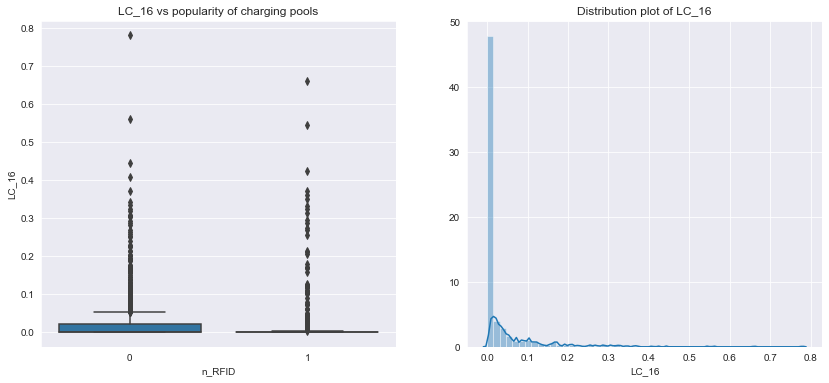

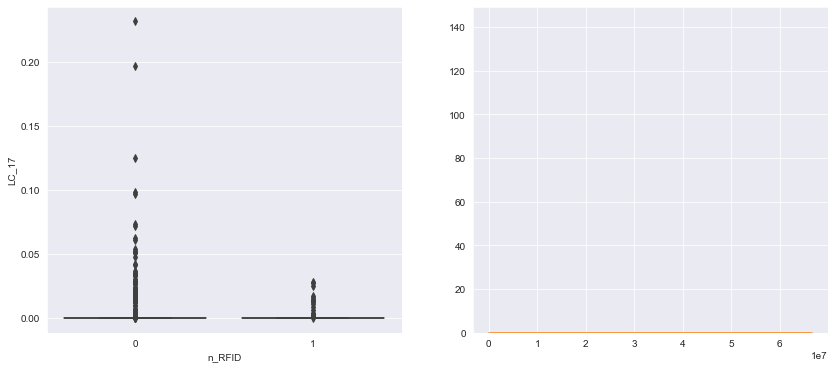

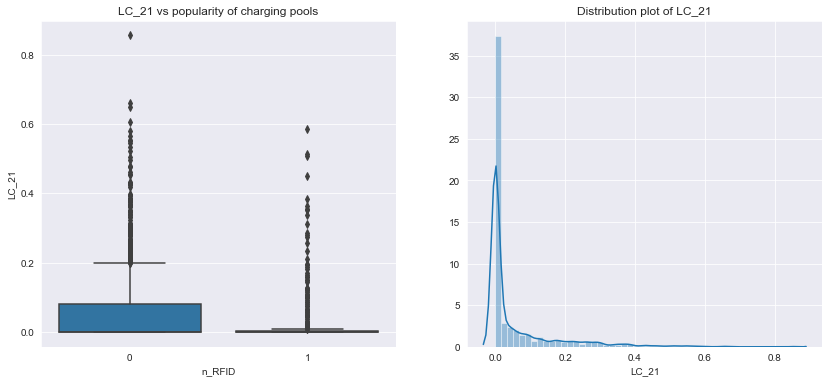

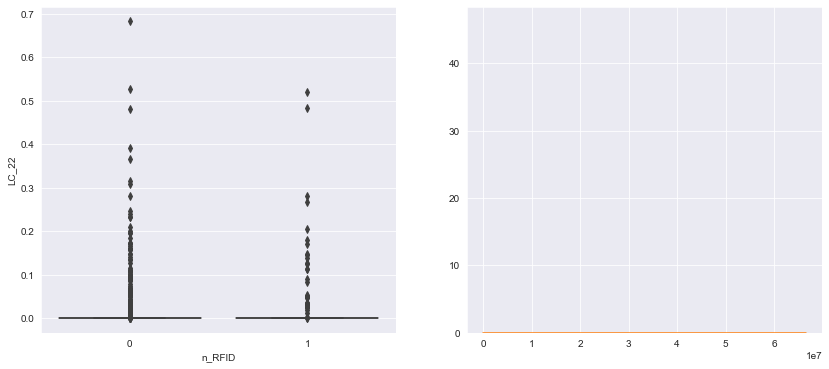

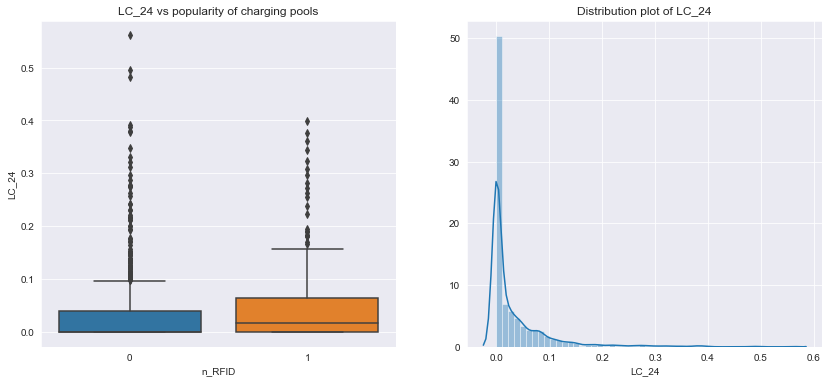

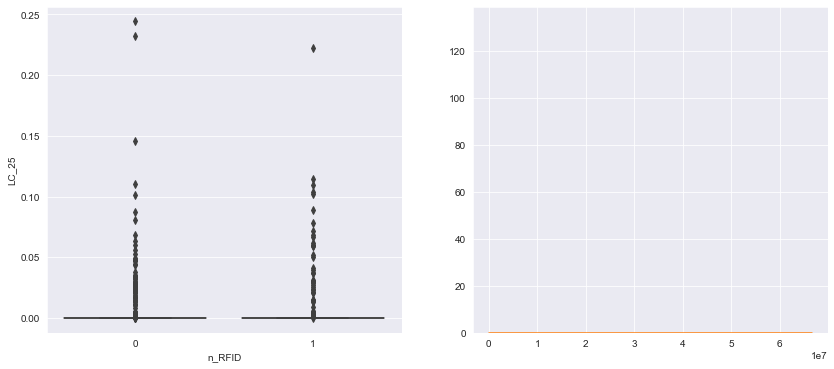

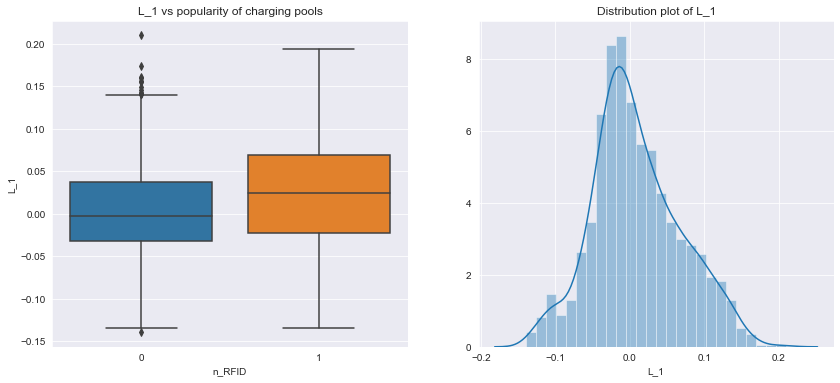

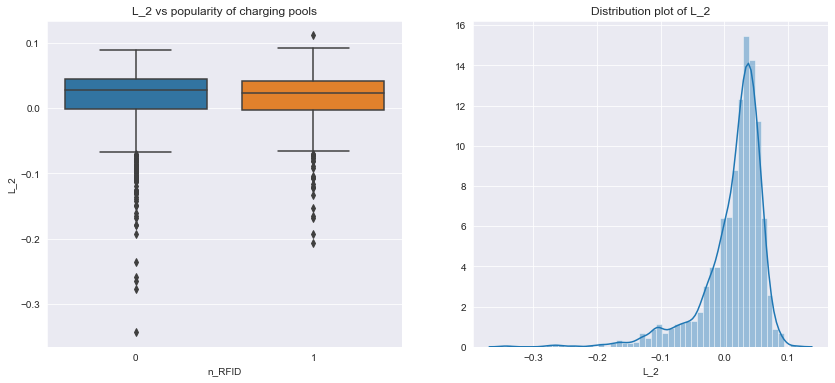

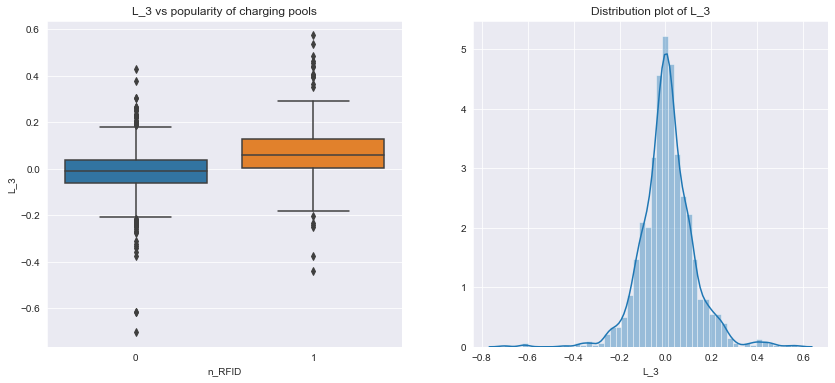

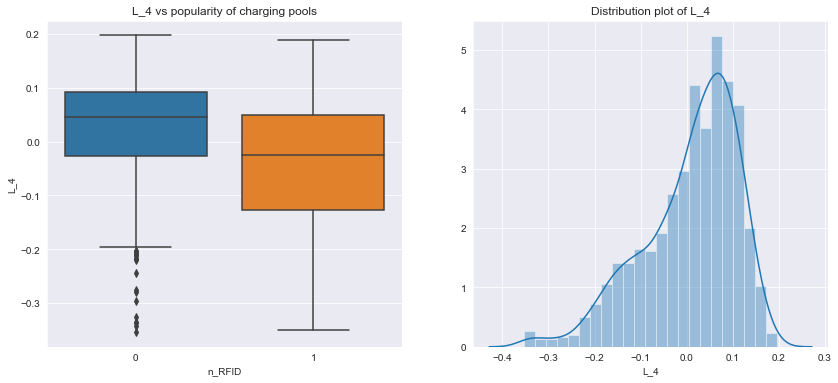

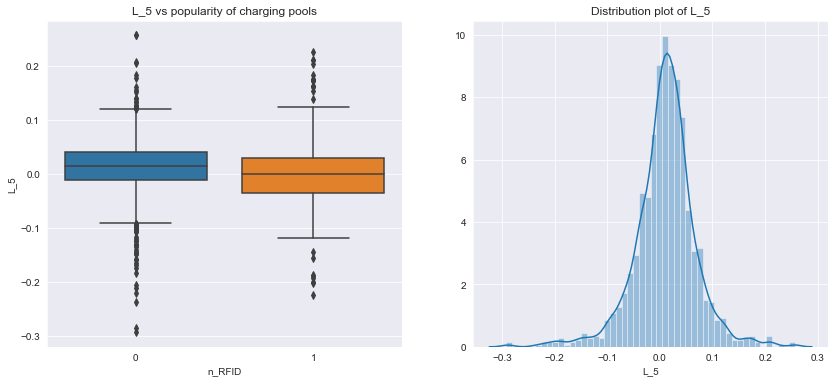

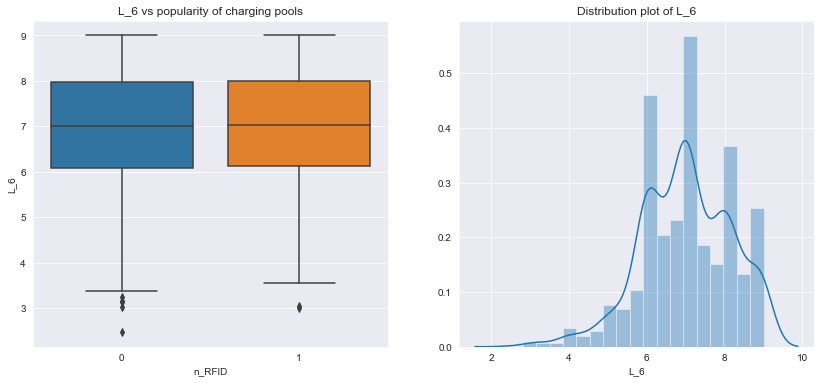

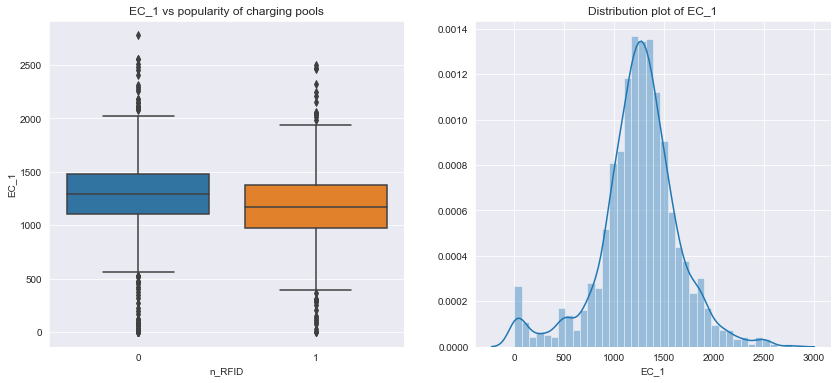

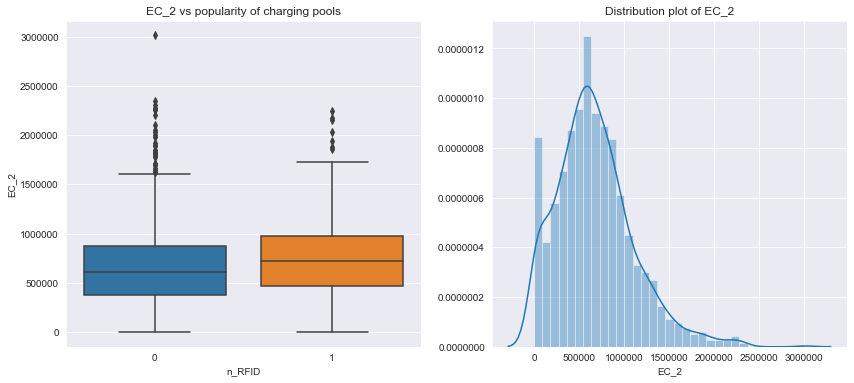

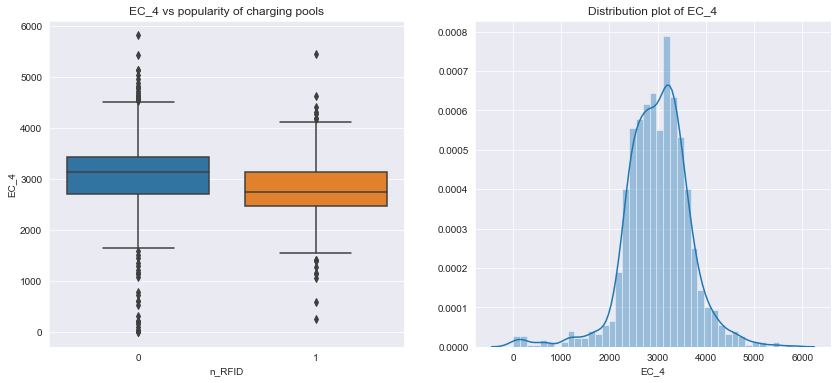

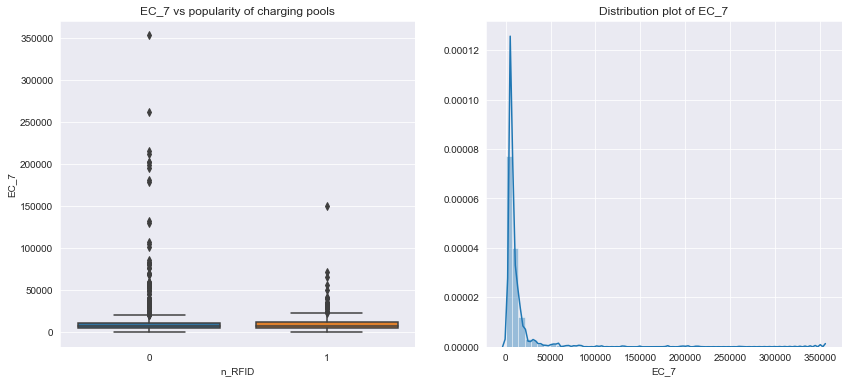

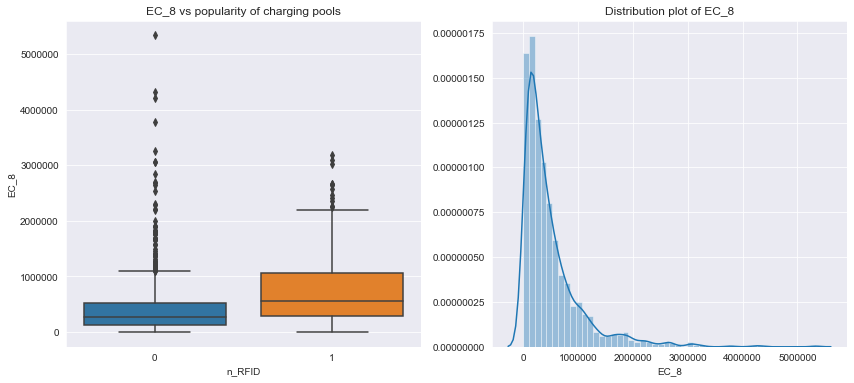

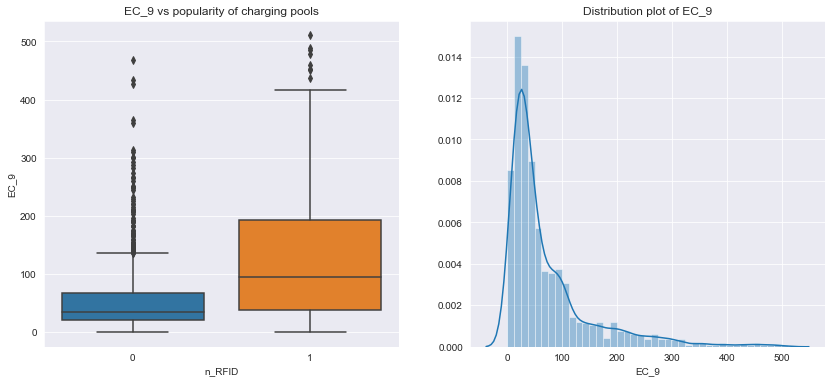

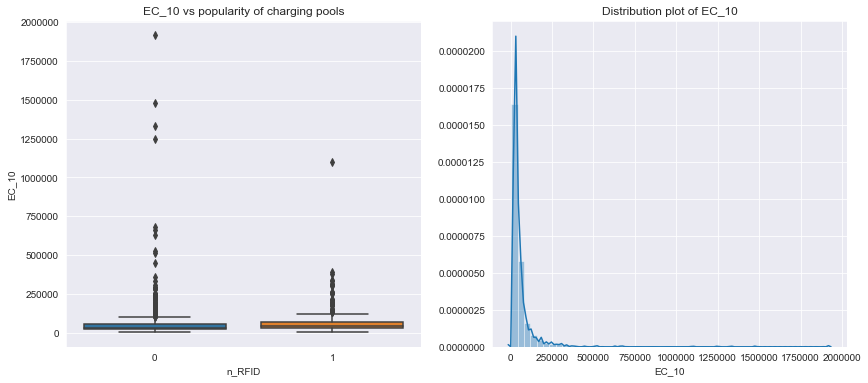

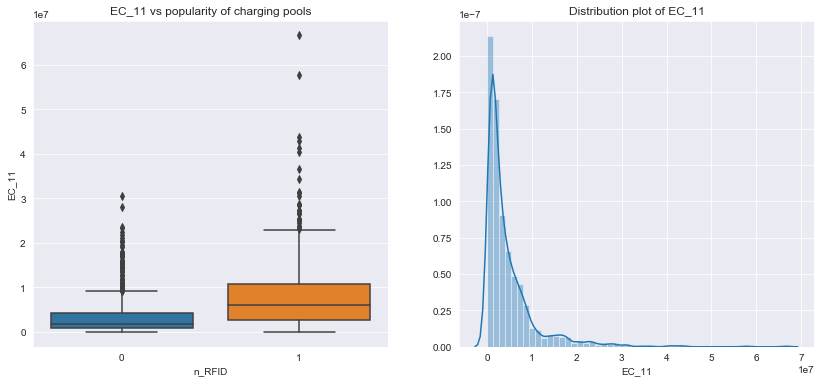

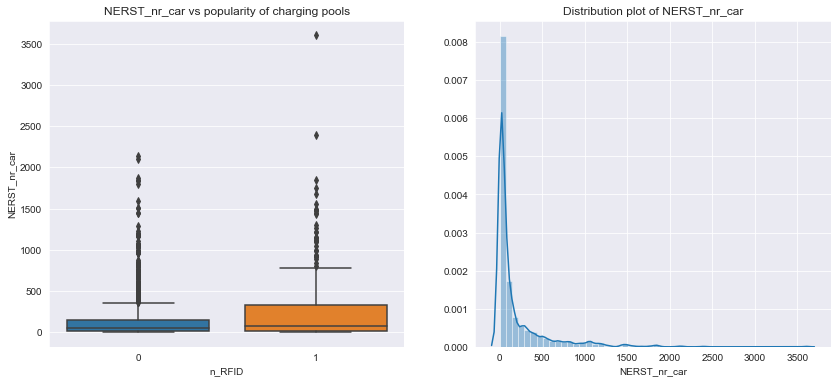

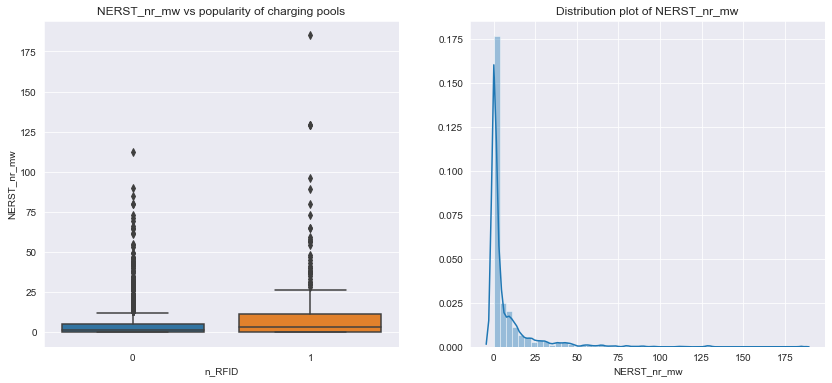

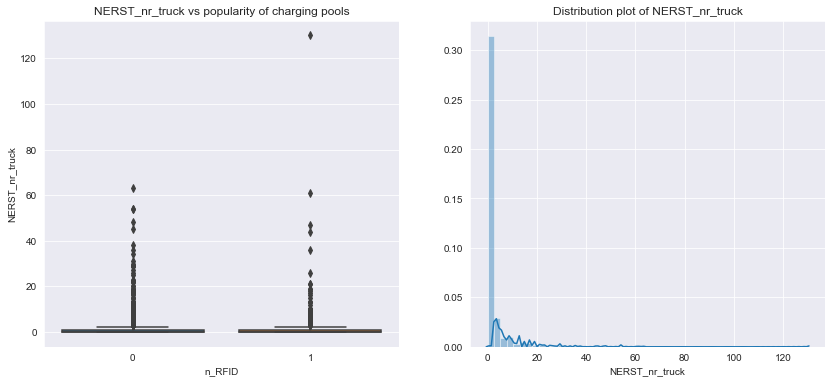

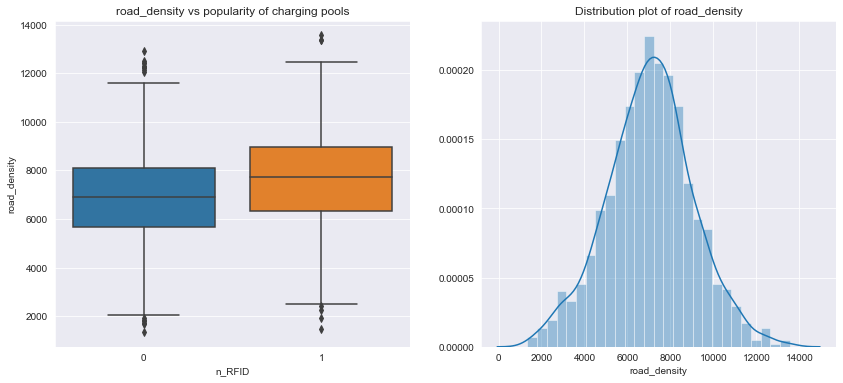

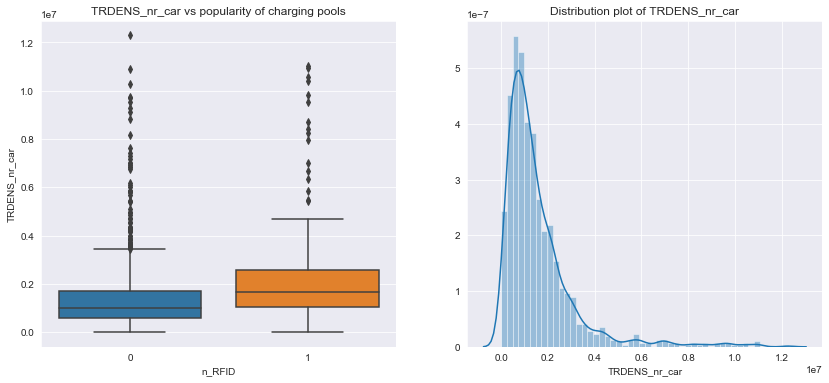

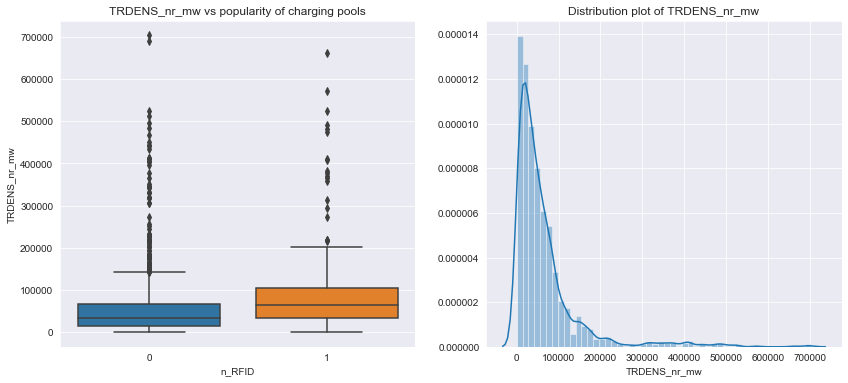

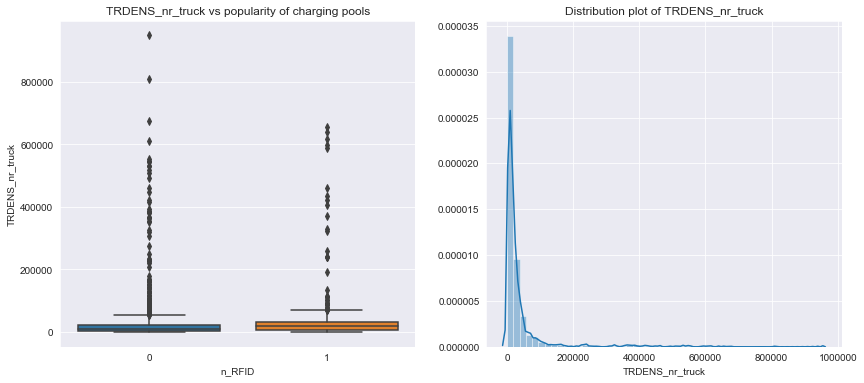

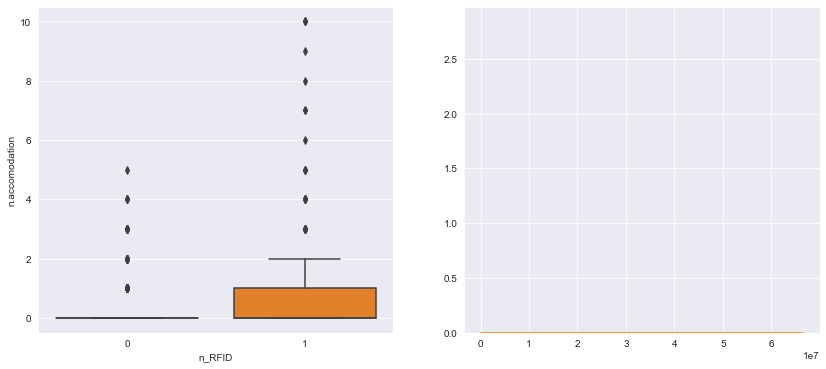

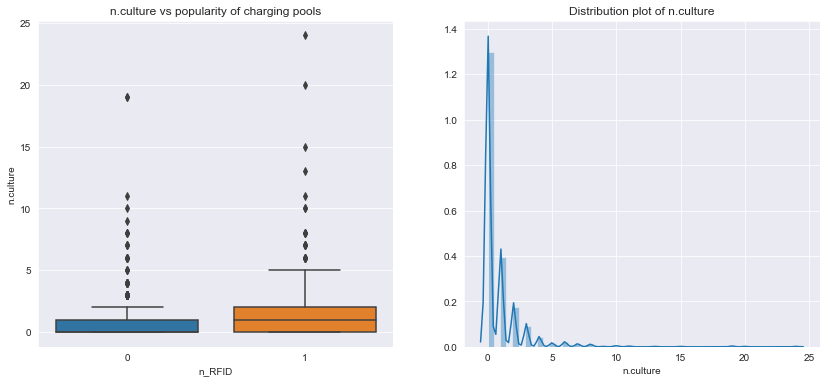

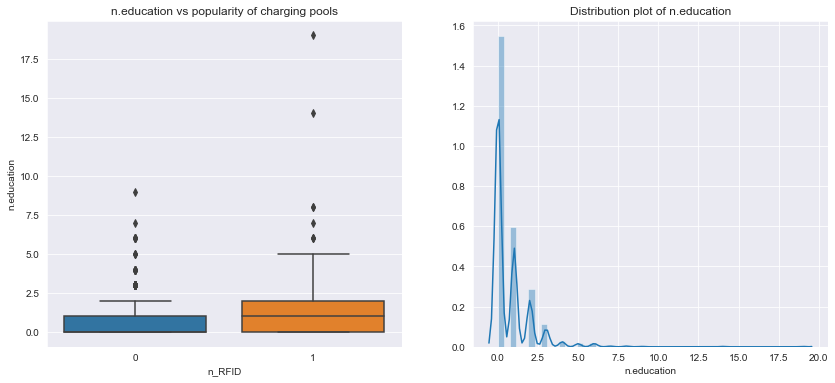

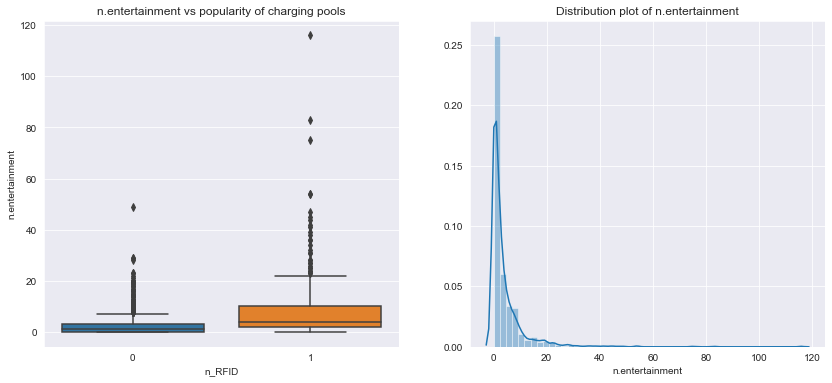

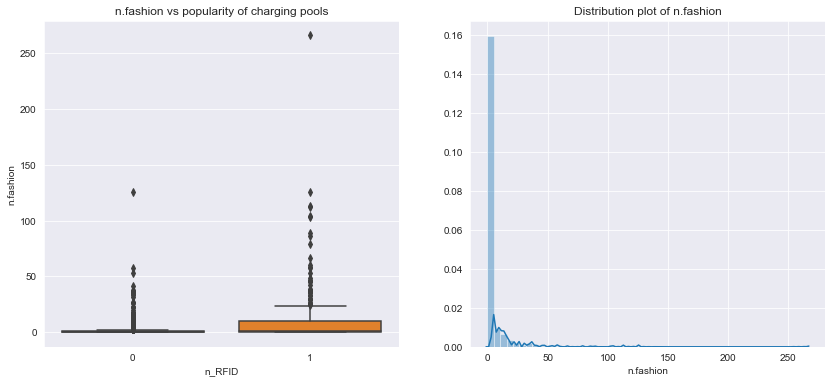

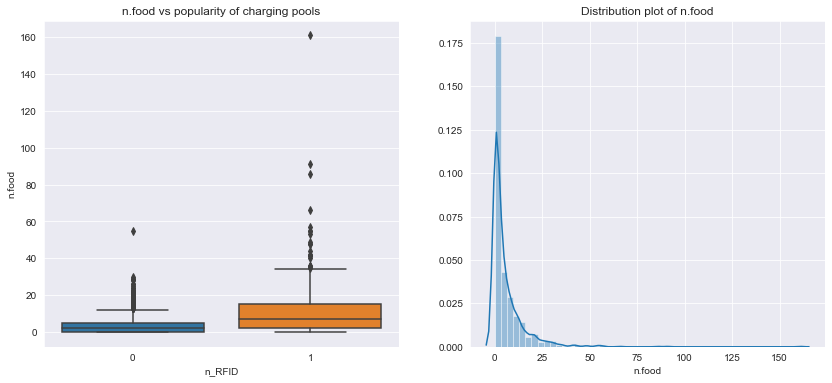

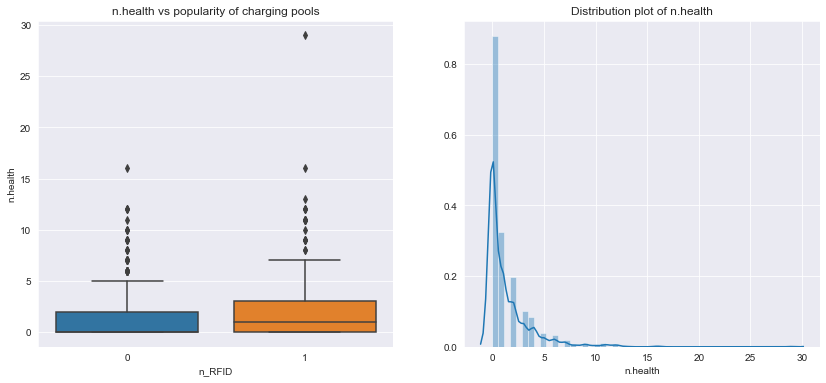

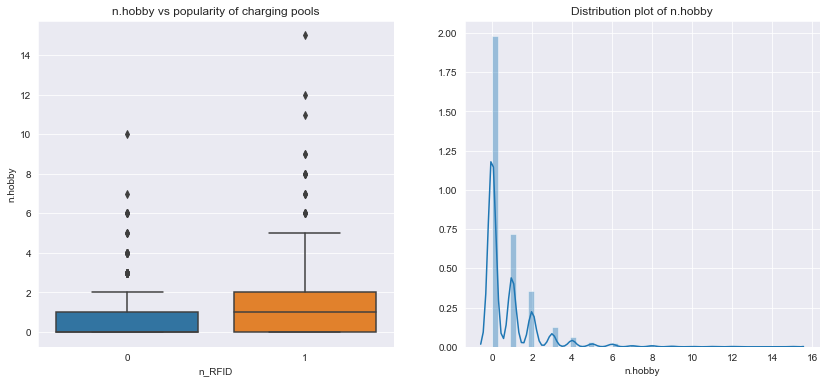

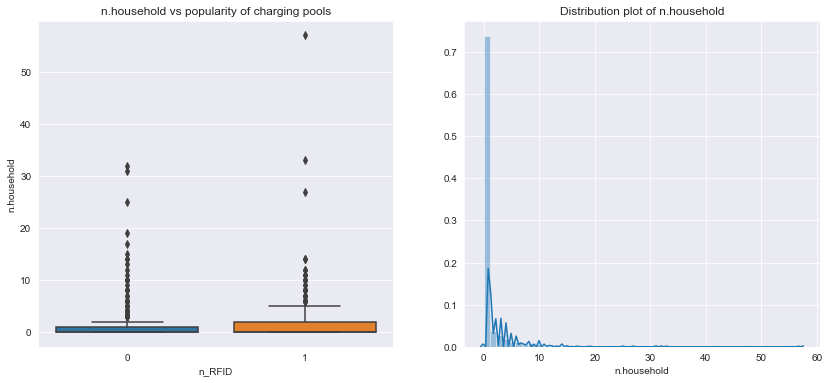

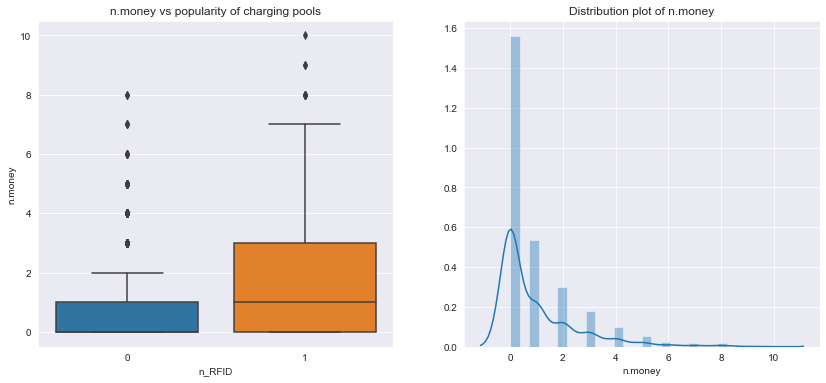

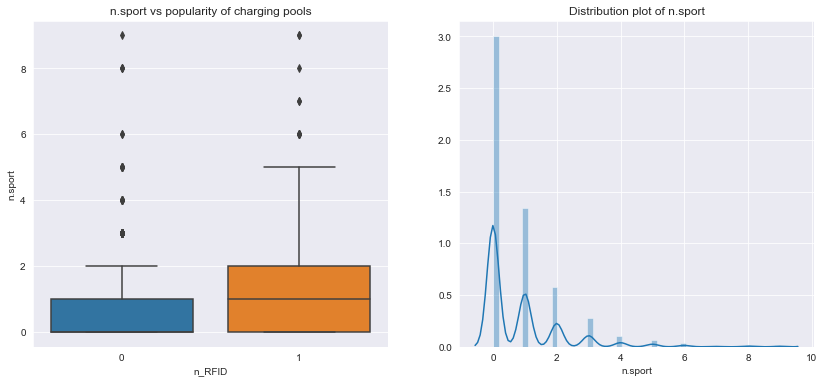

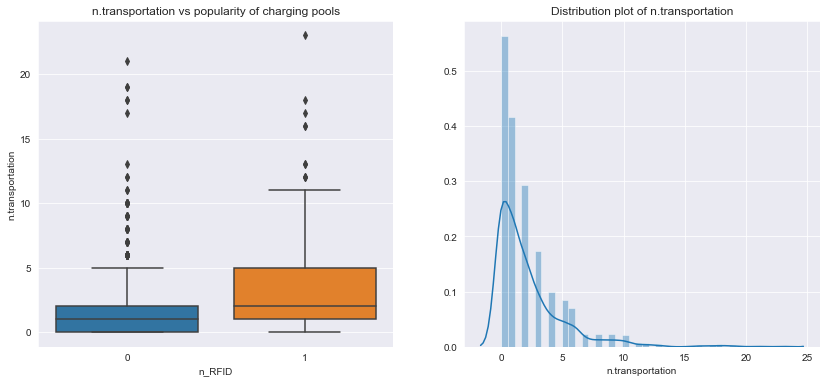

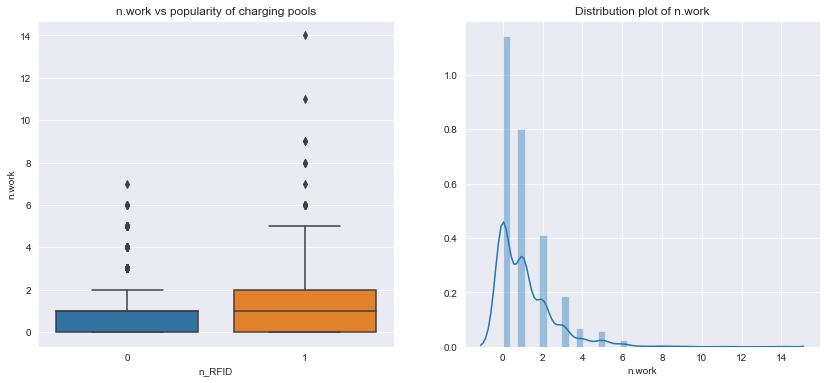

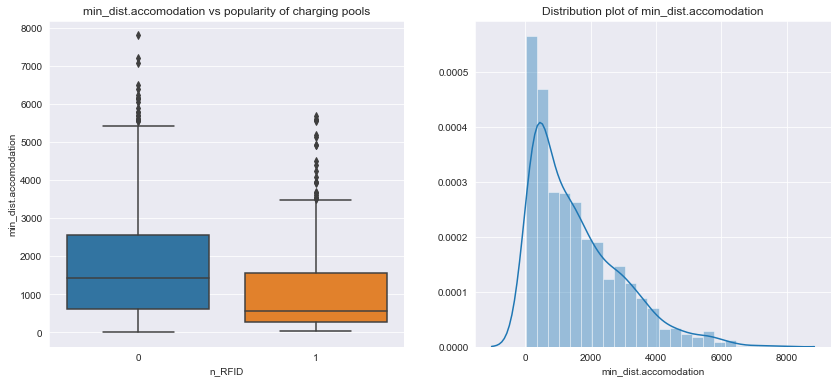

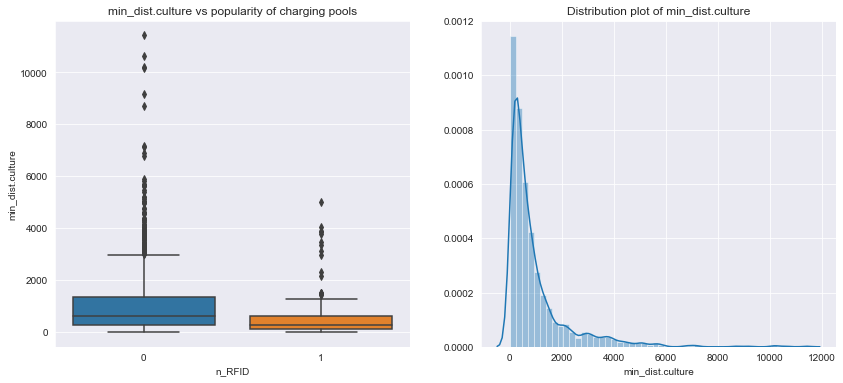

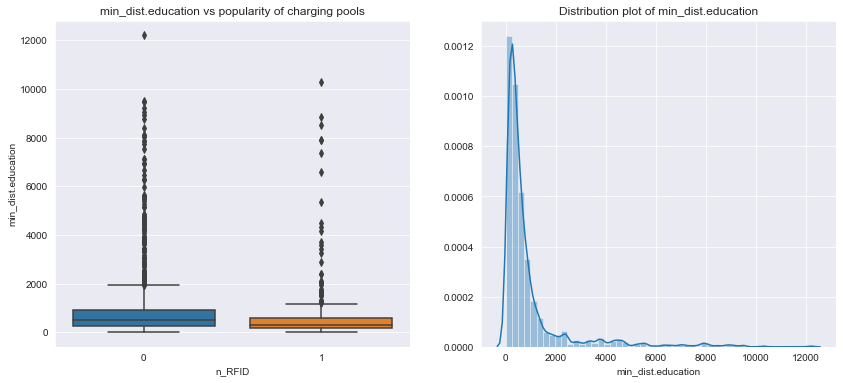

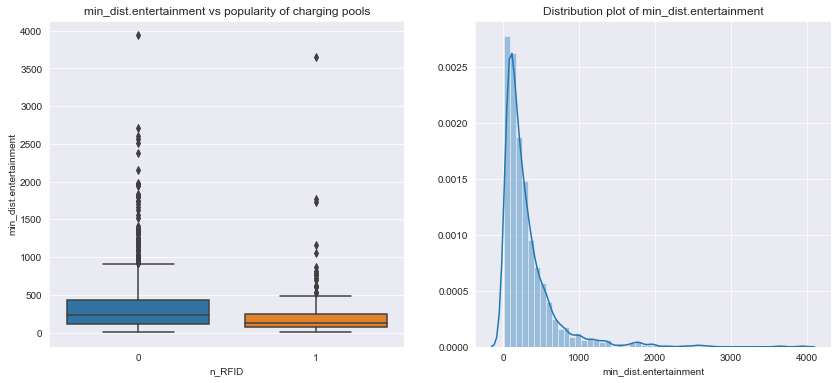

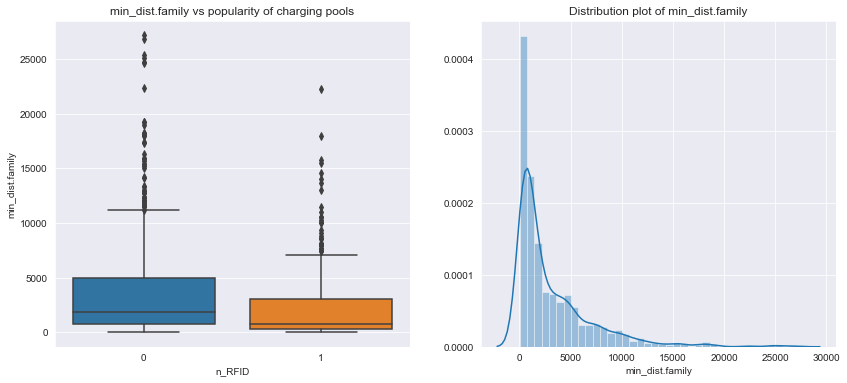

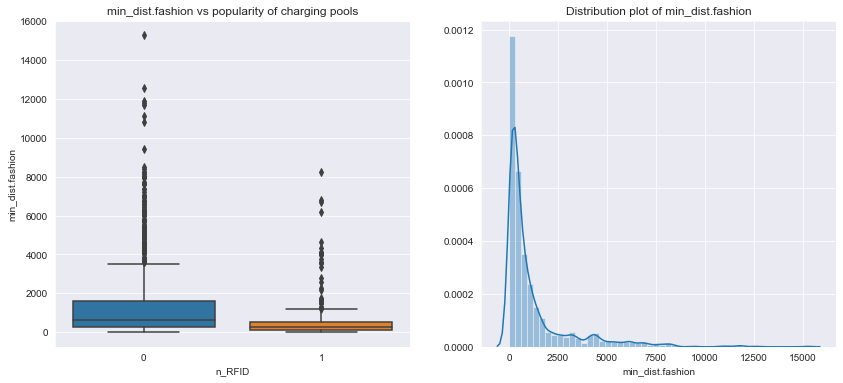

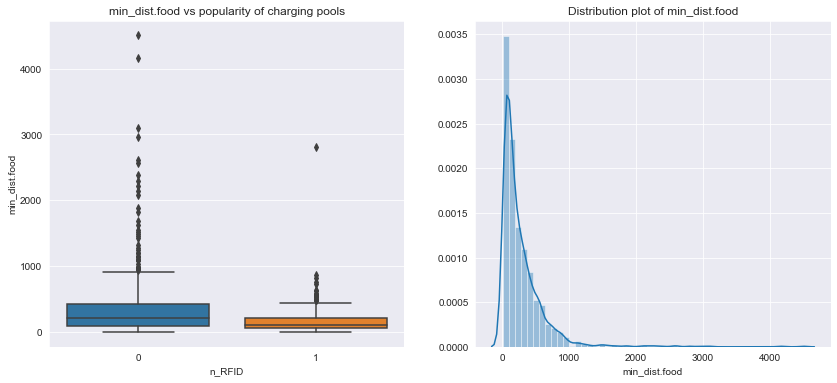

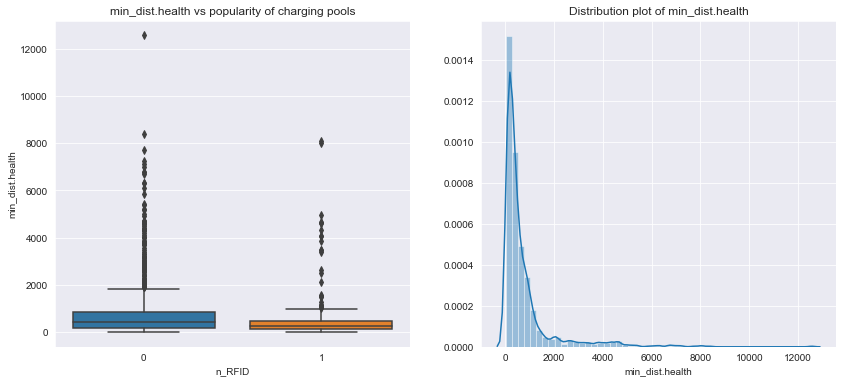

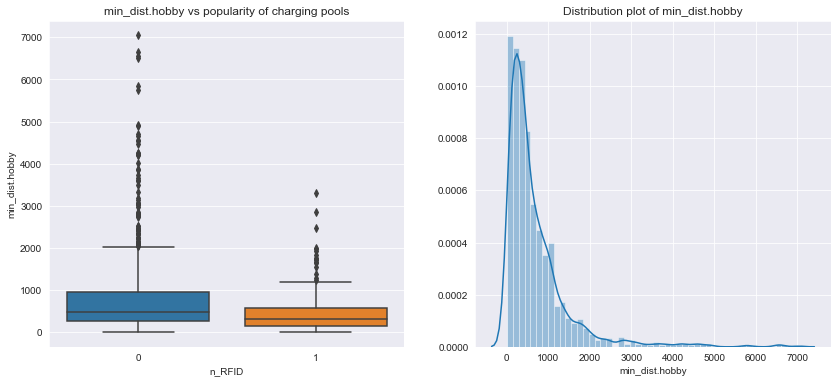

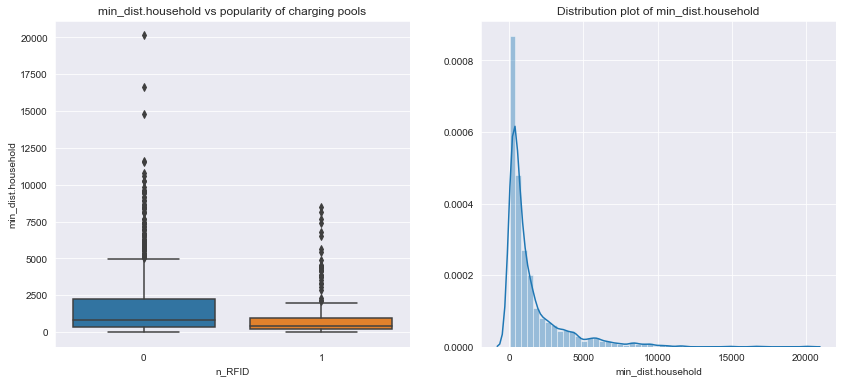

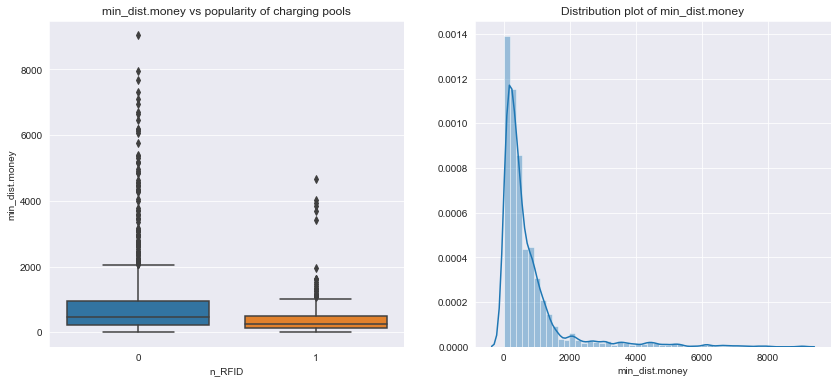

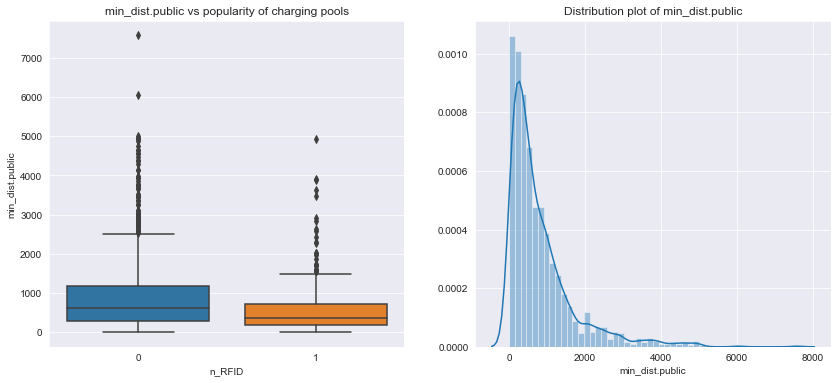

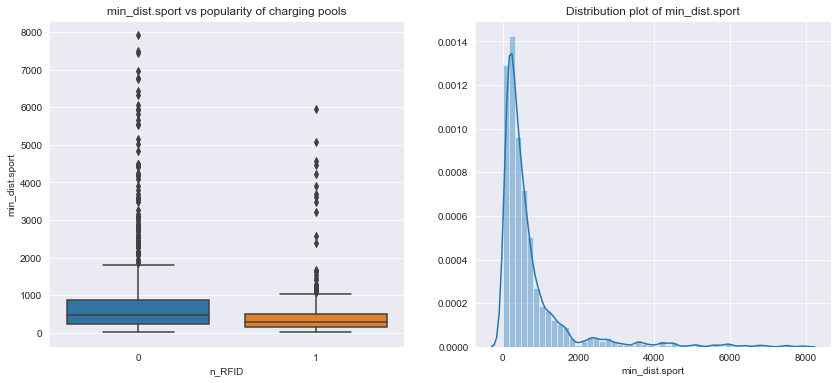

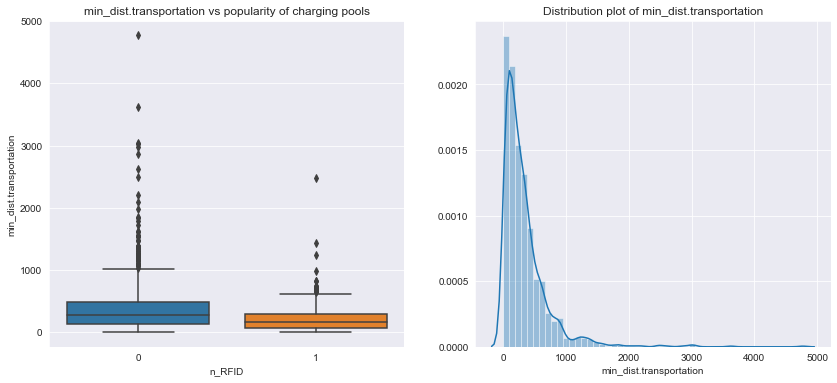

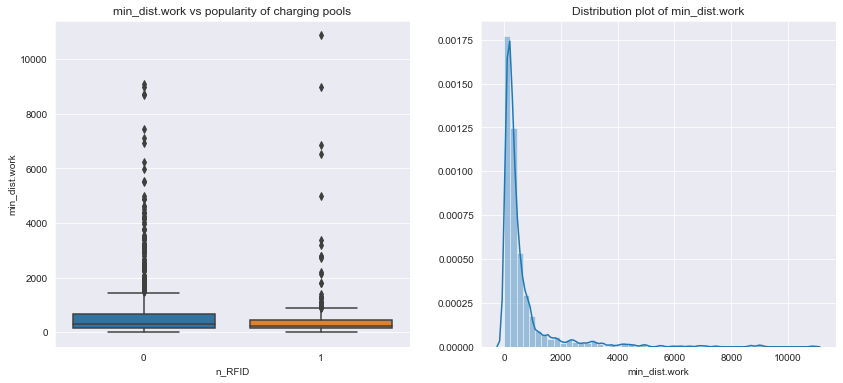

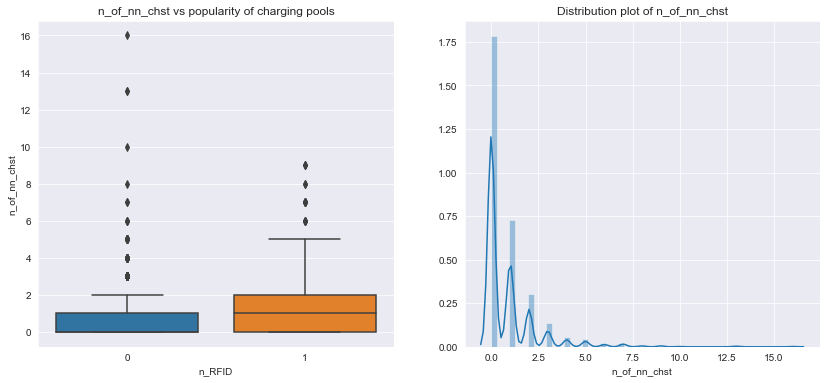

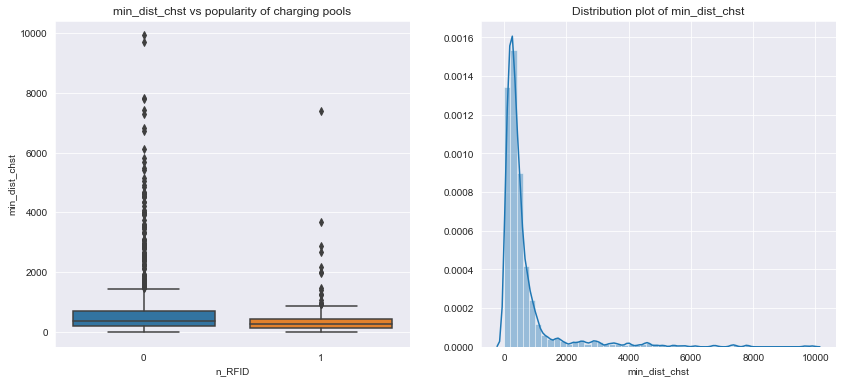

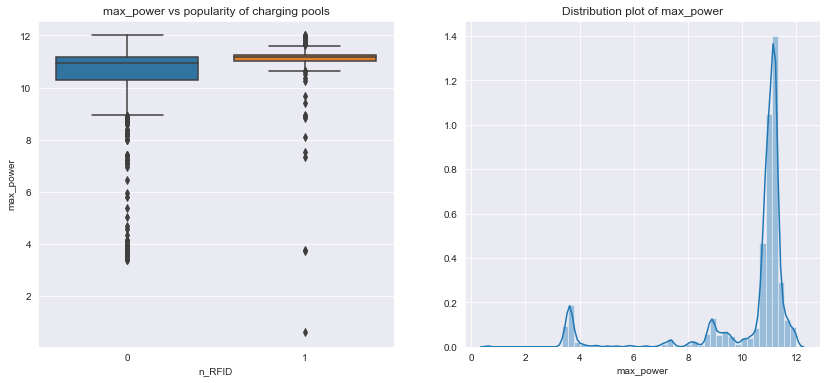

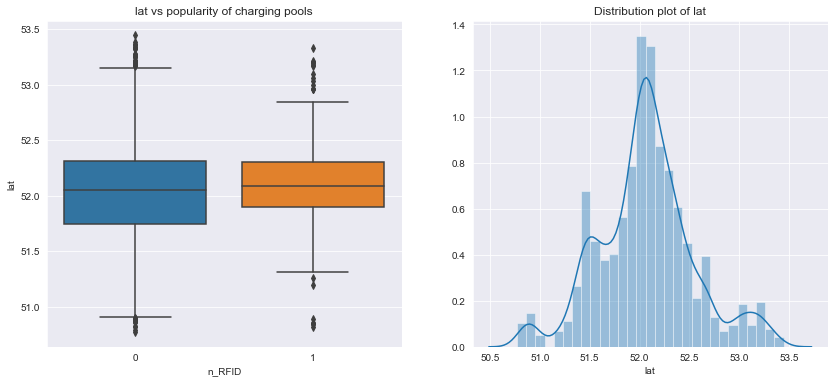

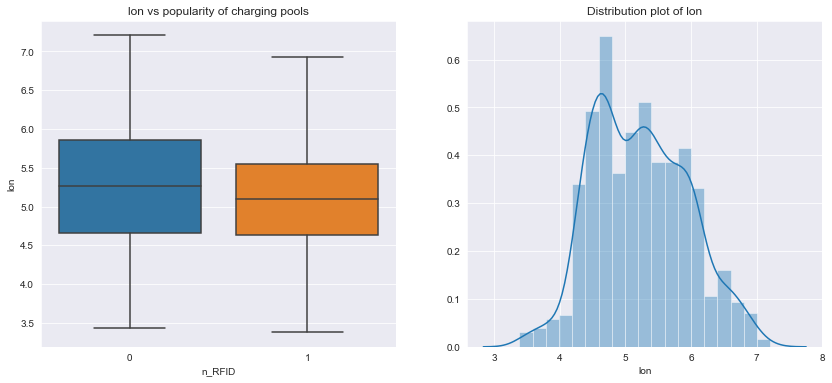

In [ ]:
# plotting univariate and bi-variate analysis graph based on the above function
for col in station_data.columns:
    if col not in ['n_RFID'] and  col not in cat_cols:
        try:
            num_plot(col)
        except RuntimeError as re:
            if str(re) == 'Selected KDE bandwidth is 0. Cannot estiamte density.':
                sns.distplot(station_data, kde_kws={'bw': 0.1})
            else:
                raise re         

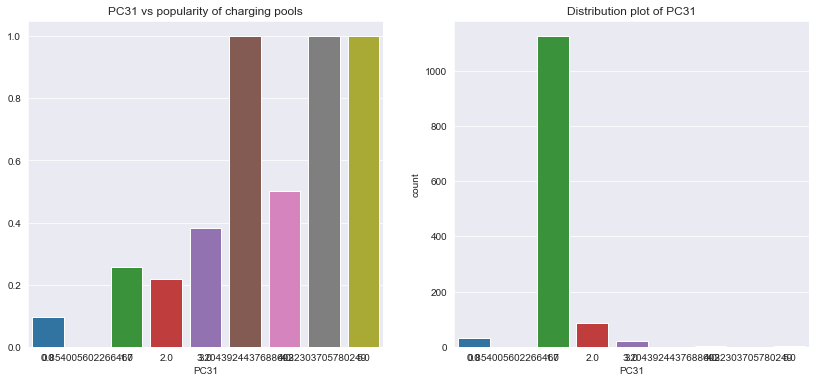

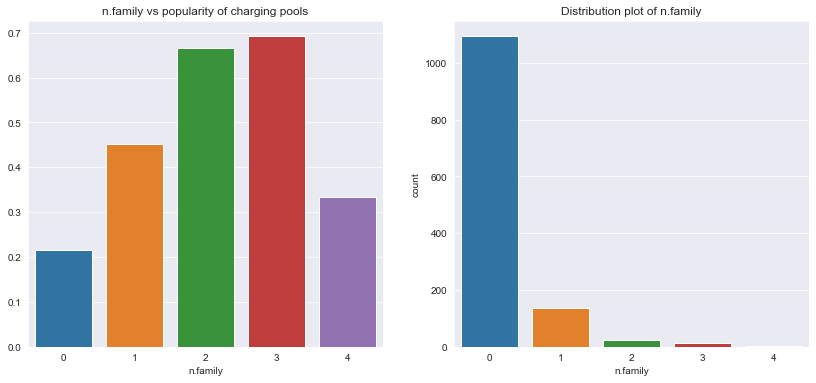

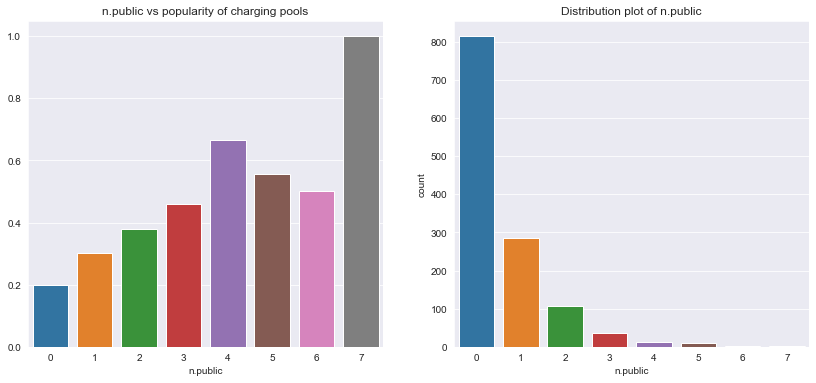

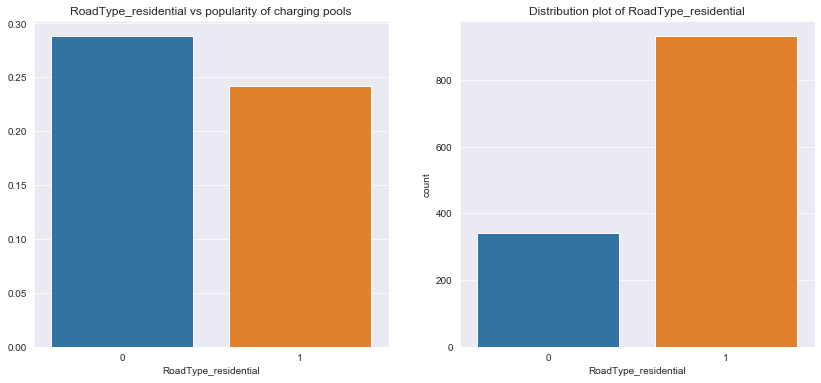

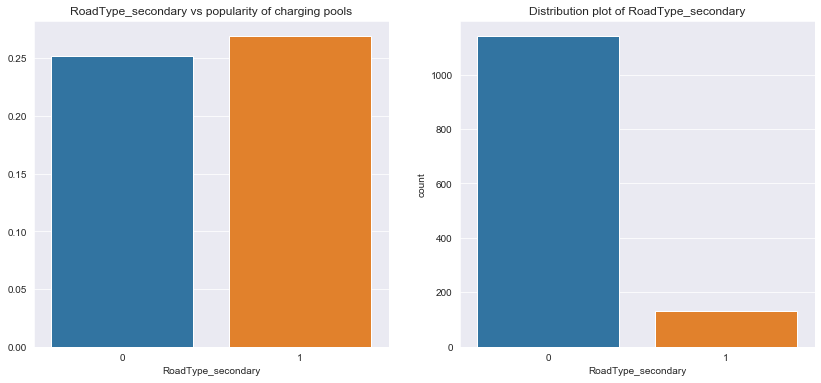

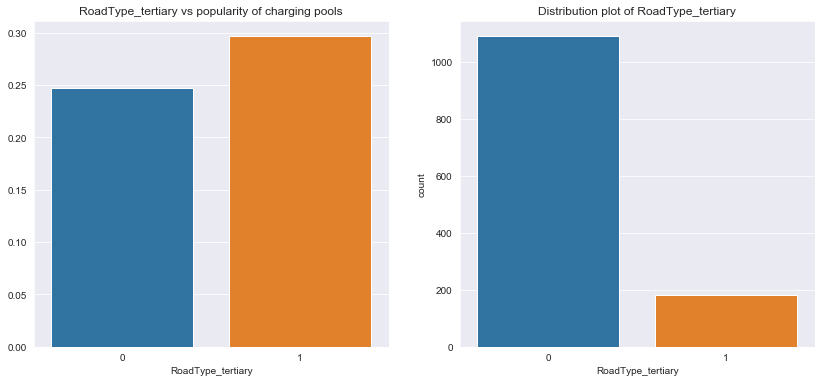

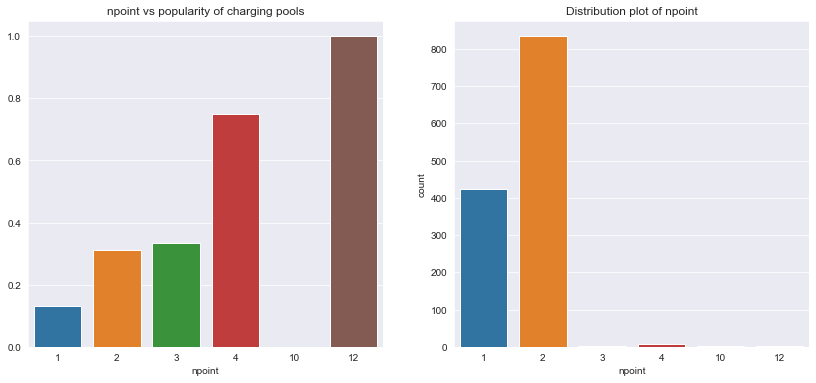

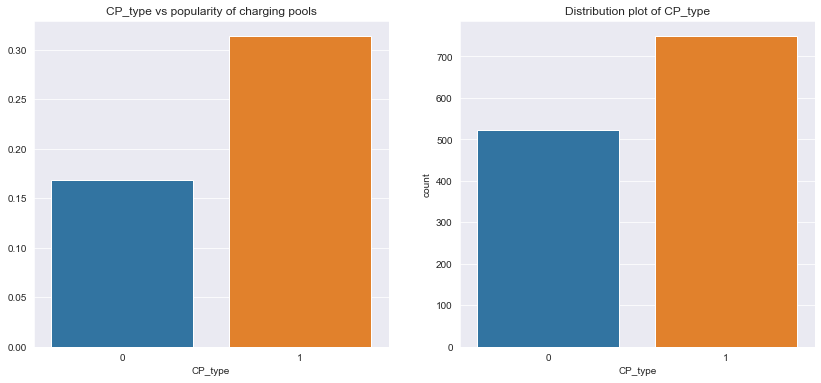

In [ ]:
# for cat_cols which is having low unique values we can use different function for plotting univariate and bivariate analysis graphs
def cat_plot(col):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))
    rev_data = station_data[['n_RFID', col]].groupby(col).mean()['n_RFID']
    sns.barplot(x= rev_data.index, y= rev_data.values, ax = ax1)
    sns.countplot(station_data[col], ax = ax2)
    ax1.set_title('{} vs popularity of charging pools'.format(col))
    ax2.set_title('Distribution plot of {}'.format(col))
    plt.close(0)
    plt.show()
    
# plotting univariate and bi-variate analysis graph based on the above function
for col in cat_cols:
    cat_plot(col)

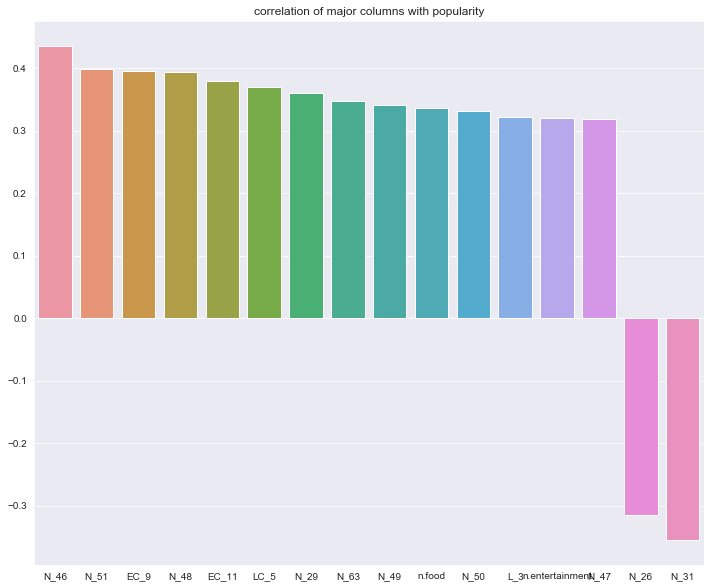

In [ ]:
# identifying columns that are highly correlated with the response variable

# using corr function to estimate and corrleation between columns and selecting correlations between `n_RFID` and other columns
# selecting 0.3 and -0.3 as thresholds on either side of zeros as minimum correlation required
station_corr = station_data.corr()['n_RFID'][(station_data.corr()['n_RFID'] > 0.3) | (station_data.corr()['n_RFID'] < -0.3)].sort_values(ascending = False)

# ignoring first row since its corellation with 'n_RFID' itself
station_corr = station_corr[1:]
plt.figure(figsize = (12,10))
sns.barplot( x = station_corr.index, y = station_corr.values)
plt.title('correlation of major columns with popularity')
plt.show()

### Data Preparation for the Model - Train test split, Outlier Treatment

In [ ]:
# Train and test split of the data
evci_train, evci_test = train_test_split(station_data, test_size = 0.2, random_state = 0, stratify = station_data['n_RFID'])

In [ ]:
# scaling the data
scaled_cols = evci_train.columns.to_list()
scaled_cols.remove('n_RFID')

scaler = StandardScaler()

# fitting and transforming train data
evci_train[scaled_cols] = scaler.fit_transform(evci_train[scaled_cols])

# transforming the test data
evci_test[scaled_cols] = scaler.transform(evci_test[scaled_cols])

C:\Users\raviprasad\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\raviprasad\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\raviprasad\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [ ]:
print(evci_train.shape)
evci_train.head()

(1016, 173)


n_RFID      LS_1       PC2       PC4       PC5       PC6       PC7  \
1262       0 -0.376875 -0.434262 -0.733065 -1.027260 -1.215038 -0.978980   
13         0  0.346231 -0.827311  1.147768  2.490096  2.728308  1.340875   
451        1  2.493564 -0.434262  0.708571  1.472991  1.642536  1.516160   
213        1 -1.333306 -0.041213 -0.139675 -0.386104 -0.811294 -0.997883   
921        0  0.292738 -0.434262  1.072062  0.741784  0.625757  0.671227   

          PC13      PC14      PC17       PC8       PC9      PC10      PC11  \
1262 -0.453521 -0.459945 -1.022952 -0.348182 -0.955437 -1.067853 -0.761427   
13    0.914969  0.608591  1.434642  1.449416  1.701539  2.139729  0.193386   
451   0.915795  1.028120  1.386009  2.025219  1.786051  1.201272  0.731935   
213  -1.323397 -1.350550 -1.072245 -0.805541 -0.576453 -0.635939 -1.519862   
921   0.825040  1.036845  0.675418  0.211673  0.566650  0.759986  0.814770   

          PC12      PC18      PC22      PC24      PC25      PC26      PC27  \
1262 -0.761935 -1.314335 -1.067746 -0.729443 -0.589163 -1.091799 -0.838296   
13   -0.064525  1.159011  2.223665  0.284614  0.182361  1.962437  2.421862   
451   0.549572  0.752266  2.309080  0.378128  0.179609  0.915217  2.550026   
213  -1.291135 -1.130948 -0.875473 -0.835906 -1.501298 -0.579037 -0.404439   
921   0.816954  0.476718  0.312447  1.283588  1.234851  0.788347  0.080222   

          PC28      PC29      PC30      PC31      PC32      PC33      PC34  \
1262 -0.494664 -0.083954  0.477949 -0.217521  1.077365  0.471656 -1.164613   
13    1.641925 -1.134829 -1.134013 -0.217521 -0.512201 -1.572024  1.122079   
451   1.059219 -1.134829 -0.731022 -0.217521 -0.512201 -0.643078  0.868003   
213   1.059219 -0.609391 -0.731022 -0.217521 -0.512201  0.471656  0.105772   
921   0.088042 -0.346673  0.074959 -0.217521  0.282582 -0.643078 -0.910536   

          PC35      PC36      PC37      PC38      PC39      PC40      PC41  \
1262  0.683494 -0.697807  0.299874 -0.368939 -1.061176 -0.877638 -0.611911   
13   -0.312337  1.770543 -0.633591  1.360551  1.195655  1.185450  0.297275   
451  -0.113171  0.227825 -0.898734  0.285017  1.277983  1.314188  0.313945   
213  -0.710669  0.536368 -0.109961  0.120097 -1.265981 -1.230259 -1.340518   
921   1.280992  0.227825 -0.781189  0.614512  0.848564  0.709720  0.831727   

          PC42      PC43      PC44       PC3      N_14      N_15       N_3  \
1262 -0.101369  0.782613  0.162315 -0.106579 -0.441860 -0.818817  1.063137   
13    0.311186  1.072135 -0.538755 -0.099055 -0.441860 -0.274537  0.296562   
451   0.462885  1.320011 -0.540741 -0.106579  2.842768  4.066697 -1.403041   
213  -1.383138 -1.036745 -0.535100 -0.106579 -0.441860 -0.548972  0.358617   
921   1.233370  0.995932 -0.499276 -0.101049 -0.438342 -0.311962  0.043695   

          N_16      N_18      N_19      N_20      N_21      N_25      N_26  \
1262 -0.659484 -0.011835 -0.469936  0.107061 -0.248029 -0.666275  1.175575   
13   -0.429647 -0.213905 -0.908903  0.729981  0.137992 -0.151302  0.251552   
451   4.459411  1.276537  1.305388 -1.011122 -1.535925  1.856617 -1.726546   
213  -1.448596  0.162656 -0.999083 -1.723015  2.022200 -0.159741 -1.036646   
921  -0.029610 -0.531976 -0.777542  0.086109  0.454281 -0.496675  0.852328   

          N_27      N_33      N_34      N_35      N_36      N_24      N_31  \
1262 -0.310689 -0.371456  0.495093 -0.530666 -0.091078  0.796591  1.193151   
13    0.016002 -0.677386 -0.412036 -0.222759  0.022486 -0.434958  0.293295   
451  -1.292263  4.548387  0.753823  1.377398 -0.743927 -1.843575 -0.550742   
213   3.139599 -1.063112 -1.731836 -1.107227  0.200015 -0.894925 -0.352849   
921   0.065922 -0.060778  0.086157  0.164981  0.349999  0.960072  0.835855   

          N_37      N_38      N_39      N_40      N_41      N_42      N_43  \
1262 -1.244306 -0.790912 -0.552017 -0.590769 -0.581621 -0.564977 -0.677306   
13    1.236690  0.022765 -0.186681  0.217227  0.189263 -0.564977  0.838697   
451   0.715107  4.377667  3.8442

In [ ]:
print(evci_test.shape)
evci_test.head()

(255, 173)


n_RFID      LS_1       PC2       PC4       PC5       PC6       PC7  \
474       0  1.385493 -2.399508 -0.346248 -0.194383 -0.359774 -1.222376   
689       1  0.132886 -0.041213 -0.392623 -0.097146 -0.119379  0.143255   
762       0  0.274165 -0.434262  0.672099  0.373530  0.068740 -0.108572   
643       0  1.868870 -1.220360 -0.078303  0.203117  0.319325 -0.037439   
879       0  0.622219 -1.220360 -0.333556 -0.382118 -0.428163 -1.013656   

         PC13      PC14      PC17       PC8       PC9      PC10      PC11  \
474  0.759633  0.865120 -0.843432  0.872437 -0.104773  0.083361 -0.505148   
689  0.128098  0.001848  0.714554 -0.094832  0.123772  0.024586 -0.026420   
762 -0.144142 -0.272081 -0.608567 -0.279078  1.033732  0.458187 -0.189864   
643  1.187290  0.486956 -0.114936 -0.214240  0.146557  0.795869  0.187726   
879  0.311666  0.398070 -0.602314  0.146683 -0.579369 -0.082761 -0.211206   

         PC12      PC18      PC22      PC24      PC25      PC26      PC27  \
474 -1.580653  0.931676  1.059036 -0.378286 -0.556895  0.042534  1.313890   
689 -0.123013 -0.236104 -0.141902 -0.115631 -0.039409 -0.043573  0.119606   
762 -0.301142 -0.106470 -0.132561  0.978449  0.280274 -0.487172 -0.278404   
643 -0.256279  0.748040  0.353922  0.280693  0.715206  0.126977  0.330898   
879 -0.990895  0.274536  0.014553 -0.690715 -0.283854  0.181804  0.277059   

         PC28      PC29      PC30      PC31      PC32      PC33      PC34  \
474  0.282277  0.704202 -1.537003 -2.397418 -0.512201 -1.014657  2.392464   
689  0.282277 -0.083954 -0.731022 -0.217521 -0.512201  1.214812  0.105772   
762  0.864983 -1.134829 -0.731022 -0.217521 -0.512201 -0.643078 -0.656459   
643  0.670748  0.178765 -1.134013 -0.217521 -0.512201 -0.828868  0.359849   
879 -0.106193  0.441483 -0.328032 -0.217521 -0.512201 -0.457289  1.884310   

         PC35      PC36      PC37      PC38      PC39      PC40      PC41  \
474 -0.511503 -0.080719  1.890325 -0.257700 -0.475179  0.833635  0.747846   
689 -0.909835 -0.697807 -0.202242  0.108104 -0.060378  0.035188  0.020613   
762  1.679324 -0.389263 -0.868952  0.016581  0.069309 -0.152959 -0.271381   
643  0.484328  0.536368  0.861198 -0.491152  0.322308  0.608754  1.002160   
879 -1.109001  0.227825  1.903725 -0.007359 -0.429727  0.406385  0.698645   

         PC42      PC43      PC44       PC3      N_14      N_15       N_3  \
474  0.451576  0.355114 -0.507277 -0.106579  1.581523  0.316702 -0.575528   
689  0.239545  0.617957 -0.320450 -0.106579  0.533363 -0.087843 -0.264038   
762 -0.060541 -0.367069 -0.473314 -0.106579 -0.441860  0.068699 -0.580982   
643  1.115269  0.756467 -0.474619 -0.106579 -0.441860  0.386371 -0.580982   
879  0.043006 -0.273587 -0.425612 -0.106579 -0.441860  0.335682 -0.580982   

         N_16      N_18      N_19      N_20      N_21      N_25      N_26  \
474  0.282661 -0.091944  2.153073 -1.127246 -1.332576  1.335690 -1.769028   
689  0.219948 -0.350678  0.107037 -1.273507  1.233254 -0.499338 -0.100931   
762  0.652307  0.060867 -0.236880  1.013560 -1.214081 -0.162654  0.755373   
643  1.324373 -0.092421 -0.437297  1.180614 -0.827805 -0.167285  0.264858   
879  0.001828 -0.318994  0.911241 -1.135950  0.151536 -0.006044 -0.152190   

         N_27      N_33      N_34      N_35      N_36      N_24      N_31  \
474 -0.939916  1.155862  1.259505  0.044393 -0.203563 -1.605337 -0.701638   
689  1.238093 -0.034620 -0.357882  2.113637  0.913580 -0.484079 -0.646400   
762 -1.260794  0.498659  0.190771 -0.628252 -0.808637  0.300692  1.551343   
643 -0.649357  0.271094 -0.264450  0.303831 -0.532646 -0.496096  0.896299   
879  0.045786  0.119548  0.608943 -0.246758 -0.225640  0.060664 -0.337586   

         N_37      N_38      N_39      N_40      N_41      N_42      N_43  \
474  0.747716  3.524989  2.035930  2.632563  4.774262  0.201430  3.785533   
689  0.187132  1.485733  1.771568 -0.033457 -0.076353  2.984021  0.739015   
762 -0.643267 -0.318371 -0.552017 -0.357067 -0.311645 -0.311220 -0.087531   
643  

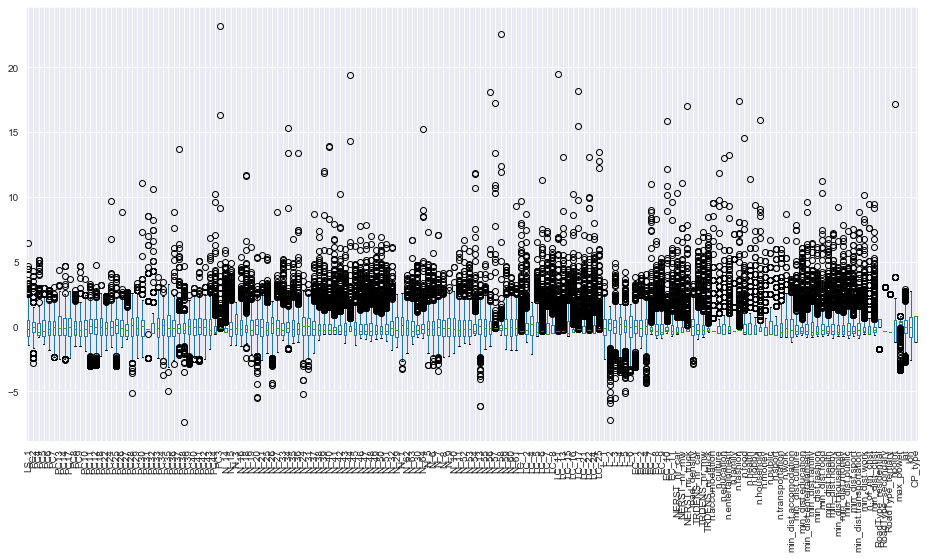

In [ ]:
## Treating outliers for the train data
plt.figure(figsize = (16,8))
evci_train[scaled_cols].boxplot()
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# outlier treatment for the train dataset
evci_train2 = evci_train[~(evci_train>10).any(axis = 1)]
print(evci_train2.shape)
print(evci_train2.shape[0]/evci_train.shape[0])

(972, 173)
0.9566929133858267


In [ ]:
X_train = evci_train2.drop('n_RFID', axis =1)
y_train = evci_train2['n_RFID']

In [ ]:
X_train.head()

LS_1       PC2       PC4       PC5       PC6       PC7      PC13  \
1262 -0.376875 -0.434262 -0.733065 -1.027260 -1.215038 -0.978980 -0.453521   
13    0.346231 -0.827311  1.147768  2.490096  2.728308  1.340875  0.914969   
451   2.493564 -0.434262  0.708571  1.472991  1.642536  1.516160  0.915795   
213  -1.333306 -0.041213 -0.139675 -0.386104 -0.811294 -0.997883 -1.323397   
921   0.292738 -0.434262  1.072062  0.741784  0.625757  0.671227  0.825040   

          PC14      PC17       PC8       PC9      PC10      PC11      PC12  \
1262 -0.459945 -1.022952 -0.348182 -0.955437 -1.067853 -0.761427 -0.761935   
13    0.608591  1.434642  1.449416  1.701539  2.139729  0.193386 -0.064525   
451   1.028120  1.386009  2.025219  1.786051  1.201272  0.731935  0.549572   
213  -1.350550 -1.072245 -0.805541 -0.576453 -0.635939 -1.519862 -1.291135   
921   1.036845  0.675418  0.211673  0.566650  0.759986  0.814770  0.816954   

          PC18      PC22      PC24      PC25      PC26      PC27      PC28  \
1262 -1.314335 -1.067746 -0.729443 -0.589163 -1.091799 -0.838296 -0.494664   
13    1.159011  2.223665  0.284614  0.182361  1.962437  2.421862  1.641925   
451   0.752266  2.309080  0.378128  0.179609  0.915217  2.550026  1.059219   
213  -1.130948 -0.875473 -0.835906 -1.501298 -0.579037 -0.404439  1.059219   
921   0.476718  0.312447  1.283588  1.234851  0.788347  0.080222  0.088042   

          PC29      PC30      PC31      PC32      PC33      PC34      PC35  \
1262 -0.083954  0.477949 -0.217521  1.077365  0.471656 -1.164613  0.683494   
13   -1.134829 -1.134013 -0.217521 -0.512201 -1.572024  1.122079 -0.312337   
451  -1.134829 -0.731022 -0.217521 -0.512201 -0.643078  0.868003 -0.113171   
213  -0.609391 -0.731022 -0.217521 -0.512201  0.471656  0.105772 -0.710669   
921  -0.346673  0.074959 -0.217521  0.282582 -0.643078 -0.910536  1.280992   

          PC36      PC37      PC38      PC39      PC40      PC41      PC42  \
1262 -0.697807  0.299874 -0.368939 -1.061176 -0.877638 -0.611911 -0.101369   
13    1.770543 -0.633591  1.360551  1.195655  1.185450  0.297275  0.311186   
451   0.227825 -0.898734  0.285017  1.277983  1.314188  0.313945  0.462885   
213   0.536368 -0.109961  0.120097 -1.265981 -1.230259 -1.340518 -1.383138   
921   0.227825 -0.781189  0.614512  0.848564  0.709720  0.831727  1.233370   

          PC43      PC44       PC3      N_14      N_15       N_3      N_16  \
1262  0.782613  0.162315 -0.106579 -0.441860 -0.818817  1.063137 -0.659484   
13    1.072135 -0.538755 -0.099055 -0.441860 -0.274537  0.296562 -0.429647   
451   1.320011 -0.540741 -0.106579  2.842768  4.066697 -1.403041  4.459411   
213  -1.036745 -0.535100 -0.106579 -0.441860 -0.548972  0.358617 -1.448596   
921   0.995932 -0.499276 -0.101049 -0.438342 -0.311962  0.043695 -0.029610   

          N_18      N_19      N_20      N_21      N_25      N_26      N_27  \
1262 -0.011835 -0.469936  0.107061 -0.248029 -0.666275  1.175575 -0.310689   
13   -0.213905 -0.908903  0.729981  0.137992 -0.151302  0.251552  0.016002   
451   1.276537  1.305388 -1.011122 -1.535925  1.856617 -1.726546 -1.292263   
213   0.162656 -0.999083 -1.723015  2.022200 -0.159741 -1.036646  3.139599   
921  -0.531976 -0.777542  0.086109  0.454281 -0.496675  0.852328  0.065922   

          N_33      N_34      N_35      N_36      N_24      N_31      N_37  \
1262 -0.371456  0.495093 -0.530666 -0.091078  0.796591  1.193151 -1.244306   
13   -0.677386 -0.412036 -0.222759  0.022486 -0.434958  0.293295  1.236690   
451   4.548387  0.753823  1.377398 -0.743927 -1.843575 -0.550742  0.715107   
213  -1.063112 -1.731836 -1.107227  0.200015 -0.894925 -0.352849  0.157481   
921  -0.060778  0.086157  0.164981  0.349999  0.960072  0.835855  1.376237   

          N_38      N_39      N_40      N_41      N_42      N_43      N_44  \
1262 -0.790912 -0.552017 -0.590769 -0.581621 -0.564977 -0.677306  1.039392   
13    0.022765 -0.186681  0.217227  0.189263 -0.564977  0.838697 -0.349333   
451   4.377667  3.844228

In [ ]:
y_train.head()

1262    0
13      0
451     1
213     1
921     0
Name: n_RFID, dtype: int64

In [ ]:
X_test = evci_test.drop('n_RFID', axis = 1)
y_test = evci_test['n_RFID']

In [ ]:
X_test.head()

LS_1       PC2       PC4       PC5       PC6       PC7      PC13  \
474  1.385493 -2.399508 -0.346248 -0.194383 -0.359774 -1.222376  0.759633   
689  0.132886 -0.041213 -0.392623 -0.097146 -0.119379  0.143255  0.128098   
762  0.274165 -0.434262  0.672099  0.373530  0.068740 -0.108572 -0.144142   
643  1.868870 -1.220360 -0.078303  0.203117  0.319325 -0.037439  1.187290   
879  0.622219 -1.220360 -0.333556 -0.382118 -0.428163 -1.013656  0.311666   

         PC14      PC17       PC8       PC9      PC10      PC11      PC12  \
474  0.865120 -0.843432  0.872437 -0.104773  0.083361 -0.505148 -1.580653   
689  0.001848  0.714554 -0.094832  0.123772  0.024586 -0.026420 -0.123013   
762 -0.272081 -0.608567 -0.279078  1.033732  0.458187 -0.189864 -0.301142   
643  0.486956 -0.114936 -0.214240  0.146557  0.795869  0.187726 -0.256279   
879  0.398070 -0.602314  0.146683 -0.579369 -0.082761 -0.211206 -0.990895   

         PC18      PC22      PC24      PC25      PC26      PC27      PC28  \
474  0.931676  1.059036 -0.378286 -0.556895  0.042534  1.313890  0.282277   
689 -0.236104 -0.141902 -0.115631 -0.039409 -0.043573  0.119606  0.282277   
762 -0.106470 -0.132561  0.978449  0.280274 -0.487172 -0.278404  0.864983   
643  0.748040  0.353922  0.280693  0.715206  0.126977  0.330898  0.670748   
879  0.274536  0.014553 -0.690715 -0.283854  0.181804  0.277059 -0.106193   

         PC29      PC30      PC31      PC32      PC33      PC34      PC35  \
474  0.704202 -1.537003 -2.397418 -0.512201 -1.014657  2.392464 -0.511503   
689 -0.083954 -0.731022 -0.217521 -0.512201  1.214812  0.105772 -0.909835   
762 -1.134829 -0.731022 -0.217521 -0.512201 -0.643078 -0.656459  1.679324   
643  0.178765 -1.134013 -0.217521 -0.512201 -0.828868  0.359849  0.484328   
879  0.441483 -0.328032 -0.217521 -0.512201 -0.457289  1.884310 -1.109001   

         PC36      PC37      PC38      PC39      PC40      PC41      PC42  \
474 -0.080719  1.890325 -0.257700 -0.475179  0.833635  0.747846  0.451576   
689 -0.697807 -0.202242  0.108104 -0.060378  0.035188  0.020613  0.239545   
762 -0.389263 -0.868952  0.016581  0.069309 -0.152959 -0.271381 -0.060541   
643  0.536368  0.861198 -0.491152  0.322308  0.608754  1.002160  1.115269   
879  0.227825  1.903725 -0.007359 -0.429727  0.406385  0.698645  0.043006   

         PC43      PC44       PC3      N_14      N_15       N_3      N_16  \
474  0.355114 -0.507277 -0.106579  1.581523  0.316702 -0.575528  0.282661   
689  0.617957 -0.320450 -0.106579  0.533363 -0.087843 -0.264038  0.219948   
762 -0.367069 -0.473314 -0.106579 -0.441860  0.068699 -0.580982  0.652307   
643  0.756467 -0.474619 -0.106579 -0.441860  0.386371 -0.580982  1.324373   
879 -0.273587 -0.425612 -0.106579 -0.441860  0.335682 -0.580982  0.001828   

         N_18      N_19      N_20      N_21      N_25      N_26      N_27  \
474 -0.091944  2.153073 -1.127246 -1.332576  1.335690 -1.769028 -0.939916   
689 -0.350678  0.107037 -1.273507  1.233254 -0.499338 -0.100931  1.238093   
762  0.060867 -0.236880  1.013560 -1.214081 -0.162654  0.755373 -1.260794   
643 -0.092421 -0.437297  1.180614 -0.827805 -0.167285  0.264858 -0.649357   
879 -0.318994  0.911241 -1.135950  0.151536 -0.006044 -0.152190  0.045786   

         N_33      N_34      N_35      N_36      N_24      N_31      N_37  \
474  1.155862  1.259505  0.044393 -0.203563 -1.605337 -0.701638  0.747716   
689 -0.034620 -0.357882  2.113637  0.913580 -0.484079 -0.646400  0.187132   
762  0.498659  0.190771 -0.628252 -0.808637  0.300692  1.551343 -0.643267   
643  0.271094 -0.264450  0.303831 -0.532646 -0.496096  0.896299  0.029815   
879  0.119548  0.608943 -0.246758 -0.225640  0.060664 -0.337586  1.023680   

         N_38      N_39      N_40      N_41      N_42      N_43      N_44  \
474  3.524989  2.035930  2.632563  4.774262  0.201430  3.785533 -0.356954   
689  1.485733  1.771568 -0.033457 -0.076353  2.984021  0.739015 -0.356954   
762 -0.318371 -0.552017 -0.357067 -0.311645 -0.311220 -0.087531 -0.356954 

In [ ]:
y_test.head()

474    0
689    1
762    0
643    0
879    0
Name: n_RFID, dtype: int64

### Data Modelling

In [ ]:
# creating a function for gridsearch which can be used various models

# Create a function gridsearch which would be used for fine tuning hyper-parameters
def gridsearch_classifier(estimator, params, score, X_train, y_train, refit_score):
    kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 16)
    grid_search = GridSearchCV(estimator, params, scoring = score, refit = refit_score, cv = kfolds, return_train_score = True, n_jobs = - 1, verbose=2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    cv_results = grid_search.cv_results_
    cv_results = pd.DataFrame(cv_results)
    return cv_results


# Creating a function for metrics, confusion matrix and classification report 
def classification_rep(y_train, X_train, model):
    probs = np.array([x[-1] for x in model.predict_proba(X_train)])
    print('The roc_auc score is {}'.format(roc_auc_score(y_train, probs).round(4)))
    print('confusion matrix:')
    print(confusion_matrix(y_train, model.predict(X_train)))
    print('classification report:')
    print(classification_report(y_train, model.predict(X_train)))

# Creating a function metrics_curve for drawing ROC_curve and 
def metrics_curves(y_train, X_train, model, graphs = True):  
    
    probs = np.array([x[-1] for x in model.predict_proba(X_train)])
    fpr, tpr, thresholds = roc_curve( y_train, probs)
    auc_score = roc_auc_score( y_train, probs )
    
    if graphs == True:
        plt.figure(figsize=(8, 8))
        plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.legend(loc="lower right")
        plt.show()


        p, r, thresholds = precision_recall_curve(y_train, probs)
        pre_recal = pd.DataFrame({'precision':p[:-1], 'recall':r[:-1], 'thresholds': thresholds})
        pre_recal.plot.line(x='thresholds', y=['precision','recall'], figsize = (8,8))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title('Precision vs Recall Trade-Off Curve')
        plt.show()
    
    thresh = [i/100 for i in range(0,105,5)]
    results_df = pd.DataFrame( columns = ['thresh','accuracy','prec', 'recal', 'f1score'])

    for i in thresh:
        pred =  [1 if t > i else 0 for t in probs]
        pr = metrics.precision_score(y_train, pred)
        rc = metrics.recall_score(y_train, pred)
        ac = metrics.accuracy_score(y_train, pred)
        f1 = metrics.f1_score(y_train, pred)
        results_df.loc[i] = [i, ac, pr, rc, f1]
    
    return results_df, fpr, tpr

In [ ]:
#  creating model_Results dataframe which would be used for comparing models
model_results = pd.DataFrame({'Model':[], 'Description':[] , 'Train_auc_mean': [], 'cv_auc_mean':[], 'cv_auc_std' :[], 'test_auc':[]})

In [ ]:
model_results

Empty DataFrame
Columns: [Model, Description, Train_auc_mean, cv_auc_mean, cv_auc_std, test_auc]
Index: []

#### Logistic Regression

The roc_auc score is 0.9557
confusion matrix:
[[639  88]
 [ 28 217]]
classification report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       727
           1       0.71      0.89      0.79       245

    accuracy                           0.88       972
   macro avg       0.83      0.88      0.85       972
weighted avg       0.90      0.88      0.88       972


 Predicting for the test dataset 

The roc_auc score is 0.8804
confusion matrix:
[[158  32]
 [ 17  48]]
classification report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       190
           1       0.60      0.74      0.66        65

    accuracy                           0.81       255
   macro avg       0.75      0.79      0.76       255
weighted avg       0.83      0.81      0.81       255



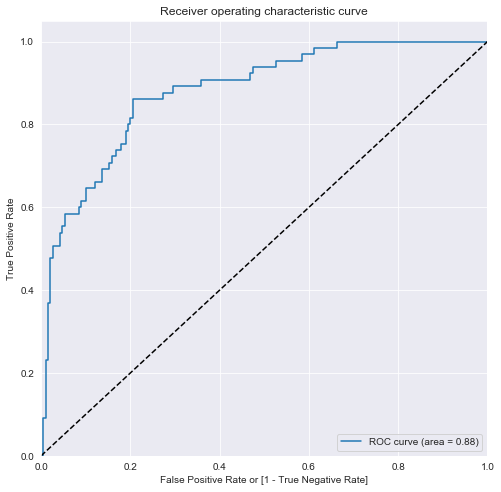

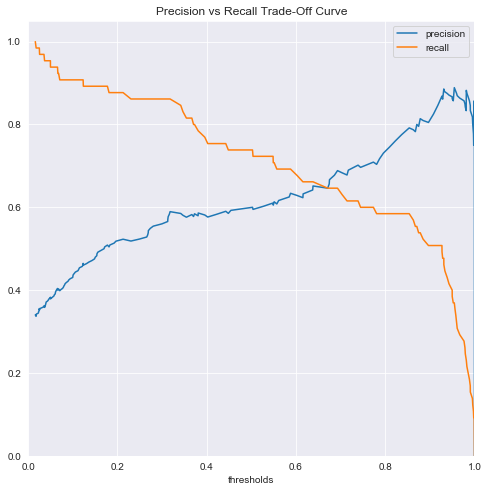

C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#  Creating logistic model with class_weight = balanced
log_m = LogisticRegression(random_state = 0, n_jobs = -1, class_weight= 'balanced')
log_m.fit(X_train, y_train)

# identifying metrics for the train dataset
classification_rep(y_train, X_train, log_m)

# results of test dataset
print('\n Predicting for the test dataset \n')
classification_rep(y_test, X_test, log_m)
results, fpr, tpr = metrics_curves(y_test, X_test, log_m)

In [ ]:
##- Hyper-parametr tuning using gridsearch- penalty (regularization) and C - regularization

lr_m = LogisticRegression(random_state = 0, n_jobs = -1)
#param grid for gridsearch
params = {'solver': ['newton-cg', 'lbfgs', 'saga', 'liblinear'], 'penalty' : ['l1', 'l2', 'elasticnet'], 'C':[ 0.05, 0.1, 0.2, 0.22, 0.25, 0.28, 0.3, 0.4, 0.5, 0.8, 1, 10, 100], 'class_weight': ['balanced', None, {0:1, 1:3}]}

# using the gridsearch function created for grid search and tuning hyper parameter
cv_results = gridsearch_classifier(lr_m, params, ['recall', 'accuracy', 'precision', 'roc_auc', 'f1'], X_train, y_train, 'f1')
cv_results[['param_C', 'param_solver', 'param_penalty', 'param_class_weight', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_roc_auc', 'std_test_roc_auc','mean_test_f1']].sort_values(by = 'mean_test_roc_auc', ascending = False).head(10)

Fitting 5 folds for each of 468 candidates, totalling 2340 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2340 out of 2340 | elapsed:   20.5s finished


{'C': 0.05, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'saga'}


param_C param_solver param_penalty param_class_weight  mean_test_recall  \
122    0.22         saga            l1               None          0.579592   
86      0.2         saga            l1               None          0.579592   
87      0.2    liblinear            l1               None          0.583673   
158    0.25         saga            l1               None          0.575510   
19     0.05    liblinear            l2               None          0.604082   
123    0.22    liblinear            l1               None          0.575510   
159    0.25    liblinear            l1               None          0.575510   
18     0.05         saga            l2               None          0.563265   
17     0.05        lbfgs            l2               None          0.563265   
16     0.05    newton-cg            l2               None          0.563265   

     mean_test_accuracy  mean_test_precision  mean_test_roc_auc  \
122            0.841570             0.736970           0.879834   
86             0.840539             0.733433           0.879750   
87             0.841560             0.736030           0.879669   
158            0.842596             0.744087           0.879327   
19             0.833317             0.695190           0.879232   
123            0.840539             0.735890           0.879217   
159            0.839514             0.731217           0.879103   
18             0.837446             0.732505           0.878845   
17             0.837446             0.732505           0.878816   
16             0.837446             0.732505           0.878816   

     std_test_roc_auc  mean_test_f1  
122          0.014117      0.647083  
86           0.013952      0.645634  
87           0.014968      0.649677  
158          0.014825      0.646991  
19           0.022680      0.644155  
123          0.015456      0.644105  
159          0.015269      0.642704  
18           0.019174      0.633546  
17           0.019283      0.633546  
16           0.019283      0.633546

C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The roc_auc score is 0.9294
confusion matrix:
[[692  35]
 [ 84 161]]
classification report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       727
           1       0.82      0.66      0.73       245

    accuracy                           0.88       972
   macro avg       0.86      0.80      0.83       972
weighted avg       0.87      0.88      0.87       972


 Predicting for the test dataset 

The roc_auc score is 0.9077
confusion matrix:
[[180  10]
 [ 26  39]]
classification report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       190
           1       0.80      0.60      0.68        65

    accuracy                           0.86       255
   macro avg       0.83      0.77      0.80       255
weighted avg       0.85      0.86      0.85       255



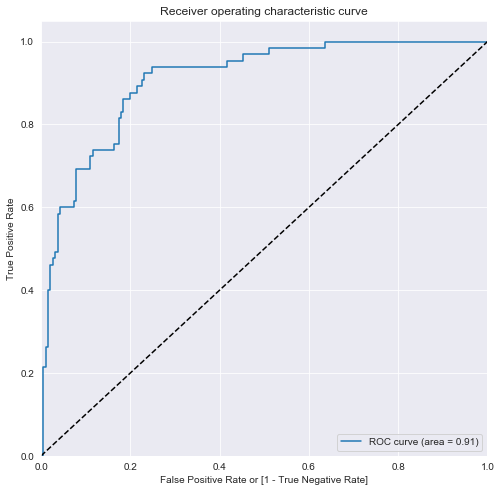

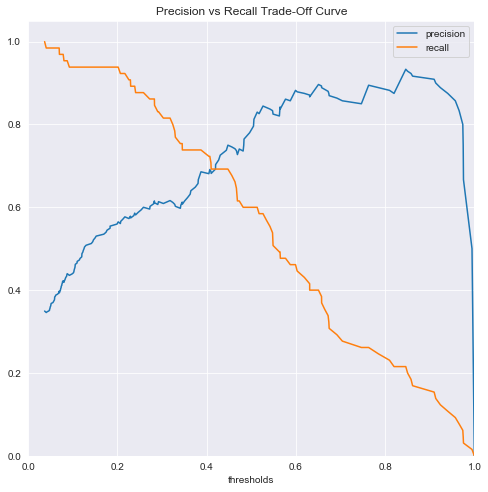

C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Finalizing the model based on above hyper parameter tuning
log_m_final = LogisticRegression(C = 0.22, penalty = 'l1', random_state = 0, n_jobs = -1, solver = 'saga')
log_m_final.fit(X_train, y_train)

# identifying metrics for the train dataset
classification_rep(y_train, X_train, log_m_final)

# results of test dataset
print('\n Predicting for the test dataset \n')
classification_rep(y_test, X_test, log_m_final)
results, fpr, tpr = metrics_curves(y_test, X_test, log_m_final)

In [ ]:
model_results.loc[0] = ['log_m_final', 'logistic regression with l1 penalty', 0.9294, 0.8798, 0.014117, 0.9077]

In [ ]:
model_results

Model                          Description  Train_auc_mean  \
0  log_m_final  logistic regression with l1 penalty          0.9294   

   cv_auc_mean  cv_auc_std  test_auc  
0       0.8798    0.014117    0.9077

#### Random Forest Model

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


The roc_auc score is 1.0
confusion matrix:
[[727   0]
 [ 12 233]]
classification report:


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       727
           1       1.00      0.95      0.97       245

    accuracy                           0.99       972
   macro avg       0.99      0.98      0.98       972
weighted avg       0.99      0.99      0.99       972


 Predicting for the test dataset 

The roc_auc score is 0.8336
confusion matrix:


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


[[180  10]
 [ 40  25]]
classification report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       190
           1       0.71      0.38      0.50        65

    accuracy                           0.80       255
   macro avg       0.77      0.67      0.69       255
weighted avg       0.79      0.80      0.78       255



[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


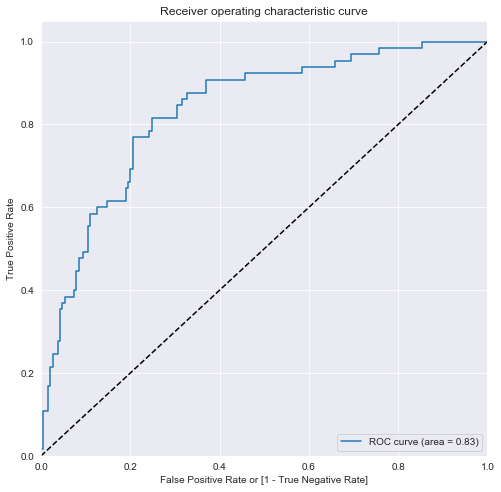

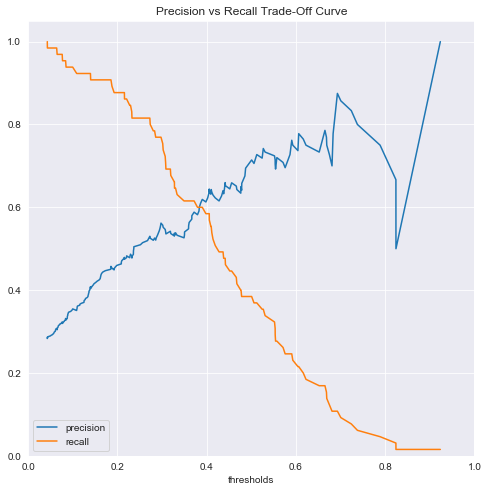

C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# using a base model with 40 trees
rf_m = RandomForestClassifier(n_estimators = 40, max_depth =10, n_jobs = -1, random_state = 0, oob_score= True, verbose = 1)
rf_m.fit(X_train, y_train)

# identifying metrics for the train dataset
classification_rep(y_train, X_train, rf_m)

# results of test dataset
print('\n Predicting for the test dataset \n')
classification_rep(y_test, X_test, rf_m)
results, fpr, tpr = metrics_curves(y_test, X_test, rf_m)

In [ ]:
# Tuning hyper parameters - Tuning n_estimators, max_depth, min_samples split and max_features
rf_m = RandomForestClassifier(random_state = 0, n_jobs = -1, class_weight= 'balanced', verbose=1, oob_score = True)
params_rf = {'min_samples_split' : [2, 5,10,20], 'n_estimators' : range(20,200,20), 'max_depth' : [5,10,12], 'max_features' : ['auto', 0.2, 0.5, 0.8]}

# using the gridsearch for identifying best parameters
cv_results = gridsearch_classifier(rf_m, params_rf, ['recall', 'accuracy', 'precision', 'roc_auc', 'f1'], X_train, y_train, 'roc_auc')
cv_results.loc[cv_results['rank_test_roc_auc'] == 1]

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


{'max_depth': 12, 'max_features': 0.8, 'min_samples_split': 10, 'n_estimators': 140}


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.2s finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
420       1.597735      0.302008         2.340952        0.499055   

    param_max_depth param_max_features param_min_samples_split  \
420              12                0.8                      10   

    param_n_estimators                                             params  \
420                140  {'max_depth': 12, 'max_features': 0.8, 'min_sa...   

     split0_test_recall  split1_test_recall  split2_test_recall  \
420            0.326531            0.489796            0.530612   

     split3_test_recall  split4_test_recall  mean_test_recall  \
420            0.530612            0.510204          0.477551   

     std_test_recall  rank_test_recall  split0_train_recall  \
420         0.077012               259             0.994898   

     split1_train_recall  split2_train_recall  split3_train_recall  \
420                  1.0                  1.0                  1.0   

     split4_train_recall  mean_train_recall  std_train_recall  \
420                  1.0            0.99898          0.002041   

     split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
420              0.764103              0.835897              0.845361   

     split3_test_accuracy  split4_test_accuracy  mean_test_accuracy  \
420              0.835052              0.819588                0.82   

     std_test_accuracy  rank_test_accuracy  split0_train_accuracy  \
420           0.029145                  85               0.994852   

     split1_train_accuracy  split2_train_accuracy  split3_train_accuracy  \
420               0.997426               0.997429               0.994859   

     split4_train_accuracy  mean_train_accuracy  std_train_accuracy  \
420               0.994859             0.995885             0.00126   

     split0_test_precision  split1_test_precision  split2_test_precision  \
420               0.551724               0.774194               0.787879   

     split3_test_precision  split4_test_precision  mean_test_precision  \
420               0.742857               0.694444              0.71022   

     std_test_precision  rank_test_precision  split0_train_precision  \
420            0.085508                  118                0.984848   

     split1_train_precision  split2_train_precision  split3_train_precision  \
420                0.989899                0.989899                    0.98   

     split4_train_precision  mean_train_precision  std_train_precision  \
420                    0.98              0.984929             0.004427   

     split0_test_roc_auc  split1_test_roc_auc  split2_test_roc_auc  \
420             0.814929             0.887755             0.888529   

     split3_test_roc_auc  split4_test_roc_auc  mean_test_roc_auc  \
420              0.87361               0.8867           0.870305   

     std_test_roc_auc  rank_test_roc_auc  split0_train_roc_auc  \
420          0.028224                  1              0.999833   

     split1_train_roc_auc  split2_train_roc_auc  split3_train_roc_auc  \
420              0.999824              0.999912              0.999869   

     split4_train_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
420              0.999807            0.999849           0.000037   

     split0_test_f1  split1_test_f1  split2_test_f1  split3_test_f1  \
420        0.410256             0.6        0.634146        0.619048   

     split4_test_f1  mean_test_f1  std_test_f1  rank_test_f1  split0_train_f1  \
420        0.588235      0.570337     0.081573           252         0.989848   

     split1_train_f1  split2_train_f1  split3_train_f1  split4_train_f1  \
420         0.994924         0.994924         0.989899         0.989899   

     mean_train_f1  std_train_f1  
420       0.991899       0.00247

In [ ]:
# further tuning n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
rf_m = RandomForestClassifier(random_state = 0, n_jobs = -1, class_weight= 'balanced', verbose=1, oob_score = True)
params_rf = {'min_samples_split' : range(2,50,20),'min_samples_leaf' : range(2,50,20), 'n_estimators' : range(100,200,20), 'max_depth' : [12,14,16], 'max_features' : ['auto', 0.2, 0.5, 0.8]}

# using the gridsearch for identifying best parameters
cv_results = gridsearch_classifier(rf_m, params_rf, ['recall', 'accuracy', 'precision', 'roc_auc', 'f1'], X_train, y_train, 'roc_auc')
cv_results.loc[cv_results['rank_test_roc_auc'] == 1]

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


{'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
180       0.883663      0.332522          0.36815        0.094474   

    param_max_depth param_max_features param_min_samples_leaf  \
180              14               auto                      2   

    param_min_samples_split param_n_estimators  \
180                       2                100   

                                                params  split0_test_recall  \
180  {'max_depth': 14, 'max_features': 'auto', 'min...            0.265306   

     split1_test_recall  split2_test_recall  split3_test_recall  \
180             0.44898            0.510204            0.489796   

     split4_test_recall  mean_test_recall  std_test_recall  rank_test_recall  \
180            0.489796          0.440816         0.089981               526   

     split0_train_recall  split1_train_recall  split2_train_recall  \
180             0.994898                  1.0                  1.0   

     split3_train_recall  split4_train_recall  mean_train_recall  \
180                  1.0                  1.0            0.99898   

     std_train_recall  split0_test_accuracy  split1_test_accuracy  \
180          0.002041              0.748718              0.835897   

     split2_test_accuracy  split3_test_accuracy  split4_test_accuracy  \
180              0.835052              0.824742              0.829897   

     mean_test_accuracy  std_test_accuracy  rank_test_accuracy  \
180            0.814861           0.033313                  61   

     split0_train_accuracy  split1_train_accuracy  split2_train_accuracy  \
180               0.998713                    1.0                    1.0   

     split3_train_accuracy  split4_train_accuracy  mean_train_accuracy  \
180               0.998715                    1.0             0.999486   

     std_train_accuracy  split0_test_precision  split1_test_precision  \
180             0.00063                    0.5               0.814815   

     split2_test_precision  split3_test_precision  split4_test_precision  \
180               0.757576               0.727273                   0.75   

     mean_test_precision  std_test_precision  rank_test_precision  \
180             0.709933            0.108856                   47   

     split0_train_precision  split1_train_precision  split2_train_precision  \
180                     1.0                     1.0                     1.0   

     split3_train_precision  split4_train_precision  mean_train_precision  \
180                0.994924                     1.0              0.998985   

     std_train_precision  split0_test_roc_auc  split1_test_roc_auc  \
180              0.00203             0.811714             0.900475   

     split2_test_roc_auc  split3_test_roc_auc  split4_test_roc_auc  \
180             0.890218             0.871921             0.877833   

     mean_test_roc_auc  std_test_roc_auc  rank_test_roc_auc  \
180           0.870432           0.03098                  1   

     split0_train_roc_auc  split1_train_roc_auc  split2_train_roc_auc  \
180                   1.0                   1.0                   1.0   

     split3_train_roc_auc  split4_train_roc_auc  mean_train_roc_auc  \
180                   1.0                   1.0                 1.0   

     std_train_roc_auc  split0_test_f1  split1_test_f1  split2_test_f1  \
180       4.965068e-17        0.346667        0.578947        0.609756   

     split3_test_f1  split4_test_f1  mean_test_f1  std_test_f1  rank_test_f1  \
180        0.585366        0.592593      0.542666     0.098538           526   

     split0_train_f1  split1_train_f1  split2_train_f1  split3_train_f1  \
180         0.997442              1.0              1.0         0.997455   

     split4_train_f1  mean_train_f1  std_train_f1  
180              1.0        0.99898       0.00125

In [ ]:
# further tuning n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
rf_m = RandomForestClassifier(random_state = 0, n_jobs = -1, verbose=1, oob_score = True)
params_rf = {'class_weight': ['balanced', None], 'min_samples_split' : [2,5,10],'min_samples_leaf' : [2,5,10], 'n_estimators' : range(80,120,10), 'max_depth' : [13,14,15], 'max_features' : ['auto', 0.2, 0.5, 0.8]}

# using the gridsearch for identifying best parameters
cv_results = gridsearch_classifier(rf_m, params_rf, ['recall', 'accuracy', 'precision', 'roc_auc', 'f1'], X_train, y_train, 'roc_auc')
cv_results.loc[cv_results['rank_test_roc_auc'] == 1]

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3233 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  5.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


{'class_weight': 'balanced', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
146       0.358715      0.022943         0.241844        0.001667   

    param_class_weight param_max_depth param_max_features  \
146           balanced              14               auto   

    param_min_samples_leaf param_min_samples_split param_n_estimators  \
146                      2                       2                100   

                                                params  split0_test_recall  \
146  {'class_weight': 'balanced', 'max_depth': 14, ...            0.265306   

     split1_test_recall  split2_test_recall  split3_test_recall  \
146             0.44898            0.510204            0.489796   

     split4_test_recall  mean_test_recall  std_test_recall  rank_test_recall  \
146            0.489796          0.440816         0.089981               464   

     split0_train_recall  split1_train_recall  split2_train_recall  \
146             0.994898                  1.0                  1.0   

     split3_train_recall  split4_train_recall  mean_train_recall  \
146                  1.0                  1.0            0.99898   

     std_train_recall  split0_test_accuracy  split1_test_accuracy  \
146          0.002041              0.748718              0.835897   

     split2_test_accuracy  split3_test_accuracy  split4_test_accuracy  \
146              0.835052              0.824742              0.829897   

     mean_test_accuracy  std_test_accuracy  rank_test_accuracy  \
146            0.814861           0.033313                 428   

     split0_train_accuracy  split1_train_accuracy  split2_train_accuracy  \
146               0.998713                    1.0                    1.0   

     split3_train_accuracy  split4_train_accuracy  mean_train_accuracy  \
146               0.998715                    1.0             0.999486   

     std_train_accuracy  split0_test_precision  split1_test_precision  \
146             0.00063                    0.5               0.814815   

     split2_test_precision  split3_test_precision  split4_test_precision  \
146               0.757576               0.727273                   0.75   

     mean_test_precision  std_test_precision  rank_test_precision  \
146             0.709933            0.108856                  466   

     split0_train_precision  split1_train_precision  split2_train_precision  \
146                     1.0                     1.0                     1.0   

     split3_train_precision  split4_train_precision  mean_train_precision  \
146                0.994924                     1.0              0.998985   

     std_train_precision  split0_test_roc_auc  split1_test_roc_auc  \
146              0.00203             0.811714             0.900475   

     split2_test_roc_auc  split3_test_roc_auc  split4_test_roc_auc  \
146             0.890218             0.871921             0.877833   

     mean_test_roc_auc  std_test_roc_auc  rank_test_roc_auc  \
146           0.870432           0.03098                  1   

     split0_train_roc_auc  split1_train_roc_auc  split2_train_roc_auc  \
146                   1.0                   1.0                   1.0   

     split3_train_roc_auc  split4_train_roc_auc  mean_train_roc_auc  \
146                   1.0                   1.0                 1.0   

     std_train_roc_auc  split0_test_f1  split1_test_f1  split2_test_f1  \
146                0.0        0.346667        0.578947        0.609756   

     split3_test_f1  split4_test_f1  mean_test_f1  std_test_f1  rank_test_f1  \
146        0.585366        0.592593      0.542666     0.098538           518   

     split0_train_f1  split1_train_f1  split2_train_f1  split3_train_f1  \
146         0.997442              1.0              1.0         0.997455   

     split4_train_f1  mean_train_f1  std_train_f1  
146              1.0        0.99898       0.00125

The roc_auc score is 1.0
confusion matrix:
[[725   2]
 [  1 244]]
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       0.99      1.00      0.99       245

    accuracy                           1.00       972
   macro avg       1.00      1.00      1.00       972
weighted avg       1.00      1.00      1.00       972


 Predicting for the test dataset 

The roc_auc score is 0.8532
confusion matrix:
[[178  12]
 [ 40  25]]
classification report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       190
           1       0.68      0.38      0.49        65

    accuracy                           0.80       255
   macro avg       0.75      0.66      0.68       255
weighted avg       0.78      0.80      0.78       255



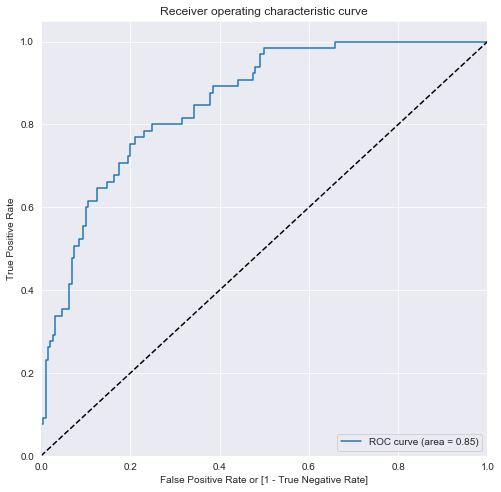

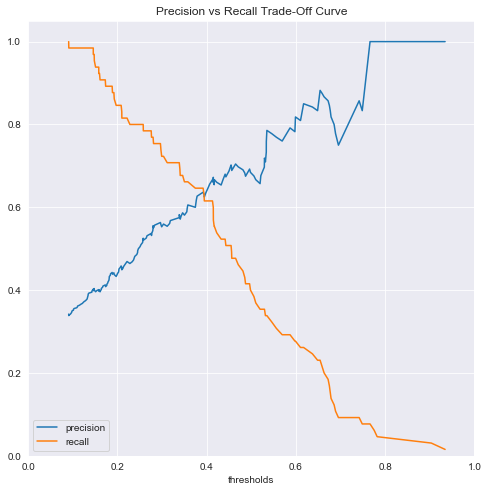

C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# using the finetuned hyper-parameters
# increasing the number of trees based on previous reuslt
rf_m_final = RandomForestClassifier(max_depth= 14, max_features = 'auto', min_samples_split = 2, n_estimators= 100, min_samples_leaf = 2, random_state = 0, n_jobs = -1, class_weight = 'balanced')
rf_m_final.fit(X_train, y_train)

# identifying metrics for the train dataset
classification_rep(y_train, X_train, rf_m_final)

# results of test dataset
print('\n Predicting for the test dataset \n')
classification_rep(y_test, X_test, rf_m_final)
results, fpr, tpr = metrics_curves(y_test, X_test, rf_m_final)

In [ ]:
model_results.loc[1] = ['rf_m_final', 'Random Forest', 1.0, 0.870432, 0.03098, 0.8532]
model_results

Model                          Description  Train_auc_mean  \
0  log_m_final  logistic regression with l1 penalty          0.9294   
1   rf_m_final                        Random Forest          1.0000   

   cv_auc_mean  cv_auc_std  test_auc  
0     0.879800    0.014117    0.9077  
1     0.870432    0.030980    0.8532

#### GBM Classifier

In [ ]:
# defining function gbm_fit for fitting the dataset and cross validation
def gbm_fit(gbm_m, X_train, y_train, req_cv = True, fimp = True, kfolds = 5):
    
    gbm_m.fit(X_train, y_train)
    classification_rep(y_train, X_train, gbm_m)
    
    if req_cv:
        cv_score = cross_val_score(gbm_m, X_train, y_train, cv = kfolds, n_jobs = -1, verbose =1, scoring = 'roc_auc')
        print('cross validation scores:')
        print('cv score mean is {}'.format(cv_score.mean()))
        print('cv score std is {}'.format(cv_score.std()))
    if fimp:
        feat_imp = pd.DataFrame({'features': X_train.columns, 'imp':gbm_m.feature_importances_})
        feat_imp.plot(kind = 'bar')
        plt.show()
    return cv_score

In [ ]:
# fitting the base model
gbm_m = GradientBoostingClassifier(random_state = 0)
gbm_fit(gbm_m, X_train, y_train, fimp = False)

The roc_auc score is 1.0
confusion matrix:
[[727   0]
 [ 10 235]]
classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       727
           1       1.00      0.96      0.98       245

    accuracy                           0.99       972
   macro avg       0.99      0.98      0.99       972
weighted avg       0.99      0.99      0.99       972



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


cross validation scores:
cv score mean is 0.8865217433217973
cv score std is 0.016366148229863618


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


array([0.9032709 , 0.87866928, 0.86938776, 0.90893737, 0.87234342])

In [ ]:
# Tuning n_estimator parameters for the alpha rate of 0.05
params1 = {'n_estimators':range(200,800,10), 'max_depth': range(2,9,1)}

grid_search = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate =0.05, max_depth=8,
                                                  min_samples_split=500, min_samples_leaf=50, subsample=0.8, max_features='sqrt',
                                                  random_state=0), 
                        param_grid = params1, scoring='roc_auc',cv=5, n_jobs = -1, return_train_score = True, verbose = 2)
grid_search.fit(X_train,y_train)
final_cv_results = grid_search.cv_results_
final_cv_results = pd.DataFrame(final_cv_results)
final_cv_results[final_cv_results['rank_test_score'] == 1]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:   54.8s finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
108       0.817485      0.008803         0.005204    4.002333e-04   
168       0.810680      0.003524         0.005404    4.903297e-04   
228       0.832231      0.017439         0.009208    3.603005e-03   
288       0.820794      0.010238         0.005404    4.903686e-04   
348       0.845709      0.023600         0.005805    4.003525e-04   
408       0.823703      0.008205         0.005004    1.907349e-07   

    param_max_depth param_n_estimators                                 params  \
108               3                680  {'max_depth': 3, 'n_estimators': 680}   
168               4                680  {'max_depth': 4, 'n_estimators': 680}   
228               5                680  {'max_depth': 5, 'n_estimators': 680}   
288               6                680  {'max_depth': 6, 'n_estimators': 680}   
348               7                680  {'max_depth': 7, 'n_estimators': 680}   
408               8                680  {'max_depth': 8, 'n_estimators': 680}   

     split0_test_score  split1_test_score  split2_test_score  \
108           0.910679           0.883841           0.873329   
168           0.910679           0.883841           0.873329   
228           0.910679           0.883841           0.873329   
288           0.910679           0.883841           0.873329   
348           0.910679           0.883841           0.873329   
408           0.910679           0.883841           0.873329   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
108           0.915693           0.896692         0.896047         0.01591   
168           0.915693           0.896692         0.896047         0.01591   
228           0.915693           0.896692         0.896047         0.01591   
288           0.915693           0.896692         0.896047         0.01591   
348           0.915693           0.896692         0.896047         0.01591   
408           0.915693           0.896692         0.896047         0.01591   

     rank_test_score  split0_train_score  split1_train_score  \
108                1            0.990314            0.988356   
168                1            0.990314            0.988356   
228                1            0.990314            0.988356   
288                1            0.990314            0.988356   
348                1            0.990314            0.988356   
408                1            0.990314            0.988356   

     split2_train_score  split3_train_score  split4_train_score  \
108            0.991751            0.987447            0.988095   
168            0.991751            0.987447            0.988095   
228            0.991751            0.987447            0.988095   
288            0.991751            0.987447            0.988095   
348            0.991751            0.987447            0.988095   
408            0.991751            0.987447            0.988095   

     mean_train_score  std_train_score  
108          0.989192         0.001597  
168          0.989192         0.001597  
228          0.989192         0.001597  
288          0.989192         0.001597  
348          0.989192         0.001597  
408          0.989192         0.001597

In [ ]:
# Tuning n_estimator, max_depth, min_samples_split, min_samples_leaf parameters for the alpha rate of 0.05
params1 = {'n_estimators':[680], 'max_depth': [3], 'min_samples_split': range(200,500,10), 'min_samples_leaf': range(10,200,10)}

grid_search = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate =0.05, max_depth=3,
                                                  min_samples_split=500, min_samples_leaf=50, subsample=0.8, max_features='sqrt',
                                                  random_state=0), 
                        param_grid = params1, scoring='roc_auc',cv=5, n_jobs = -1, return_train_score = True, verbose = 2)
grid_search.fit(X_train,y_train)
final_cv_results = grid_search.cv_results_
final_cv_results = pd.DataFrame(final_cv_results)
final_cv_results[final_cv_results['rank_test_score'] == 1]

Fitting 5 folds for each of 570 candidates, totalling 2850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2850 out of 2850 | elapsed:  2.0min finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
311       0.998109      0.014331         0.006306        0.000401   

    param_max_depth param_min_samples_leaf param_min_samples_split  \
311               3                    110                     310   

    param_n_estimators                                             params  \
311                680  {'max_depth': 3, 'min_samples_leaf': 110, 'min...   

     split0_test_score  split1_test_score  split2_test_score  \
311           0.915851           0.892647           0.866573   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
311           0.918508           0.902322          0.89918          0.0188   

     rank_test_score  split0_train_score  split1_train_score  \
311                1            0.998613            0.998577   

     split2_train_score  split3_train_score  split4_train_score  \
311             0.99922            0.997826            0.998948   

     mean_train_score  std_train_score  
311          0.998637         0.000469

In [ ]:
# Tuning max_features 
params1 = {'max_features': ['auto', 0.2, 0,4, 0.6, 0.8, 'sqrt'], 'subsample': [i/100 for i in range(60,100,5)]}

grid_search = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate =0.05, n_estimators = 680, max_depth = 3,
                                                                  min_samples_leaf=110, min_samples_split = 310,  
                                                                  random_state=0), 
                        param_grid = params1, scoring='roc_auc',cv=5, n_jobs = -1, return_train_score = True, verbose = 2)
grid_search.fit(X_train,y_train)
final_cv_results = grid_search.cv_results_
final_cv_results = pd.DataFrame(final_cv_results)
final_cv_results[final_cv_results['rank_test_score'] == 1]

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 233 out of 280 | elapsed:   32.6s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   43.6s finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
52       1.002986      0.012569         0.006105        0.000203   

   param_max_features param_subsample  \
52               sqrt             0.8   

                                        params  split0_test_score  \
52  {'max_features': 'sqrt', 'subsample': 0.8}           0.915851   

    split1_test_score  split2_test_score  split3_test_score  \
52           0.892647           0.866573           0.918508   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
52           0.902322          0.89918          0.0188                1   

    split0_train_score  split1_train_score  split2_train_score  \
52            0.998613            0.998577             0.99922   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  
52            0.997826            0.998948          0.998637         0.000469

In [ ]:
# Identifying the n_estimators for alpha rate of 0.05
params1 = {'n_estimators': range(300,700,10)}

grid_search = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate =0.05, n_estimators = 680, max_depth = 3,
                                                                  min_samples_leaf=110, min_samples_split = 310,  
                                                                  random_state=0, subsample = 0.8, max_features = 'sqrt'), 
                        param_grid = params1, scoring='roc_auc',cv=5, n_jobs = -1, return_train_score = True, verbose = 2)
grid_search.fit(X_train,y_train)
final_cv_results = grid_search.cv_results_
final_cv_results = pd.DataFrame(final_cv_results)
final_cv_results[final_cv_results['rank_test_score'] == 1]

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
31        0.89049      0.010735         0.005808        0.000241   

   param_n_estimators                 params  split0_test_score  \
31                610  {'n_estimators': 610}            0.91697   

    split1_test_score  split2_test_score  split3_test_score  \
31           0.895164           0.865025           0.921042   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
31           0.901056         0.899851        0.019892                1   

    split0_train_score  split1_train_score  split2_train_score  \
31            0.997532            0.997076            0.998501   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  
31            0.996616            0.997782          0.997501         0.000639

In [ ]:
gbm_m_final = GradientBoostingClassifier(learning_rate =0.05, n_estimators = 610, max_depth = 3, max_features ='sqrt',
                                                                  min_samples_leaf=110, min_samples_split = 310, subsample=0.8, 
                                                                  random_state=0)
gbm_fit(gbm_m_final, X_train, y_train, req_cv = True, fimp = False)

The roc_auc score is 0.9984
confusion matrix:
[[724   3]
 [ 14 231]]
classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       727
           1       0.99      0.94      0.96       245

    accuracy                           0.98       972
   macro avg       0.98      0.97      0.98       972
weighted avg       0.98      0.98      0.98       972



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


cross validation scores:
cv score mean is 0.8998509635313738
cv score std is 0.019891613402591428


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


array([0.91696953, 0.89516354, 0.86502463, 0.92104152, 0.90105559])


 Predicting for the test dataset 

The roc_auc score is 0.9087
confusion matrix:
[[175  15]
 [ 23  42]]
classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       190
           1       0.74      0.65      0.69        65

    accuracy                           0.85       255
   macro avg       0.81      0.78      0.80       255
weighted avg       0.85      0.85      0.85       255



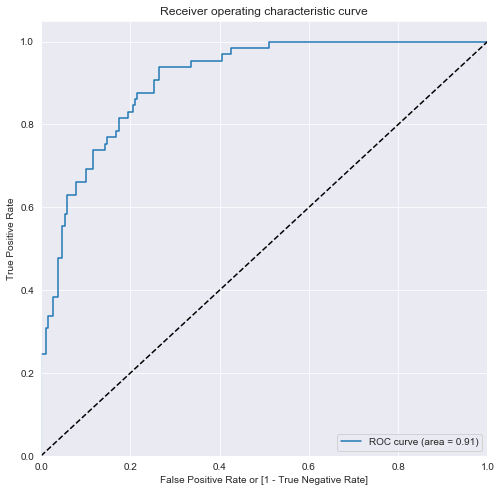

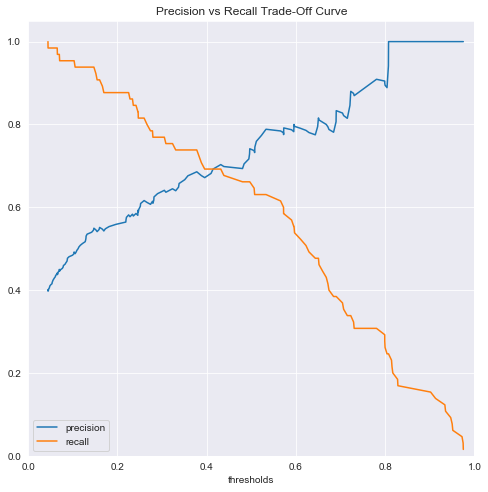

C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# results of test dataset
print('\n Predicting for the test dataset \n')
classification_rep(y_test, X_test, gbm_m_final)
results, fpr, tpr = metrics_curves(y_test, X_test, gbm_m_final)

In [ ]:
model_results.loc[2] = ['gbm_final', 'Gradient Boosting', 0.9984, 0.899851,0.019892, 0.9087]
model_results

Model                          Description  Train_auc_mean  \
0  log_m_final  logistic regression with l1 penalty          0.9294   
1   rf_m_final                        Random Forest          1.0000   
2    gbm_final                    Gradient Boosting          0.9984   

   cv_auc_mean  cv_auc_std  test_auc  
0     0.879800    0.014117    0.9077  
1     0.870432    0.030980    0.8532  
2     0.899851    0.019892    0.9087

### Final results of the models, visualizing roc_auc curves, selecting threshold

In [ ]:
model_results

Model                          Description  Train_auc_mean  \
0  log_m_final  logistic regression with l1 penalty          0.9294   
1   rf_m_final                        Random Forest          1.0000   
2    gbm_final                    Gradient Boosting          0.9984   

   cv_auc_mean  cv_auc_std  test_auc  
0     0.879800    0.014117    0.9077  
1     0.870432    0.030980    0.8532  
2     0.899851    0.019892    0.9087

- Fine Tuned Hyperparameters for three classification algorithms logistic regression (l1 |l2 |elasticnet), Random Forest, Gradient Bossting
- Tuned Logistic regression (l1 penalty) and Gradient booosting classifiers offered same level cross validation roc_auc scores. Even the scores on test data set is almost similar.
- Random forest offered slightly lower roc_auc cross validation score and much lower roc_auc score on the test dataset

#### Visualizing roc_auc curves of these fined tuned models

In [ ]:
gbm_results, gbm_fpr, gbm_tpr  = metrics_curves(y_test, X_test, gbm_m_final, graphs = False)
rf_results, rf_fpr, rf_tpr = metrics_curves(y_test, X_test, rf_m_final, graphs = False)
log_results, log_fpr, log_tpr = metrics_curves(y_test, X_test, log_m_final, graphs = False)

C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raviprasad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Precision vs Recall Trade-Off Curve')

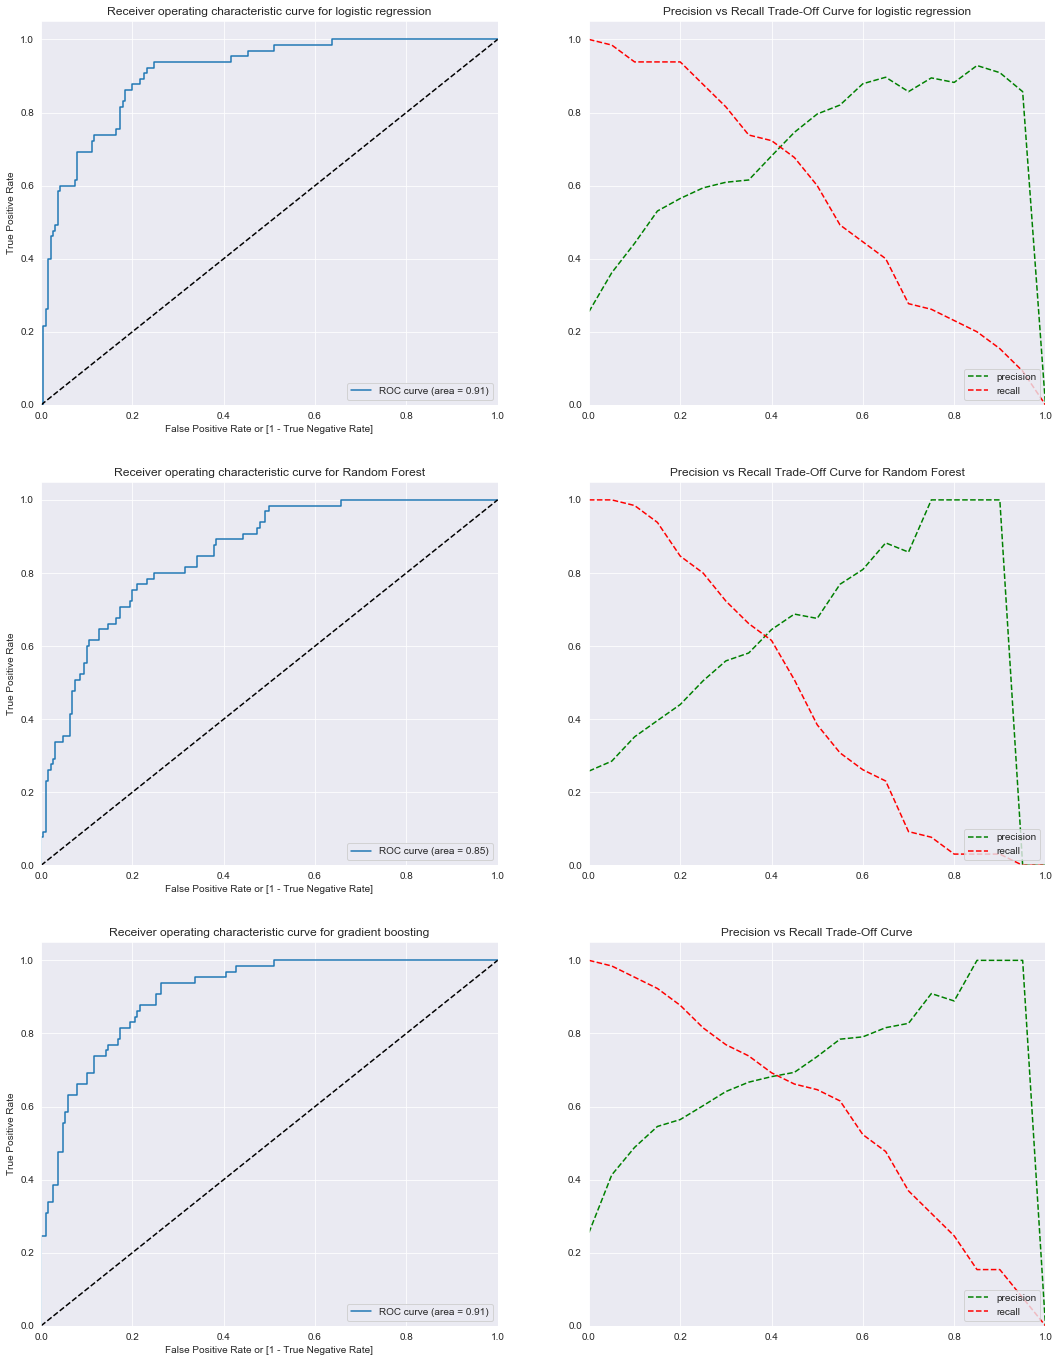

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (18,24))

# ax1.plot(log_fpr, gbm_tpr, label='ROC curve (area = %0.2f)' % 0.9077)
# ax1.plot([0, 1], [0, 1], 'k--')
# ax1.set_xlim([0.0, 1.0])
# ax1.set_ylim([0.0, 1.05])
# aax1.set_xlabel('False Positive Rate or [1 - True Negative Rate]')
# ax1.set_ylabel('True Positive Rate')
# ax1.set_title('Receiver operating characteristic curve')
# ax1.legend(loc="lower right")


# print('-------------- Logistic Regression with l1 penalty --------------------------------------')

axes[0,0].plot(log_fpr, log_tpr, label='ROC curve (area = %0.2f)' % 0.9077)
axes[0,0].plot([0, 1], [0, 1], 'k--')
axes[0,0].set_xlim([0.0, 1.0])
axes[0,0].set_ylim([0.0, 1.05])
axes[0,0].set_xlabel('False Positive Rate or [1 - True Negative Rate]')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('Receiver operating characteristic curve for logistic regression')
axes[0,0].legend(loc="lower right")

axes[0,1].plot(log_results['thresh'].values, log_results['prec'].values, 'g--', label = 'precision')
axes[0,1].legend(loc="lower right")
axes[0,1].plot(log_results['thresh'].values, log_results['recal'].values, 'r--', label = 'recall')
axes[0,1].legend(loc="lower right")
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_title('Precision vs Recall Trade-Off Curve for logistic regression')

# print('-------------- Random Forest --------------------------------------')

axes[1,0].plot(rf_fpr, rf_tpr, label='ROC curve (area = %0.2f)' % 0.8532)
axes[1,0].plot([0, 1], [0, 1], 'k--')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate or [1 - True Negative Rate]')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('Receiver operating characteristic curve for Random Forest')
axes[1,0].legend(loc="lower right")

axes[1,1].plot(rf_results['thresh'].values, rf_results['prec'].values, 'g--', label = 'precision')
axes[1,1].legend(loc="lower right")
axes[1,1].plot(rf_results['thresh'].values, rf_results['recal'].values, 'r--', label = 'recall')
axes[1,1].legend(loc="lower right")
axes[1,1].set_xlim([0.0, 1.0])
axes[1,1].set_ylim([0.0, 1.05])
axes[1,1].set_title('Precision vs Recall Trade-Off Curve for Random Forest')

# print('-------------- Random Forest --------------------------------------')

axes[2,0].plot(gbm_fpr, gbm_tpr, label='ROC curve (area = %0.2f)' % 0.9087)
axes[2,0].plot([0, 1], [0, 1], 'k--')
axes[2,0].set_xlim([0.0, 1.0])
axes[2,0].set_ylim([0.0, 1.05])
axes[2,0].set_xlabel('False Positive Rate or [1 - True Negative Rate]')
axes[2,0].set_ylabel('True Positive Rate')
axes[2,0].set_title('Receiver operating characteristic curve for gradient boosting')
axes[2,0].legend(loc="lower right")

axes[2,1].plot(gbm_results['thresh'].values, gbm_results['prec'].values, 'g--', label = 'precision')
axes[2,1].legend(loc="lower right")
axes[2,1].plot(gbm_results['thresh'].values, gbm_results['recal'].values, 'r--', label = 'recall')
axes[2,1].legend(loc="lower right")
axes[2,1].set_xlim([0.0, 1.0])
axes[2,1].set_ylim([0.0, 1.05])
axes[2,1].set_title('Precision vs Recall Trade-Off Curve')


From the above curves
1. Logistic regression and gradient boosting is performing on similar level where as  random forest is slightly underperforming
2. All precision curve follows similar pattern and both precision & recalls are high in the threshold regions of 0.3 to 0.5
3. Precision increases with the increase in threshold level where as recall decreases with threshold

#### Selecting the optimum threshold levels for each model

For selecting the optimum thresholds, since there is slight imbalance in the dataset, we cannot use accuracy or precision or recall. we need to use a metric which holds true with slightly im-balanced dataset like this

some of the metrics that can be used are
- F1 score
- Mathews correlation coefficient

In this assignment we would be using F1 score for selecting optimum threshold. Lets visualize the F1 scores of the three tuned models (logistic, random forest, gradient boosting) based on these thresholds

Text(0.5, 1.0, 'F1score for different thresholds - Gradient Boosting Regression Trees')

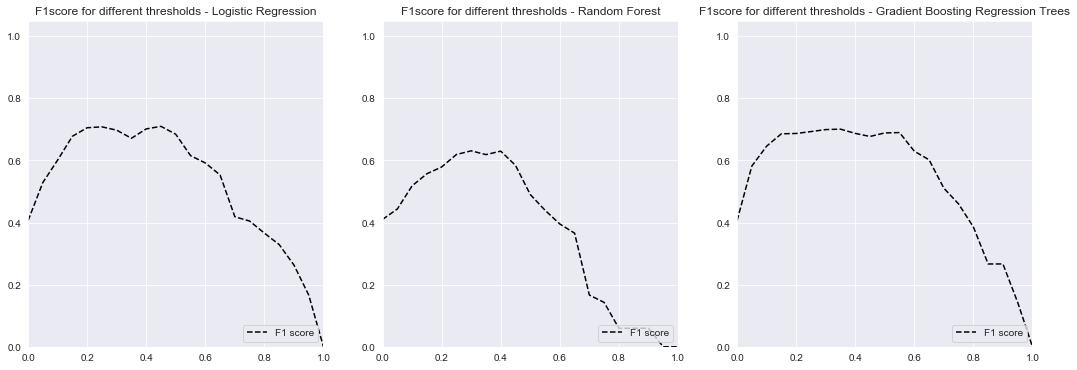

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,6))

ax1.plot(log_results['thresh'].values, log_results['f1score'].values, 'k--', label = 'F1 score')
ax1.legend(loc="lower right")
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_title('F1score for different thresholds - Logistic Regression')

ax2.plot(rf_results['thresh'].values, rf_results['f1score'].values, 'k--', label = 'F1 score')
ax2.legend(loc="lower right")
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_title('F1score for different thresholds - Random Forest')

ax3.plot(gbm_results['thresh'].values, gbm_results['f1score'].values, 'k--', label = 'F1 score')
ax3.legend(loc="lower right")
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_title('F1score for different thresholds - Gradient Boosting Regression Trees')

- From the above F1 score graphs, it is evident that F1score increases as the threshold increases reaches as maximum and then decreases. The threshold with the maximum F1 score is the ideal threshold
- For all the models, the maximum reaches in the thresholds range 0.3 to 0.5

In [ ]:
# Lets have a further closer look on the thresholds using the charts

F1scores = pd.DataFrame()

F1scores['thresholds'] = log_results['thresh']

# F1scores = F1scores.reset_index(drop = True)

F1scores['log_f1scores'] = log_results['f1score']
F1scores['rf_f1scores'] = rf_results['f1score']
F1scores['gbm_f1scores'] = gbm_results['f1score']
F1scores

thresholds  log_f1scores  rf_f1scores  gbm_f1scores
0.00        0.00      0.406250     0.410095      0.406250
0.05        0.05      0.528926     0.443686      0.581818
0.10        0.10      0.600985     0.518219      0.645833
0.15        0.15      0.677778     0.557078      0.685714
0.20        0.20      0.705202     0.578947      0.686747
0.25        0.25      0.708075     0.619048      0.692810
0.30        0.30      0.697368     0.630872      0.699301
0.35        0.35      0.671329     0.618705      0.700730
0.40        0.40      0.701493     0.629921      0.687023
0.45        0.45      0.709677     0.584071      0.677165
0.50        0.50      0.684211     0.490196      0.688525
0.55        0.55      0.615385     0.439560      0.689655
0.60        0.60      0.591837     0.395349      0.629630
0.65        0.65      0.553191     0.365854      0.601942
0.70        0.70      0.418605     0.166667      0.510638
0.75        0.75      0.404762     0.142857      0.459770
0.80        0.80      0.365854     0.059701      0.385542
0.85        0.85      0.329114     0.059701      0.266667
0.90        0.90      0.263158     0.059701      0.266667
0.95        0.95      0.166667     0.000000      0.142857
1.00        1.00      0.000000     0.000000      0.000000

From the above table, the maximum f1 score and corresponding thresholds are

- Logistic Regression: Max F1score - 0.7096, Threshold - 0.45
- Random Forest: Max F1score - 0.6308, Threshold - 0.3
- GBRT : Max F1score -  0.7007, Threshold - 0.35

#### Lets look at precision recall at these optimum thresholds for the test dataset

In [ ]:
results = pd.DataFrame({'threshold':[], 'accuracy': [], 'precision': [], 'recall': [], 'F1score': []})
results

Empty DataFrame
Columns: [threshold, accuracy, precision, recall, F1score]
Index: []

In [ ]:
results.loc['Logisitc_Regression'] = log_results.loc[0.45].values
results.loc['Random_Forest'] = log_results.loc[0.3].values
results.loc['GBRT'] = log_results.loc[0.35].values

In [ ]:
results

threshold  accuracy  precision    recall   F1score
Logisitc_Regression       0.45  0.858824   0.745763  0.676923  0.709677
Random_Forest             0.30  0.819608   0.609195  0.815385  0.697368
GBRT                      0.35  0.815686   0.615385  0.738462  0.671329

Preicision and recall both looks good for each of the tuned model

### Features influencing the popularity of the charing pool stations

In [ ]:
rf_imp = rf_m_final.feature_importances_
log_imp = log_m_final.coef_[0]
gbm_imp = gbm_m_final.feature_importances_

feature_imp = pd.DataFrame({'columns': X_train.columns, 'logistic': log_imp, 'rf': rf_imp, 'GBRT': gbm_imp})

In [ ]:
feature_imp

columns  logistic        rf      GBRT
0                       LS_1  0.000000  0.003290  0.001664
1                        PC2 -0.018388  0.000978  0.003768
2                        PC4  0.120359  0.002385  0.003816
3                        PC5  0.000000  0.004188  0.000764
4                        PC6  0.000000  0.003855  0.001200
5                        PC7  0.000000  0.003941  0.001235
6                       PC13  0.000000  0.005504  0.004945
7                       PC14  0.000000  0.003581  0.002185
8                       PC17 -0.116627  0.004238  0.002734
9                        PC8  0.000000  0.003234  0.001364
10                       PC9  0.000000  0.003636  0.002256
11                      PC10  0.000000  0.003538  0.000949
12                      PC11  0.000000  0.004477  0.004081
13                      PC12  0.000000  0.003046  0.003458
14                      PC18  0.000000  0.004051  0.000965
15                      PC22  0.000000  0.002639  0.002314
16                      PC24  0.000000  0.003209  0.001149
17                      PC25  0.145587  0.004810  0.000969
18                      PC26 -0.024611  0.002949  0.000085
19                      PC27 -0.097742  0.007237  0.003934
20                      PC28  0.000000  0.004217  0.000000
21                      PC29 -0.048158  0.001557  0.002786
22                      PC30  0.000000  0.002248  0.001029
23                      PC31  0.050240  0.000215  0.000000
24                      PC32 -0.050384  0.001119  0.000000
25                      PC33 -0.263899  0.008631  0.006382
26                      PC34  0.117672  0.001900  0.003903
27                      PC35  0.000000  0.002270  0.000746
28                      PC36  0.232092  0.008519  0.010905
29                      PC37  0.095884  0.004004  0.001050
30                      PC38  0.015861  0.007982  0.004911
31                      PC39  0.000000  0.003593  0.001478
32                      PC40  0.000000  0.003552  0.002383
33                      PC41  0.000000  0.003702  0.004166
34                      PC42  0.000000  0.006842  0.003762
35                      PC43  0.000000  0.004442  0.005846
36                      PC44  0.001632  0.003233  0.007984
37                       PC3  0.062117  0.002992  0.000000
38                      N_14  0.032239  0.004417  0.008684
39                      N_15  0.000000  0.014441  0.007660
40                       N_3  0.000000  0.003887  0.001164
41                      N_16  0.000000  0.003531  0.001781
42                      N_18  0.000000  0.004544  0.000789
43                      N_19  0.000000  0.005899  0.009537
44                      N_20  0.000000  0.003350  0.001969
45                      N_21  0.000000  0.004808  0.002106
46                      N_25  0.000000  0.003309  0.003691
47                      N_26  0.000000  0.009109  0.016318
48                      N_27  0.000000  0.003563  0.001815
49                      N_33  0.000000  0.004813  0.001385
50                      N_34  0.000000  0.005525  0.006094
51                      N_35 -0.157783  0.004747  0.007560
52                      N_36  0.000000  0.003006  0.002146
53                      N_24  0.000000  0.005319  0.001888
54                      N_31 -0.181407  0.018724  0.013378
55                      N_37  0.000000  0.005474  0.001001
56                      N_38  0.000000  0.005473  0.000351
57                      N_39  0.000000  0.004904  0.003537
58                      N_40  0.000000  0.003249  0.000404
59                      N_41  0.000000  0.004442  0.002592
60                      N_42  0.000000  0.004577  0.001836
61                      N_43  0.000000  0.006631  0.003122
62                      N_44 -0.190631  0.002480  0.012977
63                      N_45 -0.050516  0.003026  0.003355
64                      N_46  0.624409  0.033971  0.057395
65                      N_47  0.103608  0.009467  0.007923
66                      N_48  0.081218  0.014457  0.008085
67       

From the above table, logistic with l1 penalty can results in sparse coefficients and therefore feature selection. Lets understand the importand features using logistic regression

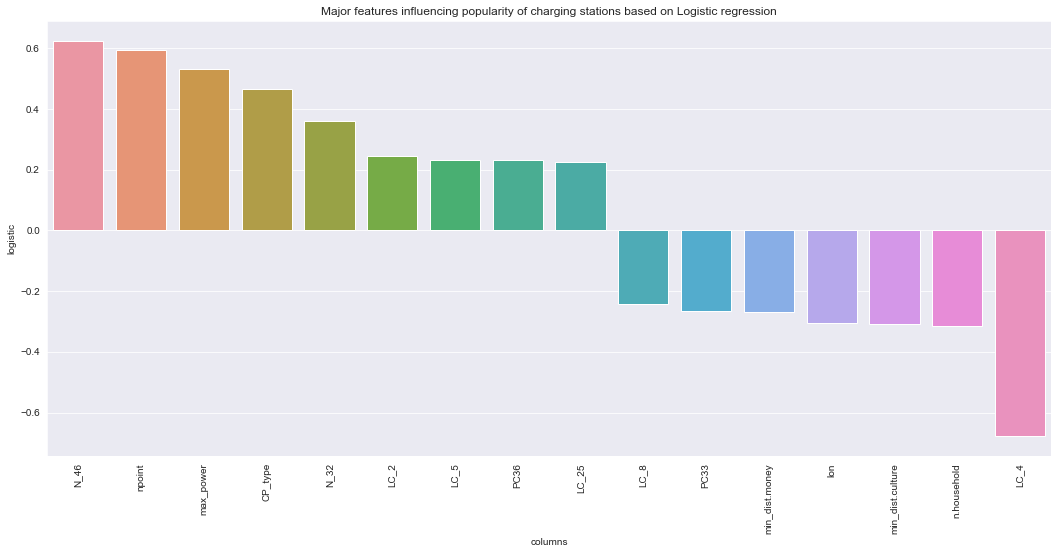

In [ ]:
# features that can effect popularity of charging pool station based on logistic regression

log_feat_imp = feature_imp[['columns', 'logistic']].sort_values('logistic', axis = 0)
log_feat_imp = log_feat_imp[log_feat_imp['logistic'] != 0].sort_values('logistic', axis = 0, ascending = False)

# selecting features that having importance more than 0.2
log_feat_imp = log_feat_imp[(log_feat_imp['logistic'] >= 0.2) |(log_feat_imp['logistic'] <= -0.2)]

plt.figure(figsize = (18,8))
sns.barplot(x = log_feat_imp['columns'], y = log_feat_imp['logistic'])
plt.xticks(rotation = 90)
plt.title('Major features influencing popularity of charging stations based on Logistic regression')
plt.show()


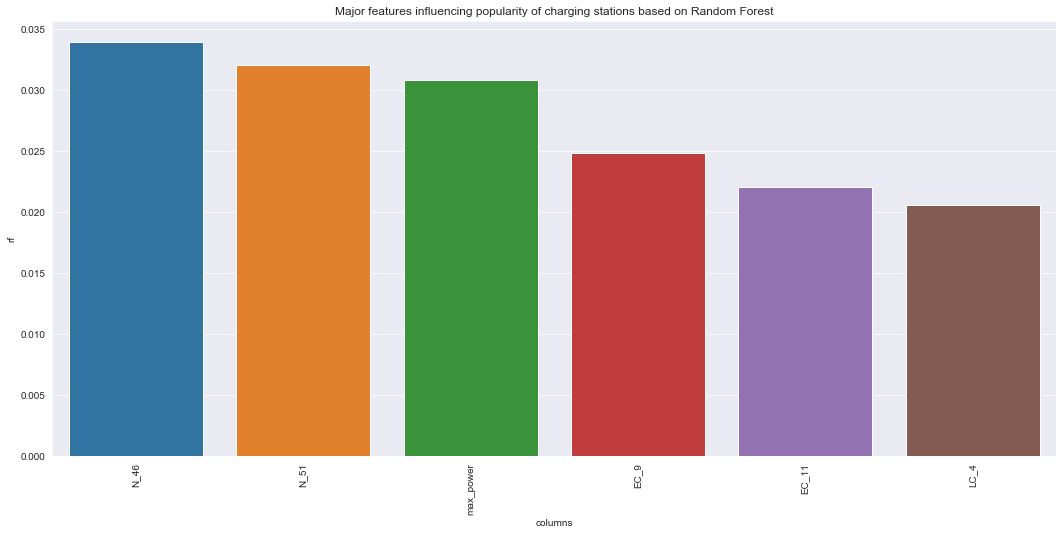

In [ ]:
# features that can effect popularity of charging pool station based on random forest

rf_feat_imp = feature_imp[['columns', 'rf']].sort_values('rf', axis = 0)

# selecting features that having importance more than 0.02
rf_feat_imp = rf_feat_imp[(rf_feat_imp['rf'] >= 0.02) |(rf_feat_imp['rf'] <= -0.02)].sort_values('rf', axis = 0, ascending = False)

plt.figure(figsize = (18,8))
sns.barplot(x = rf_feat_imp['columns'], y = rf_feat_imp['rf'])
plt.xticks(rotation = 90)
plt.title('Major features influencing popularity of charging stations based on Random Forest')
plt.show()


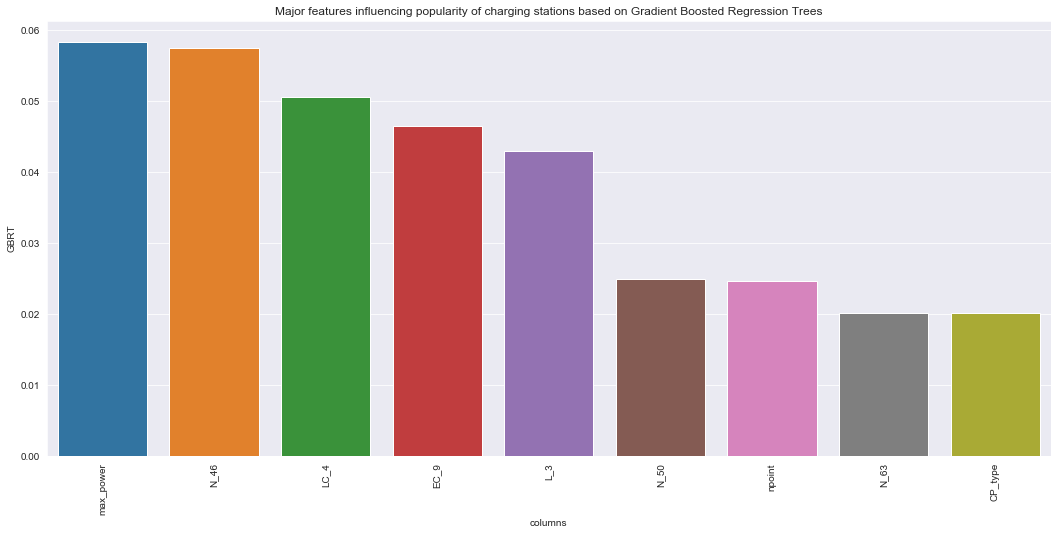

In [ ]:
# features that can effect popularity of charging pool station based on Gradient boosted Regression Trees

gbm_feat_imp = feature_imp[['columns', 'GBRT']].sort_values('GBRT', axis = 0)

# selecting features that having importance more than 0.02
gbm_feat_imp = gbm_feat_imp[(gbm_feat_imp['GBRT'] >= 0.02) |(gbm_feat_imp['GBRT'] <= -0.02)].sort_values('GBRT', axis = 0, ascending = False)

plt.figure(figsize = (18,8))
sns.barplot(x = gbm_feat_imp['columns'], y = gbm_feat_imp['GBRT'])
plt.xticks(rotation = 90)
plt.title('Major features influencing popularity of charging stations based on Gradient Boosted Regression Trees')
plt.show()


End of the Document
***************